## Table Of Contents:
* [Introduction](#Introduction)
* [Exploratory Data Analysis](#EDA)
    * [Add Errors to data](#AddError)
* [Feature Engineering](#FE)
* [Common mistake made with left merge and backfill (Ignoring simultaneous failures)](#Mistake)
* [Solution for mistake ](#Solution)
* [Modelling ](#Model)
    * [24 hr pred. 3 hr lag](#Model24_lag3)
    * [36 hr pred. 3 hr lag](#Model48_lag3)
    * [48 hr pred. 3 hr lag](#Model48_lag6)
    * [24 hr pred. 3 hr shift column lag](#Model24_shift_lag)
    * [48 hr pred. 3 hr shift column lag](#Model48_shift_lag)
* [Observation](#Observation)
    * [Prediction and Model Evaluation & Comparison](#ModelEval) 
    * [General Observation](#Observation)
    * [This Dataset 'designed' for 24 hour prediction](#Ob_design)
 

<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h1 style="text-align:center;font-weight: bold;">Introduction</h1>
<a class="anchor" id="Introduction"></a>

The original goal of this project is to build 2 predictive models 1 that a machine component (1, 2, 3, or 4) will fail in the next 24 hours and the second in 48 hours. As the project evolved, with new challenges and observations the scope changed to add prediction for 36 hours and more component failure classes. 

As an AVEVA OSISoft PI System Consltant, I have worked with several companies over 25 years. One weakness I have found is some companies do not integrated maintenance data with real time sensor data from the PI System and a tool developed to predict equipment failure.
    
With that in mind, I decided to do a Machine Learning project on Predictive Maintenance using sensor data and data from a Maintenance system.

The dataset was downloaded from https://www.kaggle.com/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance
    
Predictive Maintenance relies on historical equipment health data to anticipate future points of failure. This allows for the proactive scheduling of part replacements, just ahead of the actual breakdown. The ultimate goal is to detect anomalies in your operation and possible defects in equipment to prevent failure!
    
**I am constantly learning and would love to get feedback on my approach to the simultaneous failures, shift columns lag features, and This Dataset 'designed' for 24-hour prediction.**
</div>





<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h3 style="text-align:center;font-weight: bold;">PI AF Server</h3>

The failure dataset has timestamps at 06:00. In the real world using the PI System, the maintenance system would be integrated with the advanced computing power of PI AF Server and the exact failure and error times would be in the database, along with other meta data. For training the model, the PI system analysis engine  would be setup to recalculate and backfill using event frames for 24 hours or for whatever periods one would want the model to predict based on historical archived data. The event frames would have the lag feaures calculated (e.g. x hour averages, min, etc). This data would be send to the model for training. Unlike the downloaded kaggle dataset, the PI AF Server would be configured to provide lag data into a more accurate and simple form for the model to process.    
</div>





<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h3 style="text-align:center;font-weight: bold;">Importing Libraries</h3>



</div>





In [1]:
'''import os
from google.colab import drive

MOUNTPOINT = "/content/gdrive"
DATADIR = os.path.join(MOUNTPOINT, "MyDrive")
drive.mount(MOUNTPOINT)'''
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/microsoft-azure-predictive-maintenance/PdM_errors.csv
/kaggle/input/microsoft-azure-predictive-maintenance/PdM_telemetry.csv
/kaggle/input/microsoft-azure-predictive-maintenance/PdM_failures.csv
/kaggle/input/microsoft-azure-predictive-maintenance/PdM_machines.csv
/kaggle/input/microsoft-azure-predictive-maintenance/PdM_maint.csv


In [2]:
dir = "/kaggle/input/microsoft-azure-predictive-maintenance/"

In [3]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV, KFold, TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor, HistGradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline, make_pipeline
from prettytable import PrettyTable
import re
# import plotly.offline as pyo
# pyo.init_notebook_mode()

<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h3 style="text-align:center;font-weight: bold;">Load Data</h3>



</div>





In [4]:
'''telemetry = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/PdM_telemetry.csv')
errors = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/PdM_errors.csv')
maint = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/PdM_maint.csv')
failures = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/PdM_failures.csv')
machines = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/PdM_machines.csv')'''

telemetry = pd.read_csv(dir + 'PdM_telemetry.csv')
failures = pd.read_csv(dir + 'PdM_failures.csv')
errors = pd.read_csv(dir + 'PdM_errors.csv')
maint = pd.read_csv(dir + 'PdM_maint.csv')
machines = pd.read_csv(dir + 'PdM_machines.csv')


<a class="anchor" id="EDA"></a>
# Exploratory Data Analysis



### Dataset Description:
There are 5 CSV files consisting of:

- <b>Telemetry Time Series Data (PdM_telemetry.csv):</b> This dataset contains hourly averages of voltage, rotation, pressure, and vibration collected from 100 machines throughout the year 2015. It serves as a record of automated communication processes from various data sources.


- <b>Error (PdM_errors.csv):</b> This dataset documents errors that machines encounter while in operation. It's worth noting that these errors do not lead to machine failures, as the machines continue to operate. The error date and times are rounded to the nearest hour to align with the hourly telemetry data collection rate.


- <b>Maintenance (PdM_maint.csv):</b> This dataset records the replacement of machine components. Such replacements occur in two scenarios: during regularly scheduled maintenance visits (Proactive Maintenance) or as a response to component breakdown, necessitating unscheduled maintenance (Reactive Maintenance). The latter is considered a failure, and corresponding data is also captured in the Failures dataset. Maintenance data encompasses records from both 2014 and 2015 and is time-stamped to the nearest hour in line with the telemetry data collection intervals.
    

- <b>Failures (PdM_failures.csv):</b> Each entry in this dataset signifies the replacement of a machine component due to failure. It's important to note that this dataset is a subset of the Maintenance data, and the timestamps are rounded to the nearest hour to align with the telemetry data collection schedule.


- <b>Metadata of Machines (PdM_Machines.csv):</b> This dataset provides information on the machine models and their ages, offering essential contextual details about the machines in question.

In [5]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [6]:
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [7]:
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [8]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [9]:
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


<a class="anchor" id="AddError"></a>
### To make data more realistic, 3 random outlier records for a random machine ID will be created. Based on experience there can be sensor malfunction especially with old sensors.

In [10]:
# Define the datetime, machineID, and columns to append
append_datetime = '2015-07-08 06:45' # Use a dateime that is not on dataset to preserve original data
append_machineID = int(np.random.rand()*100)
columns_to_append = ['volt', 'rotate', 'pressure', 'vibration']

# Generate random data to append
num_rows_to_append = 3  # Number of rows to append
random_data = {
    'datetime': [append_datetime] * num_rows_to_append,
    'machineID': [append_machineID] * num_rows_to_append
}

for column in columns_to_append:
    random_data[column] = np.random.rand(num_rows_to_append) * 100000  # Insert erroneous values

# Create a DataFrame for the random data
random_data_df = pd.DataFrame(random_data)

# Append the random data to the telemetry DataFrame
telemetry = pd.concat([telemetry, random_data_df], ignore_index=True)
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876103.000000,876103.000000,876103.000000,876103.000000,876103.000000
mean,50.499902,170.953577,446.830813,101.053092,40.618043
std,28.866085,108.519225,149.553972,118.485919,142.414229
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.000000,160.304963,412.305765,93.498202,36.777304
50%,50.000000,170.607417,447.558712,100.425585,40.237257
75%,75.000000,181.004502,482.177072,107.555278,43.784974
max,100.000000,86997.146951,94991.203490,95526.803257,95901.194425


### Format datatime to Pandas datetime

In [11]:
# Format date & time.
tables = [telemetry, maint, failures, errors]
for table in tables:
    table["datetime"] = pd.to_datetime(table["datetime"],format='mixed') #format="%Y-%m-%d %H:%M:%S" ) #format='mixed') #
    table.sort_values(["datetime", "machineID"], inplace=True, ignore_index=True)

<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h3 style="text-align:center;font-weight: bold;">EDA on Telemetry Data</h3>
</div>

In [12]:
print(f"Total number of telemetry records: {len(telemetry.index)}" )
print(telemetry.describe())

Total number of telemetry records: 876103
                            datetime      machineID           volt  \
count                         876103  876103.000000  876103.000000   
mean   2015-07-02 18:00:01.636451584      50.499902     170.953577   
min              2015-01-01 06:00:00       1.000000      97.333604   
25%              2015-04-02 12:00:00      25.000000     160.304963   
50%              2015-07-02 18:00:00      50.000000     170.607417   
75%              2015-10-02 00:00:00      75.000000     181.004502   
max              2016-01-01 06:00:00     100.000000   86997.146951   
std                              NaN      28.866085     108.519225   

              rotate       pressure      vibration  
count  876103.000000  876103.000000  876103.000000  
mean      446.830813     101.053092      40.618043  
min       138.432075      51.237106      14.877054  
25%       412.305765      93.498202      36.777304  
50%       447.558712     100.425585      40.237257  
75%      

<b>Based on maximum values there is clearly some errors in data set. Erroneous Data will need to be found. For simplicity use Interquartile Range (IQR) to detect outliers

In [13]:
cols = ['volt', 'rotate', 'pressure', 'vibration']
for col in cols:
    Q1 = telemetry[col].quantile(0.1)
    Q3 = telemetry[col].quantile(0.90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = telemetry[(telemetry[col] < lower_bound) | (telemetry[col] > upper_bound)]
    print(f"{col}_outliers : \n{outliers}")

volt_outliers : 
                  datetime  machineID          volt        rotate  \
334620 2015-05-20 16:00:00         21    250.870453    499.702517   
451300 2015-07-08 06:45:00         22  46194.793465  94991.203490   
451301 2015-07-08 06:45:00         22  86997.146951  13946.913315   
451302 2015-07-08 06:45:00         22  21374.910607  90132.582025   
765733 2015-11-16 07:00:00         31    255.124717    535.599871   

            pressure     vibration  
334620    104.247845     49.833998  
451300  49404.534227  17519.950374  
451301  95526.803257  95901.194425  
451302  25706.351763  90863.767489  
765733    120.334615     41.050507  
rotate_outliers : 
                  datetime  machineID          volt        rotate  \
30584  2015-01-13 23:00:00         85    174.085237    176.922119   
36980  2015-01-16 15:00:00         81    164.297095    167.099105   
175223 2015-03-15 06:00:00         24    152.406161    177.433821   
189664 2015-03-21 06:00:00         65    172.335787

<b>After manual inspection the identified outliers or erroneous data points were found on datetime 2015-07-08 06:45:00. Based on SCADA Automation team's domain knowledge, it's determined to be instrumentation errors and should be removed.

In [14]:
telemetry = telemetry[telemetry['datetime'] != '2015-07-08 06:45']
telemetry.describe()

,datetime,machineID,volt,rotate,pressure,vibration
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,170.777736,446.605119,100.858668,40.385007
min,2015-01-01 06:00:00,1.000000,97.333604,138.432075,51.237106,14.877054
25%,2015-04-02 12:00:00,25.750000,160.304927,412.305714,93.498181,36.777299
50%,2015-07-02 18:00:00,50.500000,170.607338,447.558150,100.425559,40.237247
75%,2015-10-02 00:00:00,75.250000,181.004493,482.176600,107.555231,43.784938
max,2016-01-01 06:00:00,100.000000,255.124717,695.020984,185.951998,76.791072
std,NaN,28.866087,15.509114,52.673886,11.048679,5.370361


This process is often iterative. After data cleaning, you may need to re-analyze the data, and if necessary, repeat the process to ensure data quality.
Data looks OK now.

# Plot all Sensor data for a Machine for the dataset.

In [15]:
plot_df = telemetry.loc[(telemetry['machineID'] == 1) &
                        (telemetry['datetime'] > pd.to_datetime('2015-01-01')) &
                        (telemetry['datetime'] < pd.to_datetime('2016-02-01')), ['datetime', 'volt','rotate', 'pressure','vibration']]

In [16]:
# Create the figure
''' Available templates : ['ggplot2', 'seaborn', 'simple_white', 'plotly', 'plotly_white',
                           'plotly_dark', 'presentation', 'xgridoff', 'ygridoff', 'gridon', 'none']'''

fig = go.Figure()

# Add the traces for 'volt', 'rotate', 'pressure', and 'vibration' using different y-axes
fig.add_trace(go.Scatter(x=plot_df['datetime'].values, y=plot_df['volt'].values, name='Voltage', yaxis='y'))
fig.add_trace(go.Scatter(x=plot_df['datetime'].values, y=plot_df['rotate'].values, name='Rotation', yaxis='y2'))
fig.add_trace(go.Scatter(x=plot_df['datetime'].values, y=plot_df['pressure'].values, name='Pressure', yaxis='y3'))
fig.add_trace(go.Scatter(x=plot_df['datetime'].values, y=plot_df['vibration'].values, name='Vibration', yaxis='y4'))

# Update the layout to show four y-axes
fig.update_layout(
    title='Machine 1 Sensor Data over Time',
    xaxis_title='Date',
    template='seaborn',
    yaxis=dict(title='Voltage', side='left', position=0),
    yaxis2=dict(title='Rotation', overlaying='y', side='left', position=0.02),
    yaxis3=dict(title='Pressure', overlaying='y', side='right', position=0.97),
    yaxis4=dict(title='Vibration', overlaying='y', side='right', position=1),
    legend=dict(orientation="h", y=-0.1, x=0.25)  # Adjust legend position
)
# Show the plot
fig.show()

Click on legend to hide/unhide trend line
Highlight and select data range
Pan feature is available

 <div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h3 style="text-align:center;font-weight: bold;">EDA on Errors Data</h3>



</div>





In [17]:
errors['errorID'] = errors['errorID'].astype('object')

print(f"Total number of error records: {len(errors.index)}")
errors.head()

Total number of error records: 3919


,datetime,machineID,errorID
0,2015-01-01 06:00:00,24,error1
1,2015-01-01 06:00:00,73,error4
2,2015-01-01 06:00:00,81,error1
3,2015-01-01 07:00:00,43,error3
4,2015-01-01 08:00:00,14,error4


In [18]:
fig = px.bar(x=errors['errorID'].values,
             title='Count of Errors', template='none', color=errors['errorID'].values)
fig.update_layout(xaxis_title='Error Type', yaxis_title='Count',xaxis={'categoryorder':'total descending'})

# Show the plot
fig.show()

<Axes: title={'center': 'Number of errors for MachineID'}, ylabel='machineID'>

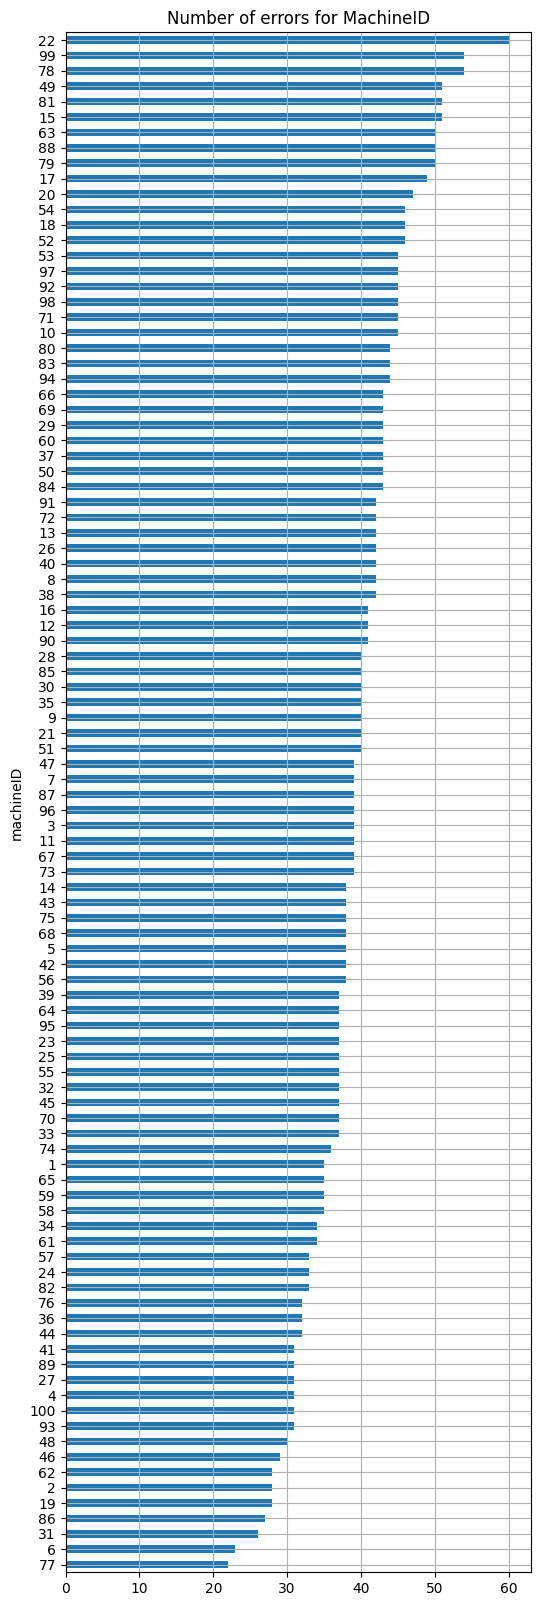

In [19]:
errors["machineID"].value_counts(
                normalize=False, dropna=False).sort_values().plot(
                kind='barh', figsize=(6, 20), grid=True,
                title="Number of errors for MachineID")

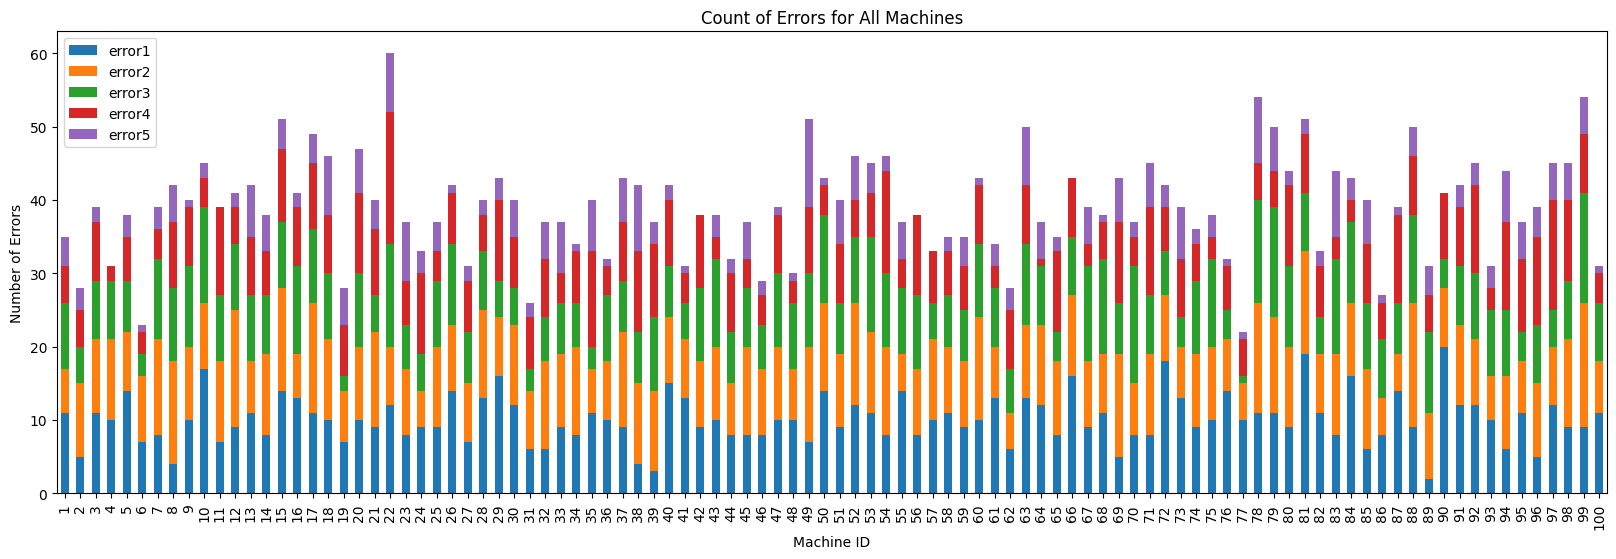

In [20]:
error_cnt = errors.groupby(["machineID", "errorID"]).size().reset_index()
error_cnt.columns = ["machineID", "errorID", "error_val"]
error_cnt_pivot = pd.pivot(error_cnt, index="machineID", columns="errorID", values="error_val").rename_axis(None, axis=1)
error_cnt_pivot.plot.bar(stacked=True, figsize=(20, 6), title="Count of Errors for All Machines")
plt.xlabel("Machine ID")
plt.ylabel("Number of Errors");

<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h3 style="text-align:center;font-weight: bold;">EDA on Maintainence Data</h3>
</div>





In [21]:
maint['comp'] = maint['comp'].astype('object')

print(f"Total number of maintenance records: {len(maint.index)}")
maint.head()

Total number of maintenance records: 3286


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-06-01 06:00:00,6,comp2
2,2014-06-01 06:00:00,9,comp1
3,2014-06-01 06:00:00,9,comp2
4,2014-06-01 06:00:00,11,comp2


In [22]:
fig = px.bar(x=maint['comp'].values,
             title='Count of Comp', template='none', color=maint['comp'].values) #
fig.update_layout(xaxis_title='Comp Type', yaxis_title='Count',xaxis={'categoryorder':'total descending'})
fig.show()

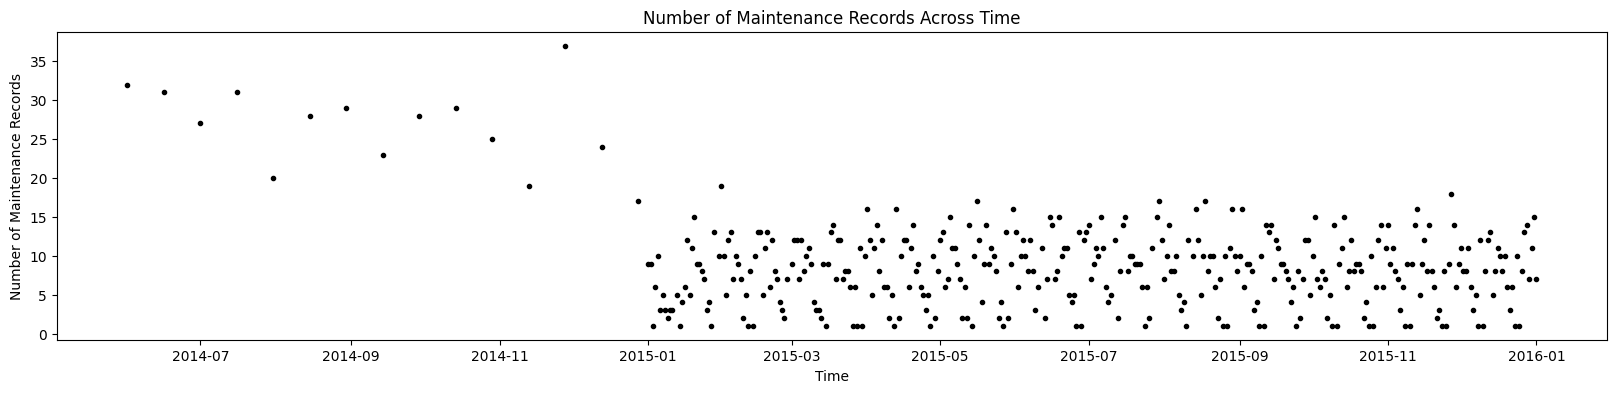

In [23]:
maint.datetime.dt.date.value_counts().plot(
    style="k.",
    figsize=(20, 4),
    title="Number of Maintenance Records Across Time")
plt.ylabel("Number of Maintenance Records")
plt.xlabel("Time")
plt.show()

This indicates that data is sparse in 2014 when compared to the number of maintenance records in 2015.

<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h3 style="text-align:center;font-weight: bold;">EDA on Machine Data</h3>



</div>





In [24]:
machines['model'] = machines['model'].astype('object')

print(f"Total number of machines: {len(machines.index)}")
machines.head()

Total number of machines: 100


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


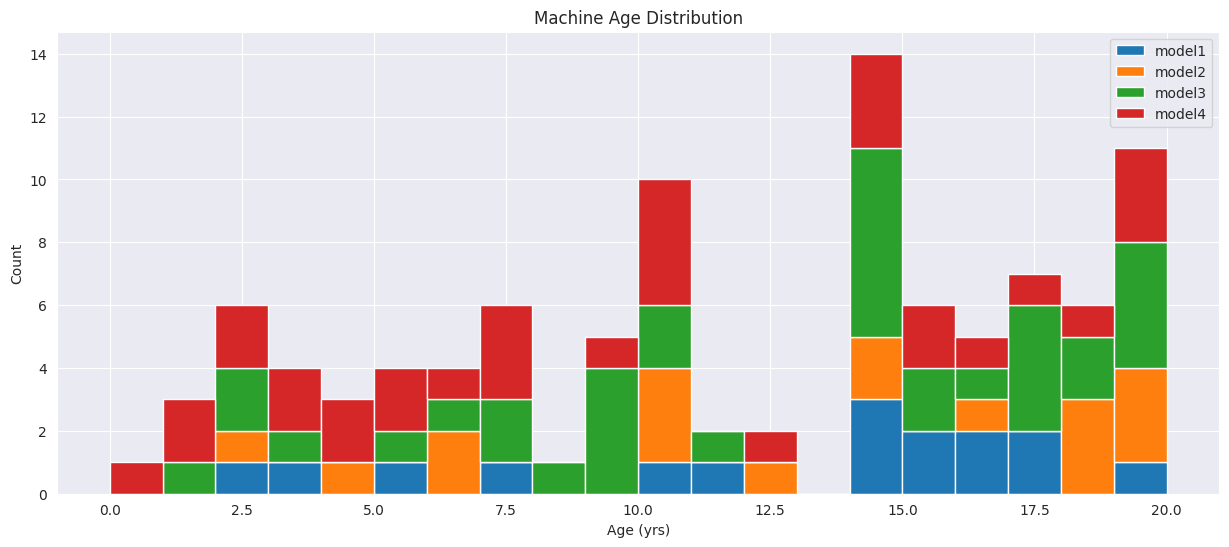

In [25]:

sns.set_style("darkgrid")
plt.figure(figsize=(15, 6))
_, bins, _ = plt.hist([machines.loc[machines['model'] == 'model1', 'age'],
                       machines.loc[machines['model'] == 'model2', 'age'],
                       machines.loc[machines['model'] == 'model3', 'age'],
                       machines.loc[machines['model'] == 'model4', 'age']],
                       20, stacked=True, label=['model1', 'model2', 'model3', 'model4'])
plt.xlabel('Age (yrs)')
plt.ylabel('Count')
plt.title('Machine Age Distribution')
plt.legend()
plt.show()

<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">EDA on Failure Data</h2>



</div>





In [26]:
failures['failure'] = failures['failure'].astype('object')

print(f"Total number of failures: {len(failures.index)}")
failures.head()

Total number of failures: 761


,datetime,machineID,failure
0,2015-01-02 03:00:00,16,comp1
1,2015-01-02 03:00:00,16,comp3
2,2015-01-02 03:00:00,17,comp4
3,2015-01-02 03:00:00,22,comp1
4,2015-01-02 03:00:00,35,comp1


In [27]:
fig = px.bar(x=failures['failure'].values, title='Count of Failures', template='none', color=failures['failure'].values)
fig.update_layout(xaxis_title='Failure Type', yaxis_title='Count',xaxis={'categoryorder':'total descending'})
fig.show()

The Failures dataset records a total of 761 failure instances. The majority of these failures are attributed to component-2. Need to investigate the underlying reasons for these component-2 failures to reduce the overall incidence of equipment failures in the future.

<a class="anchor" id="FE"></a>
#                     Feature Engineering

<div style="color:white;
           display:fill;
           border-radius:15px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h3 style="text-align:center;font-weight: bold">Predictive Maintenance and Time Series Data</h3>

Base on research from an article from **Jason Brownlee PhD**. Time Series data must be re-framed as a supervised learning dataset before we can start using machine learning algorithms.

There is no concept of input and output features in time series. Instead, we must choose the variable to be predicted and use feature engineering to construct all of the inputs that will be used to make predictions for future time steps.

We must invent input and output variables too and frame the supervised learning problem from scratch.
In effect, the best default strategy is to use all the knowledge available to create many good datasets from your time series dataset and use model performance (and other project requirements) to help determine what good features and good views of your problem happen to be.  

Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems. A common method is to pick a window size for the lag features to be created and compute rolling aggregate measures such as mean, standard deviation, minimum, maximum, etc. to represent the short term history of the telemetry over the lag window.
</div>


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h3 style="text-align:center;font-weight: bold;">Lag Feature Engineering</h3>



</div>





<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h4 style="text-align:center;font-weight: bold;">Create Lag Features functions</h4>



</div>





In [28]:
# ## Note on append pd.pivot_table ##
# Within the loop, a pandas pivot_table operation is performed
# This operation is used to create a pivot table, which essentially reshapes the data.
# Index='datetime': The 'datetime' column is specified as the index for the pivot table.
# columns='machineID': The 'machineID' column is specified as the column headers for the pivot table.
# values=col: The 'col' variable, which represents the feature of interest, is used as the values
# to populate the pivot table.
# .resample('3H', closed='left', label='right'): After creating the pivot table, a time series resampling operation
# is applied. The .resample method is used to resample the data with a time interval of 3 hours.
# The parameters used are: closed='left': This specifies that the resampling should be based on the left-closed intervals
# (e.g., if the original data had timestamps at 1:00, 4:00, 7:00, etc., the 3-hour intervals would be
# [1:00-4:00], [4:00-7:00], etc.).
# label='right': This specifies that the labels for the resampled intervals should be placed on the right side of
# each interval.
# .first(): The .first() method is used to select the first value within each resampled interval. This is often
# used to downsample data when multiple values fall within the same interval.
# .unstack(): The .unstack() method is applied to reshape the result, essentially reverting it back to a
# tabular format where 'machineID' becomes a column instead of multi-level columns. For window = 24
# .rolling(window=24, center=False): A rolling window calculation is performed on the unstacked data.
# This calculates a rolling sum within a window of 24 data points. The center=False parameter specifies that
# the rolling window should not be centered around each data point but should start from the current point
# and include the next 23 data points.
# .sum(): The rolling sum is calculated for each rolling window.

In [29]:
def resample_feat_rule(df, features, rule, aggrs):
    # Calculate "resample 'min', 'max', 'mean', or 'std' values" over the last 'input rule' hour lag window
    # for telemetry features.
    temp = []
    columns = []
    for aggr in aggrs: # loop iterates through the aggregate list
        for col in features: # loop iterates through the columns in feature list
            if aggr == 'min':
                temp.append(pd.pivot_table(df,
                                           index='datetime',
                                           columns='machineID',
                                           values=col).resample(rule, closed='left', label='right').min().unstack())
            elif aggr == 'max':
                temp.append(pd.pivot_table(df,
                                           index='datetime',
                                           columns='machineID',
                                           values=col).resample(rule, closed='left', label='right').max().unstack())
            elif aggr == 'mean':
                temp.append(pd.pivot_table(df,
                                           index='datetime',
                                           columns='machineID',
                                           values=col).resample(rule, closed='left', label='right').mean().unstack())
            elif aggr == 'std':
                temp.append(pd.pivot_table(df,
                                           index='datetime',
                                           columns='machineID',
                                           values=col).resample(rule, closed='left', label='right').std().unstack())
            else:
                raise ValueError("Invalid method name. Use 'min', 'max', 'mean', or 'standard deviation'.")
        df_temp = pd.concat(temp, axis=1)
        columns = columns + [i + '_' + aggr + '_' + rule.lower() for i in features]
    df_temp.columns = columns
    df_temp.reset_index(inplace=True)
    return df_temp

In [30]:
def roll_resample_feat_rule(df, features, window, rule, aggrs):
    # Calculate "rolling resample 'min', 'max', 'mean', 'std' or sum values" over the last 'input rule' hour lag window
    # for telemetry features.
    temp = []
    columns = []
    for aggr in aggrs: # loop iterates through the aggregate list
        for col in features: # loop iterates through the columns in feature list
            if aggr == 'min':
                temp.append(pd.pivot_table(df, index='datetime',
                                               columns='machineID',
                                               values=col).rolling(window=window,
                                                                    center=False).min().resample(rule,
                                                                                    closed='left',
                                                                                    label='right').first().unstack())
            elif aggr == 'max':
                temp.append(pd.pivot_table(df, index='datetime',
                                               columns='machineID',
                                               values=col).rolling(window=window,
                                                                    center=False).max().resample(rule,
                                                                                    closed='left',
                                                                                    label='right').first().unstack())
            elif aggr == 'mean':
                temp.append(pd.pivot_table(df, index='datetime',
                                               columns='machineID',
                                               values=col).rolling(window=window,
                                                                    center=False).mean().resample(rule,
                                                                                    closed='left',
                                                                                    label='right').first().unstack())
            elif aggr == 'std':
                temp.append(pd.pivot_table(df, index='datetime',
                                               columns='machineID',
                                               values=col).rolling(window=window,
                                                                    center=False).std().resample(rule,
                                                                                    closed='left',
                                                                                    label='right').first().unstack())
            elif aggr == 'sum':
                temp.append(pd.pivot_table(df, index='datetime',
                                               columns='machineID',
                                               values=col).rolling(window=window,
                                                                    center=False).sum().resample(rule,
                                                                                    closed='left',
                                                                                    label='right').first().unstack())
            else:
                raise ValueError("Invalid method name. Use 'min', 'max', 'mean', or 'standard deviation' , or 'sum'.")
        df_temp = pd.concat(temp, axis=1)
        columns = columns + [i + '_' + aggr + '_' + str(window) for i in features]
    df_temp.columns = columns
    df_temp.reset_index(inplace=True)
    # Remove nans for the first set of calculations will not have values for the 24H window
    df_temp.dropna(inplace=True)
    return df_temp

In [31]:
aggrs = ['mean','min','max','std']  # aggregate list that will be added to features
features = ['volt', 'rotate', 'pressure', 'vibration'] # feature list
rule = '3H'
window = 24
# Calculate "resample 'min', 'max', 'mean', or 'median' values" over the last 3 hour lag window
# for telemetry features and merge with
# Calculation of "rolling resample 'min', 'max', 'mean', or 'std' values" over the last 24 hour lag window
# for telemetry features 'fields'.
telemetry_lagfeat = pd.concat([resample_feat_rule(telemetry, features, rule, aggrs),
                            roll_resample_feat_rule(telemetry, features, window, rule, aggrs).iloc[:, 2:]], axis=1).dropna()
telemetry_lagfeat.describe()


,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,pressure_min_24,vibration_min_24,volt_max_24,rotate_max_24,pressure_max_24,vibration_max_24,volt_std_24,rotate_std_24,pressure_std_24,vibration_std_24
count,291300.00000,291300,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,...,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000
mean,50.50000,2015-07-03 06:00:00,170.771416,446.612973,100.855301,40.384328,158.071254,404.140202,92.378383,36.147281,...,81.131811,30.545026,200.180628,544.978282,120.628765,50.224220,14.918849,49.947916,10.046687,5.002065
min,1.00000,2015-01-02 06:00:00,125.532506,211.811184,72.118639,26.569635,97.333604,138.432075,51.237106,14.877054,...,51.237106,14.877054,174.045035,354.689433,101.486195,41.786127,6.380619,18.385248,4.145308,2.144863
25%,25.75000,2015-04-03 06:00:00,164.445576,427.568132,96.238173,38.147839,150.363984,379.505260,86.862285,33.457488,...,77.553554,28.792671,194.108725,527.494489,116.041542,48.051757,13.358663,44.668824,8.924317,4.460347
50%,50.50000,2015-07-03 06:00:00,170.430790,448.385564,100.233139,40.146085,158.162633,406.887414,92.115722,36.088251,...,81.202640,30.587247,199.106415,544.249465,119.355064,49.704299,14.853948,49.613807,9.921407,4.958594
75%,75.25000,2015-10-02 06:00:00,176.607051,468.447680,104.404520,42.227392,165.835015,432.057742,97.273981,38.666539,...,84.416451,32.216707,204.944435,562.208836,123.330351,51.697676,16.394764,54.821318,10.980498,5.484480
max,100.00000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,235.726785,565.962115,160.026994,68.001841,...,140.668648,54.817952,255.124717,695.020984,185.951998,76.791072,27.664538,103.819404,28.654103,12.325783
std,28.86612,NaN,9.497201,33.122865,7.408854,3.476641,11.871003,40.811111,8.775150,4.206936,...,6.288144,2.990002,8.754514,28.736918,7.247956,3.305991,2.260726,7.682126,1.713726,0.799820


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h4 style="text-align:center;font-weight: bold;">Create dummies DF from Error Data and sum errors</h4>
</div>

In [32]:
# The error IDs are categorical values so create dummies
error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
# Rename column for each error type
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']

# Group by 'machineID' and 'datetime' and calculate the sum of errors and then resets the error_count index
# e.g. if error1 and error2 at the same time error1 would have 1 and error2 would have 1 after grouping
error_count = error_count.groupby(['machineID', 'datetime']).sum().reset_index()
error_count.head()

,machineID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-03 07:00:00,1,0,0,0,0
1,1,2015-01-03 20:00:00,0,0,1,0,0
2,1,2015-01-04 06:00:00,0,0,0,0,1
3,1,2015-01-10 15:00:00,0,0,0,1,0
4,1,2015-01-22 10:00:00,0,0,0,1,0


In [33]:
# Combine errors for a given machine in a given telemetry hour
# telemetry has data for every hour
error_count = telemetry[['datetime', 'machineID']].merge(
    error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)
error_count.describe()


,datetime,machineID,error1,error2,error3,error4,error5
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,0.001153,0.001128,0.000957,0.000830,0.000406
min,2015-01-01 06:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-02 12:00:00,25.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015-07-02 18:00:00,50.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2015-10-02 00:00:00,75.250000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2016-01-01 06:00:00,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,28.866087,0.033934,0.033563,0.030913,0.028795,0.020154


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h4 style="text-align:center;font-weight: bold;">Create DF for rolling sum of errors in a 24 hour window for each 3 hour datetime</h4>
</div>

In [34]:
aggrs = ['sum']  # aggregate list that will be added to features
features = ['error%d' % i for i in range(1,6)] # feature list
rule = '3H'
window = 24
error_count24 =roll_resample_feat_rule(error_count, features, window, rule, aggrs)

In [35]:
error_count24.describe()


,machineID,datetime,error1_sum_24,error2_sum_24,error3_sum_24,error4_sum_24,error5_sum_24
count,291400.00000,291400,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000
mean,50.50000,2015-07-03 07:30:00,0.027649,0.027069,0.022907,0.019904,0.009753
min,1.00000,2015-01-02 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-03 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,2015-07-03 07:30:00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,2015-10-02 09:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2016-01-01 09:00:00,2.000000,2.000000,2.000000,2.000000,2.000000
std,28.86612,NaN,0.166273,0.164429,0.151453,0.140820,0.098797


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Machine Features</h2>



</div>

In [36]:
# create component dummies
comp_dum = pd.get_dummies(maint.set_index('datetime')).reset_index()
# rename columns
comp_dum.columns = ['datetime', 'machineID',
                    'comp1', 'comp2', 'comp3', 'comp4']

# In cases where more than 1 component  for a machine is repaired in the same hour Combine repairs
# This will prevent duplicates when doing outer join
comp_dum = comp_dum.groupby(['machineID', 'datetime']).sum().reset_index()

# outer join merge of component dummies to telemetry data datetimes
# and machine Id filling nan with zeros. sort by machine Id and datetime
comp_dum = telemetry[['datetime', 'machineID']].merge(comp_dum,
                                                      on=['datetime',
                                                          'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])
comp_dum.head()

,datetime,machineID,comp1,comp2,comp3,comp4
876100,2014-06-01 06:00:00,1,0.0,1.0,0.0,0.0
876101,2014-07-16 06:00:00,1,0.0,0.0,0.0,1.0
876102,2014-07-31 06:00:00,1,0.0,0.0,1.0,0.0
876103,2014-12-13 06:00:00,1,1.0,0.0,0.0,0.0
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h4 style="text-align:center;font-weight: bold;">Calculate time component in use before changed. Time is in hours</h4>
</div>

In [37]:
# loop through each component column dummies and replace 0 with nan
# component which is equal to 1 with the datetime of maintenace date
# forward fill nan with the last datetime observation forward to next datetime.
components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    comp_dum.loc[comp_dum[comp] == 0, comp] = None
    comp_dum.loc[comp_dum[comp] == 1,
                 comp] = comp_dum.loc[comp_dum[comp] == 1, 'datetime']
    comp_dum[comp] = comp_dum[comp].fillna(method='ffill')
# filter data starting at 2015-01-01, which ignore previous years data with nan
# as we need to do pandas date diference to calculate component in use time
# and 2014 data is sparse
comp_dum = comp_dum.loc[comp_dum['datetime'] > pd.to_datetime('2015-01-01')]
# Calculate time component in use before changed. Time is in hours
for comp in components:
    comp_dum[comp] = (comp_dum["datetime"] - pd.to_datetime(comp_dum[comp])).dt.total_seconds() / 3600
comp_dum.describe()

,datetime,machineID,comp1,comp2,comp3,comp4
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,1284.604452,1236.979340,1265.423080,1292.020591
min,2015-01-01 06:00:00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-02 12:00:00,25.750000,319.000000,291.000000,315.000000,312.000000
50%,2015-07-02 18:00:00,50.500000,787.000000,712.000000,775.000000,780.000000
75%,2015-10-02 00:00:00,75.250000,1649.000000,1597.000000,1616.000000,1691.000000
max,2016-01-01 06:00:00,100.000000,11807.000000,8375.000000,8903.000000,9479.000000
std,NaN,28.866087,1499.800290,1422.462106,1412.954744,1432.991482


In [38]:
comp_dum.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,456.0,5136.0,3696.0,4056.0
100,2015-01-01 07:00:00,1,457.0,5137.0,3697.0,4057.0
200,2015-01-01 08:00:00,1,458.0,5138.0,3698.0,4058.0
300,2015-01-01 09:00:00,1,459.0,5139.0,3699.0,4059.0
400,2015-01-01 10:00:00,1,460.0,5140.0,3700.0,4060.0


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h4 style="text-align:center;font-weight: bold;">Merge all the feature data sets</h4>
</div>

In [39]:
mach_feature = telemetry_lagfeat.merge(error_count24, on=['datetime', 'machineID'], how='left')
mach_feature = mach_feature.merge(comp_dum, on=['datetime', 'machineID'], how='left')
mach_feature = mach_feature.merge(machines, on=['machineID'], how='left')
mach_feature.describe()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,error1_sum_24,error2_sum_24,error3_sum_24,error4_sum_24,error5_sum_24,comp1,comp2,comp3,comp4,age
count,291300.00000,291300,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,...,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000
mean,50.50000,2015-07-03 06:00:00,170.771416,446.612973,100.855301,40.384328,158.071254,404.140202,92.378383,36.147281,...,0.027659,0.027075,0.022901,0.019907,0.009756,1280.417961,1231.655118,1260.290587,1286.858826,11.330000
min,1.00000,2015-01-02 06:00:00,125.532506,211.811184,72.118639,26.569635,97.333604,138.432075,51.237106,14.877054,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-03 06:00:00,164.445576,427.568132,96.238173,38.147839,150.363984,379.505260,86.862285,33.457488,...,0.000000,0.000000,0.000000,0.000000,0.000000,318.000000,288.000000,312.000000,309.000000,6.750000
50%,50.50000,2015-07-03 06:00:00,170.430790,448.385564,100.233139,40.146085,158.162633,406.887414,92.115722,36.088251,...,0.000000,0.000000,0.000000,0.000000,0.000000,783.000000,708.000000,771.000000,777.000000,12.000000
75%,75.25000,2015-10-02 06:00:00,176.607051,468.447680,104.404520,42.227392,165.835015,432.057742,97.273981,38.666539,...,0.000000,0.000000,0.000000,0.000000,0.000000,1644.000000,1590.000000,1608.000000,1683.000000,16.000000
max,100.00000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,235.726785,565.962115,160.026994,68.001841,...,2.000000,2.000000,2.000000,2.000000,2.000000,11805.000000,8373.000000,8901.000000,9477.000000,20.000000
std,28.86612,NaN,9.497201,33.122865,7.408854,3.476641,11.871003,40.811111,8.775150,4.206936,...,0.166301,0.164446,0.151435,0.140832,0.098813,1498.033522,1419.377832,1410.381699,1430.565253,5.827625


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Create Labels</h2>



</div>

In [40]:
# Merge df using 'datetime'and 'machineID' which will create nan for non existent failure row
labeled_features = mach_feature.merge(failures, on=['datetime', 'machineID'], how='left')
# All records within a 24 hour window before a failure of component 1 have `failure=comp1`,
# and so on for components 2, 3, and 4; all records not within 24 hours of a component failure have `failure=none`
labeled_features = labeled_features.fillna(method='bfill', limit=7) # fill 7 rows backward up to (3h * 8) 24h
labeled_features['failure'] = labeled_features['failure'].astype('str')
labeled_features.replace({'nan': "none"}, inplace= True)
labeled_features.dropna(inplace= True)

<a class="anchor" id="Mistake"></a>
**Based on my over 31 years of working with databases and SQL, I noticed that all the solutions I have seen that use the left merge on the lag machine features have made a fundamental error. All assumed that there are no simultaneous failures for 'datetime' and 'machineID'. The backfill will only work for the first component failure and only have one value for the other duplicates!  
Lets check for duplicates in failures DF.**

In [41]:
# Selecting duplicate rows based on datetime and machineID columns
# Looking for 2 or more component failure at the same time
# 82 duplicate record, therefore 41 records in error
failures_duplicate_rows = failures[failures.duplicated(subset=['datetime', 'machineID'], keep=False)]
print(failures_duplicate_rows.count)
print(failures_duplicate_rows.head(50))

<bound method DataFrame.count of                datetime  machineID failure
0   2015-01-02 03:00:00         16   comp1
1   2015-01-02 03:00:00         16   comp3
31  2015-01-07 06:00:00         12   comp1
32  2015-01-07 06:00:00         12   comp2
57  2015-01-19 06:00:00         52   comp2
..                  ...        ...     ...
720 2015-12-13 06:00:00         38   comp4
739 2015-12-22 06:00:00         13   comp1
740 2015-12-22 06:00:00         13   comp2
750 2015-12-27 06:00:00         83   comp1
751 2015-12-27 06:00:00         83   comp2

[84 rows x 3 columns]>
               datetime  machineID failure
0   2015-01-02 03:00:00         16   comp1
1   2015-01-02 03:00:00         16   comp3
31  2015-01-07 06:00:00         12   comp1
32  2015-01-07 06:00:00         12   comp2
57  2015-01-19 06:00:00         52   comp2
58  2015-01-19 06:00:00         52   comp4
61  2015-01-20 06:00:00         15   comp2
62  2015-01-20 06:00:00         15   comp4
72  2015-01-24 06:00:00          7   com

Lets look at simultaneous failure for machine 2 at 2015-03-19 06:00:00 as an example. We should have gotten 8 records for both comp1 and comp2. Comp2 only has 1 record.

In [42]:
#We should have gotten 8 records for the duplicate record comp2 instead of 1
labeled_features[
    #(labeled_features['failure'] == 'comp1') &  # Filtering for 'failure' column with value 'compX'
    (labeled_features['machineID'] == 2) &     # Filtering for 'machineID' column with value y
    (labeled_features['datetime'] > pd.to_datetime('2015-03-18 06:00:00')) &
    (labeled_features['datetime'] <= pd.to_datetime('2015-03-19 06:00:00'))
]

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,error3_sum_24,error4_sum_24,error5_sum_24,comp1,comp2,comp3,comp4,model,age,failure
3514,2,2015-03-18 09:00:00,175.471523,382.521159,93.885594,38.319541,168.448450,310.368039,89.573491,34.848273,...,1.0,0.0,0.0,6603.0,5163.0,699.0,339.0,model4,7,comp1
3515,2,2015-03-18 12:00:00,205.271773,340.915117,101.364846,43.819837,199.889985,326.882539,99.880972,42.522563,...,1.0,0.0,0.0,6606.0,5166.0,702.0,342.0,model4,7,comp1
3516,2,2015-03-18 15:00:00,194.075044,354.935806,98.938486,33.031944,191.809899,285.292465,83.219087,31.114643,...,1.0,0.0,0.0,6609.0,5169.0,705.0,345.0,model4,7,comp1
3517,2,2015-03-18 18:00:00,197.913116,353.425520,85.665069,40.880938,188.313423,284.233536,77.487338,36.950184,...,1.0,0.0,0.0,6612.0,5172.0,708.0,348.0,model4,7,comp1
3518,2,2015-03-18 21:00:00,191.020676,415.868484,95.586852,41.281117,163.239141,305.955952,86.744758,38.347916,...,1.0,0.0,0.0,6615.0,5175.0,711.0,351.0,model4,7,comp1
3519,2,2015-03-19 00:00:00,191.476875,374.713495,101.884021,41.603551,183.588731,314.237986,88.837158,34.794333,...,1.0,0.0,0.0,6618.0,5178.0,714.0,354.0,model4,7,comp1
3520,2,2015-03-19 03:00:00,193.937828,364.435535,102.726284,34.400963,191.720614,257.891638,91.342034,30.857904,...,1.0,0.0,0.0,6621.0,5181.0,717.0,357.0,model4,7,comp1
3521,2,2015-03-19 06:00:00,177.978058,377.662333,109.773125,40.125778,163.674462,360.224008,100.753128,33.515403,...,1.0,0.0,0.0,0.0,0.0,720.0,360.0,model4,7,comp1
3522,2,2015-03-19 06:00:00,177.978058,377.662333,109.773125,40.125778,163.674462,360.224008,100.753128,33.515403,...,1.0,0.0,0.0,0.0,0.0,720.0,360.0,model4,7,comp2


              datetime  machineID   failure
0  2015-01-02 03:00:00         16  comps1&3
1  2015-01-07 06:00:00         12  comps1&2
2  2015-01-19 06:00:00         52  comps2&4
3  2015-01-20 06:00:00         15  comps2&4
4  2015-01-24 06:00:00          7  comps2&4
5  2015-01-24 06:00:00         97  comps3&4
6  2015-01-26 06:00:00         71  comps3&4
7  2015-01-28 06:00:00         63  comps1&2
8  2015-01-31 06:00:00         33  comps1&4
9  2015-03-19 06:00:00          2  comps1&2
10 2015-03-23 06:00:00         22  comps2&4
11 2015-04-01 06:00:00         17  comps2&4
12 2015-04-11 06:00:00         13  comps3&4
13 2015-04-20 06:00:00         11  comps2&3
14 2015-04-20 06:00:00         92  comps1&2
15 2015-04-30 06:00:00         98  comps2&4
16 2015-05-19 06:00:00         66  comps1&2
17 2015-05-22 06:00:00         22  comps1&3
18 2015-06-03 06:00:00         25  comps1&2
19 2015-06-24 06:00:00         32  comps2&4
20 2015-06-29 06:00:00         98  comps1&4
21 2015-07-01 06:00:00         1

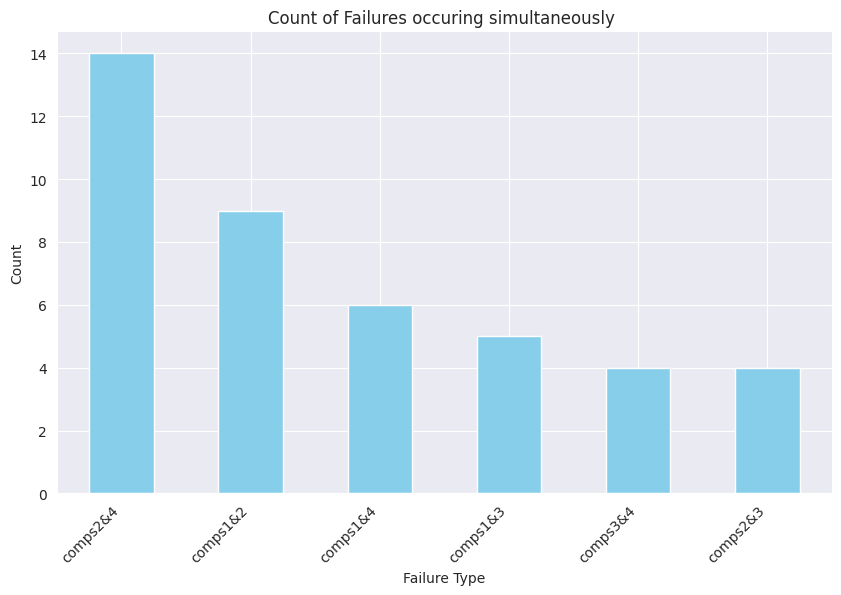

In [43]:
simultnus_failures = pd.DataFrame() # glogal DataFrame
# Combine simultaneous failure rows based on 'datetime' and 'machineID' with custom aggregation failures
# Add 6 more classes for the simultaneous component failures, as more than one component failed at the same time! 
# The logic behind this approach is that the same senor events that happen in history could impact simultaneous 
# components failing again in the future. 
def custom_agg(series):
    return 'comps' + '&'.join(series.str[4])

simultnus_failures = failures_duplicate_rows.groupby(['datetime', 'machineID'], as_index=False)['failure'].agg(custom_agg)

print(simultnus_failures)

# Count occurrences of each simultaneous failure type
failure_counts = simultnus_failures['failure'].value_counts()

# Plot the bar graph
failure_counts.plot(kind='bar', figsize=(10, 6),color='skyblue')
plt.title('Count of Failures occuring simultaneously ')
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()


<a class="anchor" id="Solution"></a>
## **Solution for simultaneous failure occurrences.**

In [44]:
# Create 4 empty dataframes as it may be possible for up to 4 components failing at the
# same time for a particular Machine. Each DF will store the set of simultaneous failure records
# eg. dup_dfs[0] - first , dup_dfs[1] - second set , dup_dfs[2] - third set
# dup_dfs[3] - fourth set

column_names = ['datetime', 'machineID', 'failure']
dup_dfs = [pd.DataFrame(columns=column_names) for _ in range(4)]

# Finds the set of duplicates and place them in dataframe based on there row index .
for index, row in failures_duplicate_rows.iterrows():
    # .sum(), it counts the number of True values in that Boolean Series.
    #  The > 1 condition checks whether the count of occurrences where the 'datetime' value is equal to row['datetime']
    #  and 'machineID' == row['machineID'] is greater than 1. If the count is greater than 1,
    #  it means there are at least two rows with the same 'datetime' value in the DataFrame.
    if ((failures['datetime'] == row['datetime']) & (failures['machineID'] == row['machineID'])).sum() > 1:
        indexes = failures[
            (failures['datetime'] == row['datetime']) & (failures['machineID'] == row['machineID'])].index

        for i, idx in enumerate(indexes):
            if idx not in dup_dfs[i].index:
                # converts the selected row into a DataFrame and transposes it to match the column structure.
                # ignore_index=False ensures the resulting DataFrame use the failure index.
                dup_dfs[i] = pd.concat([dup_dfs[i], failures.loc[idx, column_names].to_frame().T], ignore_index=False)
for df in dup_dfs:
    print(df)

               datetime machineID failure
0   2015-01-02 03:00:00        16   comp1
31  2015-01-07 06:00:00        12   comp1
57  2015-01-19 06:00:00        52   comp2
61  2015-01-20 06:00:00        15   comp2
72  2015-01-24 06:00:00         7   comp2
75  2015-01-24 06:00:00        97   comp3
78  2015-01-26 06:00:00        71   comp3
81  2015-01-28 06:00:00        63   comp1
91  2015-01-31 06:00:00        33   comp1
178 2015-03-19 06:00:00         2   comp1
190 2015-03-23 06:00:00        22   comp2
203 2015-04-01 06:00:00        17   comp2
237 2015-04-11 06:00:00        13   comp3
255 2015-04-20 06:00:00        11   comp2
258 2015-04-20 06:00:00        92   comp1
270 2015-04-30 06:00:00        98   comp2
310 2015-05-19 06:00:00        66   comp1
318 2015-05-22 06:00:00        22   comp1
339 2015-06-03 06:00:00        25   comp1
379 2015-06-24 06:00:00        32   comp2
389 2015-06-29 06:00:00        98   comp1
394 2015-07-01 06:00:00        16   comp2
424 2015-07-15 06:00:00        83 

In [45]:
# Get the indices of duplicate rows and drop duplicate records

failures_without_duplicates = failures
for i in range(1,4):
    if not dup_dfs[i].empty:
        failures_without_duplicates = failures_without_duplicates.drop(dup_dfs[i].index)

# Check the DataFrames
print("Failure records \n",failures.describe())
print("Failure without duplicates \n",failures_without_duplicates.describe())

Failure records 
                             datetime   machineID
count                            761  761.000000
mean   2015-06-24 12:12:17.976346880   51.911958
min              2015-01-02 03:00:00    1.000000
25%              2015-03-23 06:00:00   24.000000
50%              2015-06-24 06:00:00   51.000000
75%              2015-09-23 06:00:00   79.000000
max              2015-12-31 06:00:00  100.000000
std                              NaN   29.515542
Failure without duplicates 
                             datetime   machineID
count                            719  719.000000
mean   2015-06-24 11:32:12.684283648   52.349096
min              2015-01-02 03:00:00    1.000000
25%              2015-03-23 06:00:00   24.000000
50%              2015-06-23 06:00:00   52.000000
75%              2015-09-23 06:00:00   79.000000
max              2015-12-31 06:00:00  100.000000
std                              NaN   29.362194


In [46]:
def calc_acc_prec_recall(y_test,y_pred,label_encoder):
    # Calculate the accuracy, precision, recall, and f1-score on the testing data
    # Return the recall data as dataframe
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='weighted')
    recall = recall_score(y_test,y_pred, average='weighted')
    f1 = f1_score(y_test,y_pred,average='weighted')

    ''' Data irrelivant as 'none' data is large compared to component data
    print(f'Test set accuracy:\t{accuracy}')
    print(f'Test set precision:\t{precision}')
    print(f'Test set recall:\t{recall}')
    print(f'Test set f1-score:\t{f1}') '''

    # Print the confusion matrix
    class_labels = label_encoder.classes_  #["comp1", "comp2", "comp3", "comp4", "none"]
    test_conf_matrix = pd.DataFrame(
        confusion_matrix(y_test, y_pred,labels=class_labels),      index=class_labels,
        columns=class_labels )
    print(f'Confusion Matrix:\n{test_conf_matrix.to_string()}\n')


    # Create empty matrices to store precision and recall values
    precision_matrix = []
    recall_matrix = []

    for label in class_labels:
        # Calculate precision for the current class
        precision = precision_score(y_test, y_pred, labels=[label], average='weighted')

        # Calculate recall for the current class
        recall = recall_score(y_test, y_pred, labels=[label], average='weighted')

        # Append precision and recall values to their respective matrices
        precision_matrix.append([label, precision])
        recall_matrix.append([label, recall])

    # Create DataFrames to store precision and recall values
    precision_df = pd.DataFrame(precision_matrix, columns=["Class", "Precision"])
    recall_df = pd.DataFrame(recall_matrix, columns=["Class", "Recall"])

    # Print precision_df and recall_df
    print("Precision Matrix:")
    print("Precision = True Positives / (True Positives + False Positives)")
    print(precision_df)

    print("\nRecall Matrix:")
    print("Recall= True Positives / (True Positives + False Negatives)")
    print(recall_df)
    return recall_df


In [47]:
def create_labels(mach_feature,failures_without_duplicates,
                  dup_dfs,fill_hrs, laghrs, add_comps_fail_clf = True):
    # By default this funtion will add the components failures classification
    # This function returns labelled features based on the option of adding simultaneous components failure classification
    # or adding 10 days data from the first simultaneous component failure in the list.
    # Adding data was experimental as it would be the same as augmenting a 6 with a 9 in computer vision and expecting 
    # the ML algorithm to classify them.

    # Merge failures_without_duplicates using 'datetime'and 'machineID' which will create
    # nan for non existent failure row

    global simultnus_failures
    labeled_features = mach_feature.merge(failures_without_duplicates,
                                          on=['datetime', 'machineID'], how='left')
    # All records within a 'fill_hrs' hour window before a failure of component 1 have
    # `failure=comp1`, and so on for components 2, 3, and 4; all records not within
    # 'fill_hrs' hours of a component failure have `failure=none`
    limit = int(fill_hrs / laghrs) - 1
    # fill rows backward up to (laghrs * fill_hrs)
    labeled_features = labeled_features.fillna(method='bfill', limit=limit)
    #Simplify the simultaneous occurrence problem by using the simultaneous failure DF
    # to find and replace the first occurence with the combined failure of multiple individual failures.
    if add_comps_fail_clf: # If add components failure classification
        # Update labeled_features based on simultnus_failures
        merged_df = pd.merge(labeled_features[['datetime', 'machineID', 'failure']], simultnus_failures[['datetime', 'machineID', 'failure']], on=['datetime', 'machineID'], how='left', suffixes=('_labeled', '_simultnus'))
        # Backfill the failure column up to the limit
        merged_df['failure_labeled'] = merged_df.groupby('machineID')['failure_simultnus'].fillna(method='bfill', limit=limit).fillna(merged_df['failure_labeled'])
        # Update labeled_features with the backfilled failure values
        labeled_features['failure'] = merged_df['failure_labeled']
        labeled_features['failure'] = labeled_features['failure'].astype('str')
        labeled_features.replace({'nan': "none"}, inplace= True)
        return labeled_features
    else:
        # Merge duplicate files with mach_feature, backfill failure comp,
        # Remove unwanted machineID records, backfill "none" for 10 days and drop nan
        for i in range(1,4):
            if not dup_dfs[i].empty:
                df_temp = dup_dfs[i]
                df = mach_feature.merge(dup_dfs[i], on=['datetime', 'machineID'], how='left')
                df = df.fillna(method='bfill', limit=limit)
                # Get unique machineIDs from dup_dfs[i]
                unique_machineIDs = dup_dfs[i]['machineID'].unique()
                # Filter df to keep only records with machineID in df
                df = df[df['machineID'].isin(unique_machineIDs)]
                # Loop through DataFrame df and backfill failure column with "none" corresponding rows
                # in DataFrame dup_dfs[i] where df datetime <= 10 days dup_dfs[i] datetime
                # and corresponding machineID and value contain Nan
                ndays = 10
                for index, row in dup_dfs[i].iterrows():
                    df.loc[(df['datetime'] >= row['datetime'] - pd.to_timedelta(ndays, unit='D')) &
                      (df['datetime'] <= row['datetime']) &
                      (df['machineID'] == row['machineID']), 'failure'] = \
                    df.loc[(df['datetime'] >= row['datetime'] - pd.to_timedelta(ndays, unit='D')) &
                          (df['datetime'] <= row['datetime']) &
                          (df['machineID'] == row['machineID']), 'failure'].fillna("none")
                df.dropna(inplace= True)
                labeled_features = pd.concat([labeled_features,df],ignore_index=True)
    labeled_features['failure'] = labeled_features['failure'].astype('str')
    labeled_features.replace({'nan': "none"}, inplace= True)
    # Create a new column named 'row_number' containing row numbers starting from 0.
    # Then use this column for sorting:
    labeled_features['row_number'] = range(len(labeled_features))
    labeled_features.sort_values(by=["machineID", "row_number", "failure", "datetime"], inplace=True, ignore_index=True)
    # Drop the 'row_number' column as it is not needed anymore
    labeled_features.drop('row_number', axis=1, inplace=True)
    return labeled_features


In [48]:
labeled_features = create_labels(mach_feature,failures_without_duplicates,
                  dup_dfs,fill_hrs=24, laghrs=3)

In [49]:
labeled_features.describe()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,error1_sum_24,error2_sum_24,error3_sum_24,error4_sum_24,error5_sum_24,comp1,comp2,comp3,comp4,age
count,291300.00000,291300,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,...,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000
mean,50.50000,2015-07-03 06:00:00,170.771416,446.612973,100.855301,40.384328,158.071254,404.140202,92.378383,36.147281,...,0.027659,0.027075,0.022901,0.019907,0.009756,1280.417961,1231.655118,1260.290587,1286.858826,11.330000
min,1.00000,2015-01-02 06:00:00,125.532506,211.811184,72.118639,26.569635,97.333604,138.432075,51.237106,14.877054,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-03 06:00:00,164.445576,427.568132,96.238173,38.147839,150.363984,379.505260,86.862285,33.457488,...,0.000000,0.000000,0.000000,0.000000,0.000000,318.000000,288.000000,312.000000,309.000000,6.750000
50%,50.50000,2015-07-03 06:00:00,170.430790,448.385564,100.233139,40.146085,158.162633,406.887414,92.115722,36.088251,...,0.000000,0.000000,0.000000,0.000000,0.000000,783.000000,708.000000,771.000000,777.000000,12.000000
75%,75.25000,2015-10-02 06:00:00,176.607051,468.447680,104.404520,42.227392,165.835015,432.057742,97.273981,38.666539,...,0.000000,0.000000,0.000000,0.000000,0.000000,1644.000000,1590.000000,1608.000000,1683.000000,16.000000
max,100.00000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,235.726785,565.962115,160.026994,68.001841,...,2.000000,2.000000,2.000000,2.000000,2.000000,11805.000000,8373.000000,8901.000000,9477.000000,20.000000
std,28.86612,NaN,9.497201,33.122865,7.408854,3.476641,11.871003,40.811111,8.775150,4.206936,...,0.166301,0.164446,0.151435,0.140832,0.098813,1498.033522,1419.377832,1410.381699,1430.565253,5.827625


In [50]:
# Test with 2 simultaneous failure for machine Id = 2 : 8 records with comp1&2, 8 'none' records before
# comp1&2 records also shown
labeled_features[
    #(labeled_features['failure'] == 'comp1') &  # Filtering for 'failure' column with value 'compX'
    (labeled_features['machineID'] == 2) &     # Filtering for 'machineID' column with value y
    (labeled_features['datetime'] > pd.to_datetime('2015-03-17 06:00:00')) &
    (labeled_features['datetime'] <= pd.to_datetime('2015-03-19 06:00:00'))
]

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,error3_sum_24,error4_sum_24,error5_sum_24,comp1,comp2,comp3,comp4,model,age,failure
3506,2,2015-03-17 09:00:00,191.877454,371.051731,96.072228,41.693572,175.643659,321.623599,84.842255,36.297268,...,0.0,0.0,0.0,6579.0,5139.0,675.0,315.0,model4,7,none
3507,2,2015-03-17 12:00:00,182.461251,373.972592,104.486993,43.968925,161.932600,327.363472,97.749591,40.654986,...,0.0,0.0,0.0,6582.0,5142.0,678.0,318.0,model4,7,none
3508,2,2015-03-17 15:00:00,205.910271,403.503659,99.287823,44.496410,189.319913,381.315999,85.973884,36.071818,...,0.0,0.0,0.0,6585.0,5145.0,681.0,321.0,model4,7,none
3509,2,2015-03-17 18:00:00,187.751919,324.751326,98.862119,37.582892,183.855583,291.094371,89.866327,31.769829,...,0.0,0.0,0.0,6588.0,5148.0,684.0,324.0,model4,7,none
3510,2,2015-03-17 21:00:00,188.363340,361.730218,98.875875,43.860186,172.908211,276.151681,81.848081,39.607366,...,0.0,0.0,0.0,6591.0,5151.0,687.0,327.0,model4,7,none
3511,2,2015-03-18 00:00:00,186.215722,382.312640,97.758428,41.153953,168.768124,353.252636,93.232983,35.790437,...,0.0,0.0,0.0,6594.0,5154.0,690.0,330.0,model4,7,none
3512,2,2015-03-18 03:00:00,180.622299,385.595525,99.502679,42.897261,175.457844,365.631041,96.863519,39.589868,...,0.0,0.0,0.0,6597.0,5157.0,693.0,333.0,model4,7,none
3513,2,2015-03-18 06:00:00,198.964800,354.151424,96.583189,42.471818,174.788266,335.065946,87.934106,40.728454,...,0.0,0.0,0.0,6600.0,5160.0,696.0,336.0,model4,7,none
3514,2,2015-03-18 09:00:00,175.471523,382.521159,93.885594,38.319541,168.448450,310.368039,89.573491,34.848273,...,1.0,0.0,0.0,6603.0,5163.0,699.0,339.0,model4,7,comps1&2
3515,2,2015-03-18 12:00:00,205.271773,340.915117,101.364846,43.819837,199.889985,326.882539,99.880972,42.522563,...,1.0,0.0,0.0,6606.0,5166.0,702.0,342.0,model4,7,comps1&2


In [51]:
# Test with 2 simultaneous failures for machine Id = 17 : 8 records with comp3&4, 8 'none' records before
# comp3&4 records also shown
labeled_features[
    #(labeled_features['failure'] == 'comp1') &  # Filtering for 'failure' column with value 'compX'
    (labeled_features['machineID'] == 17) &     # Filtering for 'machineID' column with value Y
    (labeled_features['datetime'] > pd.to_datetime('2015-10-26 06:00:00')) &   # Lower bound
    (labeled_features['datetime'] <= pd.to_datetime('2015-10-28 06:00:00'))    # Upper bound
]

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,error3_sum_24,error4_sum_24,error5_sum_24,comp1,comp2,comp3,comp4,model,age,failure
48985,17,2015-10-26 09:00:00,168.194304,501.167857,129.861505,50.153154,159.385809,464.546579,124.960200,45.539960,...,0.0,0.0,0.0,2115.0,1035.0,3195.0,1395.0,model1,14,none
48986,17,2015-10-26 12:00:00,180.611652,411.941648,127.245140,52.224550,165.321757,388.342292,110.003039,49.210601,...,0.0,0.0,0.0,2118.0,1038.0,3198.0,1398.0,model1,14,none
48987,17,2015-10-26 15:00:00,175.484229,409.358671,131.770712,52.600060,168.035734,349.443943,124.398979,44.117819,...,0.0,0.0,0.0,2121.0,1041.0,3201.0,1401.0,model1,14,none
48988,17,2015-10-26 18:00:00,170.428006,487.819328,121.006920,47.426087,159.255661,422.443915,109.325247,45.888021,...,0.0,0.0,0.0,2124.0,1044.0,3204.0,1404.0,model1,14,none
48989,17,2015-10-26 21:00:00,167.737593,443.481252,133.857716,51.667761,147.541790,415.467278,127.660777,46.929574,...,0.0,0.0,0.0,2127.0,1047.0,3207.0,1407.0,model1,14,none
48990,17,2015-10-27 00:00:00,166.366559,475.163394,128.627330,51.982538,148.650090,427.859471,122.895321,46.945474,...,0.0,0.0,0.0,2130.0,1050.0,3210.0,1410.0,model1,14,none
48991,17,2015-10-27 03:00:00,169.990718,448.519716,125.496285,49.060416,149.025722,386.170539,122.280635,45.097405,...,0.0,0.0,0.0,2133.0,1053.0,3213.0,1413.0,model1,14,none
48992,17,2015-10-27 06:00:00,179.604866,457.901175,125.888057,45.482963,167.046823,326.818194,121.586018,43.025032,...,0.0,0.0,0.0,2136.0,1056.0,3216.0,1416.0,model1,14,none
48993,17,2015-10-27 09:00:00,145.896049,456.012784,119.443762,50.900326,136.499787,425.578678,116.259482,46.773385,...,0.0,1.0,1.0,2139.0,1059.0,3219.0,1419.0,model1,14,comps3&4
48994,17,2015-10-27 12:00:00,160.912518,380.508664,122.816294,48.414517,154.898422,341.210119,115.932189,47.761379,...,0.0,1.0,1.0,2142.0,1062.0,3222.0,1422.0,model1,14,comps3&4


In [52]:
X = labeled_features.drop(labels=['datetime', 'machineID', 'failure'], axis=1)
X = pd.get_dummies(X) # Create dummies for mode numbers
print(X.head())
labeled_features['failure']=labeled_features['failure'].astype("category")
y =labeled_features['failure']

   volt_mean_3h  rotate_mean_3h  pressure_mean_3h  vibration_mean_3h  \
0    180.133784      440.608320         94.137969          41.551544   
1    176.364293      439.349655        101.553209          36.105580   
2    160.384568      424.385316         99.598722          36.094637   
3    170.472461      442.933997        102.380586          40.483002   
4    163.263806      468.937558        102.726648          40.921802   

   volt_min_3h  rotate_min_3h  pressure_min_3h  vibration_min_3h  volt_max_3h  \
0   158.271400     403.235951        92.439132         32.516838   200.872430   
1   160.528861     384.645962        86.944273         29.527665   197.363125   
2   147.300678     412.965696        90.711354         34.203042   173.394523   
3   152.420775     385.354924        99.506819         30.665184   185.205355   
4   145.248486     424.542633        93.743827         37.422272   180.030715   

   rotate_max_3h  ...  error5_sum_24  comp1   comp2   comp3   comp4  age  \
0   

<a class="anchor" id="Model"></a>
## Modelling

### **Functions**

In [53]:
def feature_importance_plot(X,x_cfl):
    # The feature_importances_ attribute is specific to tree-based models in scikit-learn,
    # like decision trees, random forests, or gradient boosting machines (GBMs).
    # It is an attribute that measures the importance of each feature in predicting the target variable.
    sns.set_style("darkgrid")
    plt.figure(figsize=(10, 6))
    #https://stackoverflow.com/questions/8966538/syntax-behind-sortedkey-lambda
    #https://realpython.com/python-zip-function/--->operator * to unzip the data
    labels, importances = zip(*sorted(zip(X.columns, x_cfl.feature_importances_),
                                      reverse=True, key=lambda x: x[1]))

    # print(len(labels), len(importances))
    plt.xticks(range(len(labels)), labels)
    _, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    plt.bar(range(len(importances)), importances)
    plt.ylabel('Importance', fontsize=14)
    plt.xlabel("Feature name", fontsize=14)
    plt.title("Feature Importance Plot")
    plt.show()

In [54]:
tscv = 3 # TimeSeriesSplit(n_splits=3) XGboost has problem when cv train data not in test

In [55]:
%%time
# Test version
def grid_search_pipelineTest(X_train, yn_train): #Test

    # Create a pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Add StandardScaler before classifier
        ('clfr', RandomForestClassifier())
    ])

    # Define the parameter grid
    param_grid = [
            {
            'clfr': [Pipeline([
                ('scaler', StandardScaler()),  # Add StandardScaler before classifier
                ('lsvc', LinearSVC(tol=1e-5, class_weight='balanced'))])],
            'clfr__lsvc__C': [1], # 10, 100], #[1, 10, 100]
                            #'clfr__clfr__penalty': ['l1', 'l2']
            'clfr__lsvc__loss':['hinge'], #'squared_hinge'],
            'clfr__lsvc__intercept_scaling':[10] #, 100]
        }, #] #,
        #{
        #    'clfr': [RandomForestClassifier()],
        #    'clfr__n_estimators': [50, 100], #[10, 50, 100]
        #    'clfr__max_depth': [5, 10, 20] #[5, 10, 20]
        #},
        #{
        #    'clfr': [HistGradientBoostingClassifier()],
        #    'clfr__max_iter': [100, 300, 500], #[300, 500]
        #    'clfr__learning_rate': [0.1, 0.5, 1], #[0.1, 0.5, 1]
        #    'clfr__max_depth': [5, 10, 20] #[5, 10, 20]
        #},
        {
            'clfr': [XGBClassifier(enable_categorical=True)],
        #    'clfr__n_estimators':[500, 1000], #[500, 1000],
        #    'clfr__learning_rate': [0.1, 0.15, 0.2],   # [0.1, 0.15, 0.2]
            'clfr__max_depth': [3] #, 6]              #[3, 5, 10]
        }
    ]

    # Create GridSearchCV object
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=tscv, verbose=0, n_jobs=-1)

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, yn_train)

    # Get the best estimator
    best_estimator = grid_search.best_estimator_
    return grid_search

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.3 µs


In [56]:
%%time

def grid_search_pipeline(X_train, yn_train):  #Prod

    # Create a pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Add StandardScaler before classifier
        ('clfr', RandomForestClassifier())
    ])

    # Define the parameter grid
    param_grid = [
            {
            'clfr': [Pipeline([
                ('scaler', StandardScaler()),  # Add StandardScaler before classifier
                ('lsvc', LinearSVC(tol=1e-5, class_weight='balanced'))])],
            'clfr__lsvc__C': [1, 10, 100],
                            #'clfr__clfr__penalty': ['l1', 'l2']
            'clfr__lsvc__loss':['hinge', 'squared_hinge'],
            'clfr__lsvc__intercept_scaling':[1,10, 100]
        },
        {
            'clfr': [RandomForestClassifier()],
            'clfr__n_estimators': [50, 100],
            'clfr__max_depth': [5, 10, 20]
        },
        {
            'clfr': [HistGradientBoostingClassifier()],
            'clfr__max_iter': [100, 300, 500],
            'clfr__learning_rate': [0.1, 0.5, 1],
            'clfr__max_depth': [5, 10, 20]
        },
        {
            'clfr': [XGBClassifier()],
            'clfr__n_estimators':[500, 1000],
            'clfr__learning_rate': [0.1, 0.15, 0.2],
            'clfr__max_depth': [3, 6]
        }
    ]

    # Create GridSearchCV object
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=tscv, verbose=0, n_jobs=-1)

    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, yn_train)

    # Get the best estimator
    best_estimator = grid_search.best_estimator_
    return grid_search

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs


In [57]:
# Create a Pretty table that will show the best scores for each in the GridSearchCV pipeline
# using grid_search.cv_results_
# Changed from Pretty table to Dataframe as DF are easier to work with in this project
def create_pretty_table(grid_search,pred):

    table = PrettyTable()
    table.field_names = ["Pred","Classifier", "Rank", "Mean Score","Parameters"]

    #list_of_params = [p.pop('clfr', None) for p in grid_search.cv_results_['params']]
    list_of_params =grid_search.cv_results_['params']
    # Iterate through the list and remove 'clfr' key
    for p in list_of_params:
        p.pop('clfr', None)
    list_of_param_data = grid_search.cv_results_['param_clfr'].data
    # Extract the model name and appending it to list_of_clfr. '('is after every model name
    list_of_clfr = [re.search(r'\b\w+\(', str(c)).group(0)[:-1] for c in list_of_param_data]
    # Format mean_test_score to 4 decimal places
    formatted_mean_test_score = [round(num, 4) for num in grid_search.cv_results_['mean_test_score']]
    #formatted_mean_test_score = ['{:.4f}'.format(num) for num in grid_search.cv_results_['mean_test_score']]
    class_list=list(zip([pred]*len(grid_search.cv_results_['params']),
                                   list_of_clfr,
                                   grid_search.cv_results_['rank_test_score'],
                                   formatted_mean_test_score, #grid_search.cv_results_['mean_test_score'],
                                   list_of_params
                                  ))
    # Sort the list of tuples based on the rank_test_score and mean_test_score items
    sorted_data = sorted(class_list, key=lambda x: (x[2], x[3]))

    # Extract unique values from the classifier column
    unique_estimators = set(item[1] for item in sorted_data)

    # Find the first tuple in sorted_data matching each unique_estimator
    first_matching_tuples = []

    for estimator in unique_estimators:
        matching_tuple = next(item for item in sorted_data if item[1] == estimator)
        first_matching_tuples.append(matching_tuple)

    for row in first_matching_tuples:
        table.add_row(row)

    df = pd.DataFrame(first_matching_tuples,columns= ["Pred/lag hour","Classifier", "Rank", "Mean","Parameters"] )
    # set the maximum column width
    pd.set_option('display.max_colwidth', None)

    table.sortby = "Rank"

    # Print the PrettyTable
    #print(table)
    #display(table)
    display(df.sort_values(["Rank"]))
    return df


In [58]:
%%time
def random_search_pipeline(X_train, y_train): #Prod
    # Use XGBoost as it outperformed other classifiers in 24 hour prediction model and DF structure similar
    x_cfl=XGBClassifier()

    # Define the parameter grid
    param_grid =  {
            'n_estimators':[100, 500, 1000],
            'learning_rate': [0.1, 0.15, 0.2],
            'max_depth': [3, 6, 10],
            'colsample_bytree':[0.1, 0.3,0.5,1],
            'subsample':[0.1, 0.3,0.5,1]
        }

    # Create RandomizedSearchCV object
    random_search = RandomizedSearchCV(x_cfl, param_distributions=param_grid, cv=tscv, n_iter=10, verbose=0, n_jobs=-1)

    # Fit the RandomizedSearchCV object to the data
    random_search.fit(X_train, y_train)

    # Get the best estimator
    best_estimator = random_search.best_estimator_
    return random_search

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.54 µs


In [59]:
%%time
def random_search_pipelineTest(X_train, y_train): #Test
    # Use XGBoost as it outperformed other classifiers in 24 hour prediction model
    x_cfl=XGBClassifier()

    # Define the parameter grid
    param_grid =  {
            'n_estimators':[100], #[500, 1000],
            'learning_rate': [0.1], # 0.15, 0.2],   # [0.1, 0.5, 1]
            'max_depth': [3], # 6, 10],              #[5, 10, 20]
            'colsample_bytree':[0.1], #0.3,0.5,1],
            'subsample':[0.1] #,0.3,0.5,1]
        }

    # Create RandomizedSearchCV object
    random_search = RandomizedSearchCV(x_cfl, param_distributions=param_grid, cv=tscv, n_iter=10, verbose=0, n_jobs=-1)

    # Fit the RandomizedSearchCV object to the data
    random_search.fit(X_train, y_train)

    # Get the best estimator
    best_estimator = random_search.best_estimator_
    return random_search

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 9.3 µs


In [60]:
def telemetry_shift_columns(telemetry_mean, pred_hours):
    # Drop 'machineID' and 'datetime' as they must not be in shifted columns
    telemetry_mean_only = telemetry_mean.drop(labels=['machineID','datetime'], axis=1)

    # Shift columns and store them in a list, rename the columns of each shifted DataFrame generated
    # Example for 24 hours use
    # 24, 18 .. 3 hours by adding suffixes like "_24", "_18",and so on, corresponding to the number
    # calculated based on the iteration. This assumes lag 3 hour averages
    shifted_columns = [telemetry_mean_only.shift(i).add_suffix("_"+str(i * 3 + 3))
                       for i in range(int(pred_hours/3)-1, -1, -1)]
    # Concatenate the shifted columns along the columns (axis=1)
    telemetry_mean_Shift = pd.concat(shifted_columns, axis=1)
    # Concatenate the telemetry mean datetime and machineID to telemetry_feat_mean_Shift24 and dropna
    return pd.concat([telemetry_mean.iloc[:,:2],telemetry_mean_Shift],axis=1).dropna()

<a class="anchor" id="Model24_lag3"></a>
<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Model for 24 hour prediction with 3 hour lag</h2>
</div>


In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, shuffle=False)

Epoch 1/200
911/911 [==============================] - 55s 59ms/step - loss: 0.1255 - accuracy: 0.9742 - val_loss: 0.0133 - val_accuracy: 0.9985
Epoch 2/200
911/911 [==============================] - 53s 59ms/step - loss: 0.0118 - accuracy: 0.9973 - val_loss: 0.0112 - val_accuracy: 0.9985
Epoch 3/200
911/911 [==============================] - 53s 59ms/step - loss: 0.0084 - accuracy: 0.9981 - val_loss: 0.0111 - val_accuracy: 0.9984
Epoch 4/200
911/911 [==============================] - 53s 59ms/step - loss: 0.0067 - accuracy: 0.9983 - val_loss: 0.0099 - val_accuracy: 0.9985
Epoch 5/200
911/911 [==============================] - 54s 59ms/step - loss: 0.0060 - accuracy: 0.9984 - val_loss: 0.0087 - val_accuracy: 0.9986
Epoch 6/200
911/911 [==============================] - 54s 59ms/step - loss: 0.0054 - accuracy: 0.9986 - val_loss: 0.0074 - val_accuracy: 0.9986
Epoch 7/200
911/911 [==============================] - 53s 58ms/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.0104 - val_ac

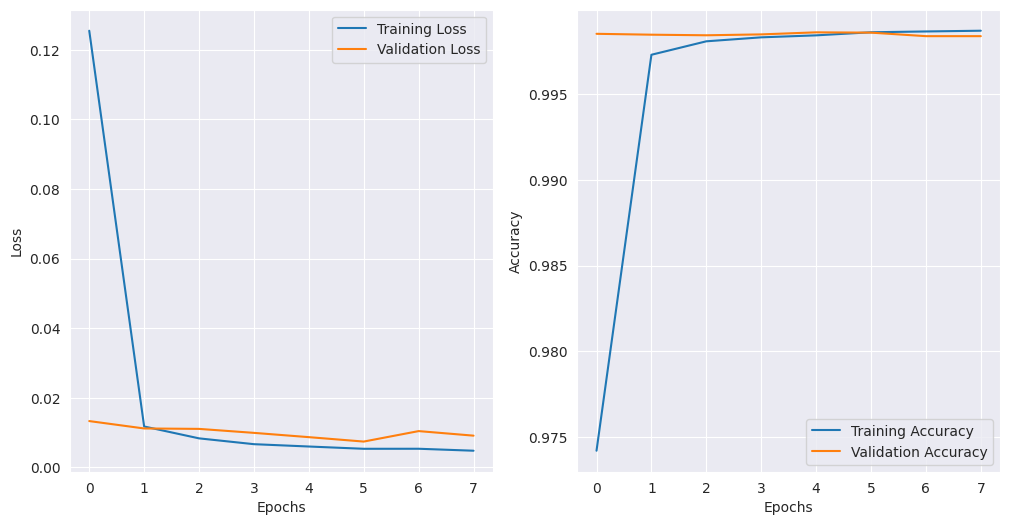

1821/1821 [==============================] - 9s 5ms/step - loss: 0.0074 - accuracy: 0.9986
Confusion Matrix:
          comp1  comp2  comp3  comp4  comps1&2  comps1&3  comps1&4  comps2&3  comps2&4  comps3&4   none
comp1       262      0      0      0         0         0         0         0         0         0     11
comp2         0    400      0      0         0         0         0         0         0         0      0
comp3         0      0    318      0         0         0         0         0         0         0      2
comp4         0      0      0    222         0         0         0         0         2         0      0
comps1&2      0      0      0      0        16         0         0         0         0         0      0
comps1&3      1      0      0      0         0         7         0         0         0         0      0
comps1&4      0      0      0      0         0         0        16         0         0         0      0
comps2&3      0      0      0      0         0         0   

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.



Precision Matrix:
Precision = True Positives / (True Positives + False Positives)
       Class  Precision
0      comp1   0.856209
1      comp2   0.995025
2      comp3   0.963636
3      comp4   0.961039
4   comps1&2   1.000000
5   comps1&3   1.000000
6   comps1&4   1.000000
7   comps2&3   0.000000
8   comps2&4   0.941176
9   comps3&4   1.000000
10      none   0.999772

Recall Matrix:
Recall= True Positives / (True Positives + False Negatives)
       Class    Recall
0      comp1  0.959707
1      comp2  1.000000
2      comp3  0.993750
3      comp4  0.991071
4   comps1&2  1.000000
5   comps1&3  0.875000
6   comps1&4  1.000000
7   comps2&3  0.000000
8   comps2&4  1.000000
9   comps3&4  1.000000
10      none  0.998841


In [62]:
label_encoder = LabelEncoder()
label_encoder.fit(y)
yn_train = label_encoder.transform(y_train)
yn_test = label_encoder.transform(y_test)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import layers, callbacks
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Set random seeds for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
#tf.config.threading.set_intra_op_parallelism_threads(1)
#tf.config.threading.set_inter_op_parallelism_threads(1)
tf.keras.backend.set_floatx('float32')

# X_train, X_test, yn_train, yn_test are training and testing data

scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=2, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Build the model
model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))  # len(label_encoder.classes_) categories

# Compile the model
model.compile(optimizer='rmsprop', #'adam', #
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, yn_train, epochs=200, batch_size=256, 
                    callbacks=[early_stopping],validation_data=(X_test_scaled, yn_test))

# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluate the model on the test set
y_pred_probabilities = model.predict(X_test_scaled)
yn_pred = np.argmax(y_pred_probabilities, axis=1)

y_pred = label_encoder.inverse_transform(yn_pred)

loss, accuracy = model.evaluate(X_test_scaled, yn_test)
modelTF24_3hr = calc_acc_prec_recall(y_test,y_pred,label_encoder)


In [63]:
tableTF24_3hr = pd.DataFrame(["24hr 3hr","TensorFlow","0",round(accuracy,4),"3 Dense Layer 1024, Drop .5, BatchNorm, batch_size=256"]).T
tableTF24_3hr.columns = ["Pred/lag hour","Classifier", "Rank", "Mean","Parameters"]
print(tableTF24_3hr)

  Pred/lag hour  Classifier Rank    Mean  \
0      24hr 3hr  TensorFlow    0  0.9986   

                                          Parameters  
0  3 Dense Layer 1024, Drop .5, BatchNorm, batch_...  


In [64]:
label_encoder = LabelEncoder()
label_encoder.fit(y)
yn_train = label_encoder.fit_transform(y_train)
grid_search = grid_search_pipeline(X_train, yn_train)


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

In [65]:
best_estimator = grid_search.best_estimator_
yn_pred = best_estimator.predict(X_test)
y_pred = label_encoder.inverse_transform(yn_pred)
model24_3hr = calc_acc_prec_recall(y_test,y_pred,label_encoder)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Confusion Matrix:
          comp1  comp2  comp3  comp4  comps1&2  comps1&3  comps1&4  comps2&3  comps2&4  comps3&4   none
comp1       272      0      0      0         0         0         0         0         0         0      1
comp2         0    400      0      0         0         0         0         0         0         0      0
comp3         0      0    320      0         0         0         0         0         0         0      0
comp4         0      0      0    224         0         0         0         0         0         0      0
comps1&2      0      0      0      0        16         0         0         0         0         0      0
comps1&3      0      0      0      0         0         8         0         0         0         0      0
comps1&4      0      0      0      0         0         0        16         0         0         0      0
comps2&3      0      0      0      0         0         0         0         0         0         0      0
comps2&4      0      0      0      0         0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Precision Matrix:
Precision = True Positives / (True Positives + False Positives)
       Class  Precision
0      comp1   0.957746
1      comp2   1.000000
2      comp3   0.946746
3      comp4   0.978166
4   comps1&2   1.000000
5   comps1&3   1.000000
6   comps1&4   1.000000
7   comps2&3   0.000000
8   comps2&4   1.000000
9   comps3&4   0.000000
10      none   0.999982

Recall Matrix:
Recall= True Positives / (True Positives + False Negatives)
       Class    Recall
0      comp1  0.996337
1      comp2  1.000000
2      comp3  1.000000
3      comp4  1.000000
4   comps1&2  1.000000
5   comps1&3  1.000000
6   comps1&4  1.000000
7   comps2&3  0.000000
8   comps2&4  1.000000
9   comps3&4  0.000000
10      none  0.999526


In [66]:
table24_3hr = create_pretty_table(grid_search,"24hr 3hr")

,Pred/lag hour,Classifier,Rank,Mean,Parameters
1,24hr 3hr,XGBClassifier,1,0.9993,"{'clfr__learning_rate': 0.2, 'clfr__max_depth': 3, 'clfr__n_estimators': 1000}"
2,24hr 3hr,RandomForestClassifier,13,0.9991,"{'clfr__max_depth': 20, 'clfr__n_estimators': 50}"
3,24hr 3hr,Pipeline,17,0.9975,"{'clfr__lsvc__C': 100, 'clfr__lsvc__intercept_scaling': 100, 'clfr__lsvc__loss': 'hinge'}"
0,24hr 3hr,HistGradientBoostingClassifier,37,0.9862,"{'clfr__learning_rate': 0.1, 'clfr__max_depth': 5, 'clfr__max_iter': 100}"


Table above shows XGBClassifier has out performed other classifiers. The second best was RandomForestClassifier at **13th** position.  

In [67]:
grid_search.best_estimator_.named_steps.clfr

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

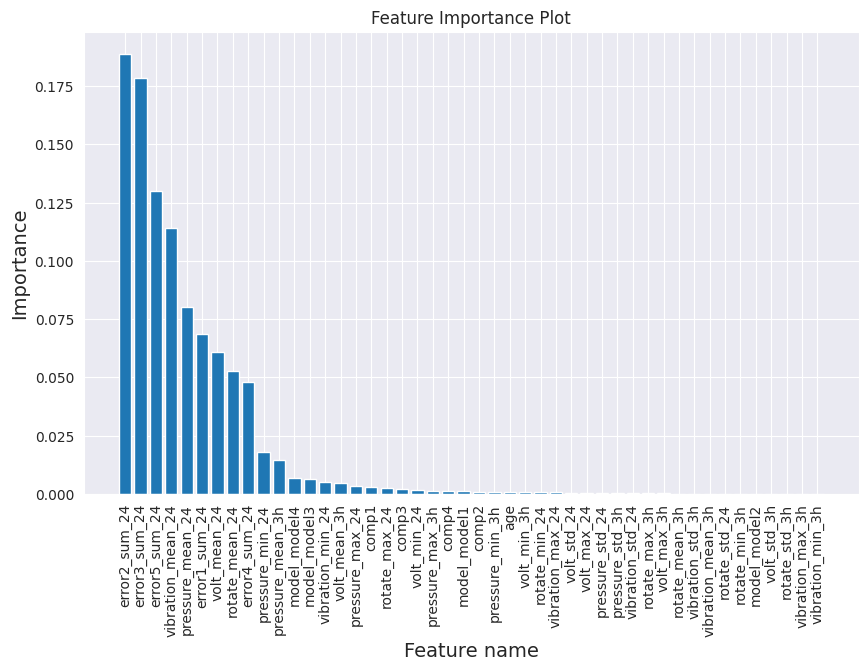

In [68]:
feature_importance_plot(X_test,best_estimator.named_steps.clfr)

<a class="anchor" id="Model48_lag3"></a>
<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Modify Features and Model for 36 hour prediction with 3 hour lag</h2>
</div>

In [69]:
aggrs = ['sum']  # aggregate list that will be added to features
features = ['error%d' % i for i in range(1,6)] # feature list
rule = '3H'
window = 36
error_count36 =roll_resample_feat_rule(error_count, features, window, rule, aggrs)
error_count36.describe()

,machineID,datetime,error1_sum_36,error2_sum_36,error3_sum_36,error4_sum_36,error5_sum_36
count,291000.00000,291000,291000.000000,291000.000000,291000.000000,291000.000000,291000.000000
mean,50.50000,2015-07-03 13:30:00,0.041460,0.040632,0.034375,0.029883,0.014639
min,1.00000,2015-01-02 18:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-03 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,2015-07-03 13:30:00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,2015-10-02 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2016-01-01 09:00:00,3.000000,3.000000,2.000000,2.000000,2.000000
std,28.86612,NaN,0.203583,0.201384,0.185572,0.172670,0.121158


In [70]:
aggrs = ['mean','min','max','std']  # aggregate list that will be added to features
features = ['volt', 'rotate', 'pressure', 'vibration'] # feature list
rule = '3H'
window = 36
# Calculate "resample 'min', 'max', 'mean', or 'median' values" over the last 3 hour lag window
# for telemetry features and merge with
# Calculation of "rolling resample 'min', 'max', 'mean', or 'std' values" over the last 48 hour lag window
# for telemetry features 'fields'.
telemetry_lagfeat36 = pd.concat([resample_feat_rule(telemetry, features, rule, aggrs),
                            roll_resample_feat_rule(telemetry, features, window, rule, aggrs).iloc[:, 2:]], axis=1).dropna()
telemetry_lagfeat36.describe()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,pressure_min_36,vibration_min_36,volt_max_36,rotate_max_36,pressure_max_36,vibration_max_36,volt_std_36,rotate_std_36,pressure_std_36,vibration_std_36
count,290900.00000,290900,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,...,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000
mean,50.50000,2015-07-03 11:59:59.999999744,170.770402,446.614184,100.855630,40.383867,158.071617,404.137542,92.378544,36.146722,...,79.287712,29.636661,202.833815,553.932780,122.480798,51.132397,15.012640,50.326747,10.154410,5.047178
min,1.00000,2015-01-02 18:00:00,125.532506,211.811184,72.118639,26.569635,97.333604,138.432075,51.237106,14.877054,...,51.237106,14.877054,177.256266,382.463943,105.936145,42.712577,7.454227,24.855348,5.270463,2.468431
25%,25.75000,2015-04-03 15:00:00,164.445234,427.566419,96.238973,38.147603,150.362956,379.503427,86.862810,33.457012,...,76.042094,28.025494,196.988682,537.391765,117.979216,48.997837,13.722963,45.890681,9.163085,4.582371
50%,50.50000,2015-07-03 12:00:00,170.429431,448.383875,100.233708,40.146085,158.162492,406.878892,92.115826,36.087767,...,79.455155,29.744150,201.684540,552.758809,121.084517,50.573249,14.950240,49.953212,9.985538,4.991675
75%,75.25000,2015-10-02 09:00:00,176.605880,468.443750,104.404619,42.226913,165.836199,432.056308,97.273981,38.665955,...,82.514367,31.263788,207.324425,569.741218,124.911112,52.473445,16.223857,54.277589,10.866538,5.429909
max,100.00000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,235.726785,565.962115,160.026994,68.001841,...,135.404951,52.083159,255.124717,695.020984,185.951998,76.791072,29.519754,108.878086,29.121590,11.748784
std,28.86612,NaN,9.496675,33.120920,7.408224,3.475758,11.870818,40.811970,8.774943,4.206183,...,5.688847,2.731441,8.451941,26.638748,7.222148,3.252850,1.883028,6.557852,1.594739,0.706352


In [71]:
telemetry_lagfeat36.columns.tolist()

['machineID',
 'datetime',
 'volt_mean_3h',
 'rotate_mean_3h',
 'pressure_mean_3h',
 'vibration_mean_3h',
 'volt_min_3h',
 'rotate_min_3h',
 'pressure_min_3h',
 'vibration_min_3h',
 'volt_max_3h',
 'rotate_max_3h',
 'pressure_max_3h',
 'vibration_max_3h',
 'volt_std_3h',
 'rotate_std_3h',
 'pressure_std_3h',
 'vibration_std_3h',
 'volt_mean_36',
 'rotate_mean_36',
 'pressure_mean_36',
 'vibration_mean_36',
 'volt_min_36',
 'rotate_min_36',
 'pressure_min_36',
 'vibration_min_36',
 'volt_max_36',
 'rotate_max_36',
 'pressure_max_36',
 'vibration_max_36',
 'volt_std_36',
 'rotate_std_36',
 'pressure_std_36',
 'vibration_std_36']

<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Merge all the 36 hour lag feature with telemetry data sets</h2>

In [72]:
mach_feature36 = telemetry_lagfeat36.merge(error_count36, on=['datetime', 'machineID'], how='left')
mach_feature36 = mach_feature36.merge(comp_dum, on=['datetime', 'machineID'], how='left')
mach_feature36 = mach_feature36.merge(machines, on=['machineID'], how='left')
mach_feature36.describe()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,error1_sum_36,error2_sum_36,error3_sum_36,error4_sum_36,error5_sum_36,comp1,comp2,comp3,comp4,age
count,290900.00000,290900,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,...,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000
mean,50.50000,2015-07-03 11:59:59.999999744,170.770402,446.614184,100.855630,40.383867,158.071617,404.137542,92.378544,36.146722,...,0.041475,0.040643,0.034369,0.029887,0.014644,1279.014534,1229.535180,1258.353909,1284.771894,11.330000
min,1.00000,2015-01-02 18:00:00,125.532506,211.811184,72.118639,26.569635,97.333604,138.432075,51.237106,14.877054,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-03 15:00:00,164.445234,427.566419,96.238973,38.147603,150.362956,379.503427,86.862810,33.457012,...,0.000000,0.000000,0.000000,0.000000,0.000000,318.000000,288.000000,312.000000,309.000000,6.750000
50%,50.50000,2015-07-03 12:00:00,170.429431,448.383875,100.233708,40.146085,158.162492,406.878892,92.115826,36.087767,...,0.000000,0.000000,0.000000,0.000000,0.000000,783.000000,708.000000,768.000000,774.000000,12.000000
75%,75.25000,2015-10-02 09:00:00,176.605880,468.443750,104.404619,42.226913,165.836199,432.056308,97.273981,38.665955,...,0.000000,0.000000,0.000000,0.000000,0.000000,1641.000000,1587.000000,1605.000000,1677.000000,16.000000
max,100.00000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,235.726785,565.962115,160.026994,68.001841,...,3.000000,3.000000,2.000000,2.000000,2.000000,11805.000000,8373.000000,8901.000000,9477.000000,20.000000
std,28.86612,NaN,9.496675,33.120920,7.408224,3.475758,11.870818,40.811970,8.774943,4.206183,...,0.203617,0.201409,0.185560,0.172680,0.121178,1497.225769,1417.866999,1409.141885,1429.354189,5.827625


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Create Labels for 36 hours prediction</h2>



</div>

In [73]:
labeled_features36 = create_labels(mach_feature36,failures_without_duplicates,
                  dup_dfs,fill_hrs=36, laghrs=3)

In [74]:
labeled_features36.describe()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,error1_sum_36,error2_sum_36,error3_sum_36,error4_sum_36,error5_sum_36,comp1,comp2,comp3,comp4,age
count,290900.00000,290900,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,...,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000,290900.000000
mean,50.50000,2015-07-03 11:59:59.999999744,170.770402,446.614184,100.855630,40.383867,158.071617,404.137542,92.378544,36.146722,...,0.041475,0.040643,0.034369,0.029887,0.014644,1279.014534,1229.535180,1258.353909,1284.771894,11.330000
min,1.00000,2015-01-02 18:00:00,125.532506,211.811184,72.118639,26.569635,97.333604,138.432075,51.237106,14.877054,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-03 15:00:00,164.445234,427.566419,96.238973,38.147603,150.362956,379.503427,86.862810,33.457012,...,0.000000,0.000000,0.000000,0.000000,0.000000,318.000000,288.000000,312.000000,309.000000,6.750000
50%,50.50000,2015-07-03 12:00:00,170.429431,448.383875,100.233708,40.146085,158.162492,406.878892,92.115826,36.087767,...,0.000000,0.000000,0.000000,0.000000,0.000000,783.000000,708.000000,768.000000,774.000000,12.000000
75%,75.25000,2015-10-02 09:00:00,176.605880,468.443750,104.404619,42.226913,165.836199,432.056308,97.273981,38.665955,...,0.000000,0.000000,0.000000,0.000000,0.000000,1641.000000,1587.000000,1605.000000,1677.000000,16.000000
max,100.00000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,235.726785,565.962115,160.026994,68.001841,...,3.000000,3.000000,2.000000,2.000000,2.000000,11805.000000,8373.000000,8901.000000,9477.000000,20.000000
std,28.86612,NaN,9.496675,33.120920,7.408224,3.475758,11.870818,40.811970,8.774943,4.206183,...,0.203617,0.201409,0.185560,0.172680,0.121178,1497.225769,1417.866999,1409.141885,1429.354189,5.827625


In [75]:
labeled_features36[
    #(labeled_features36['failure'] == 'comp1') &  # Filtering for 'failure' column with value 'compX'
    (labeled_features36['machineID'] == 2) &     # Filtering for 'machineID' column with value Y
    (labeled_features36['datetime'] > pd.to_datetime('2015-03-16 06:00:00')) &   # Lower bound
    (labeled_features36['datetime'] <= pd.to_datetime('2015-03-19 06:00:00'))    # Upper bound
]

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,error3_sum_36,error4_sum_36,error5_sum_36,comp1,comp2,comp3,comp4,model,age,failure
3490,2,2015-03-16 09:00:00,177.647712,381.587333,92.124419,36.258825,169.430378,340.377620,85.115138,30.695417,...,0.0,0.0,0.0,6555.0,5115.0,651.0,291.0,model4,7,none
3491,2,2015-03-16 12:00:00,175.137414,450.531680,92.691694,37.881644,165.213940,385.919920,87.754292,32.884547,...,0.0,0.0,0.0,6558.0,5118.0,654.0,294.0,model4,7,none
3492,2,2015-03-16 15:00:00,160.706203,426.272390,93.487327,42.071604,148.069009,415.588728,87.380976,37.502139,...,0.0,0.0,0.0,6561.0,5121.0,657.0,297.0,model4,7,none
3493,2,2015-03-16 18:00:00,179.260992,505.640507,105.042079,43.656963,176.062170,497.545704,93.007327,40.871406,...,0.0,0.0,0.0,6564.0,5124.0,660.0,300.0,model4,7,none
3494,2,2015-03-16 21:00:00,174.631190,389.350672,103.229892,38.830162,170.977717,361.265870,97.274272,34.493067,...,0.0,0.0,0.0,6567.0,5127.0,663.0,303.0,model4,7,none
3495,2,2015-03-17 00:00:00,168.392120,456.583436,93.337372,39.187217,158.903412,426.960868,83.241529,37.788793,...,0.0,0.0,0.0,6570.0,5130.0,666.0,306.0,model4,7,none
3496,2,2015-03-17 03:00:00,181.998415,433.087627,92.204539,39.509945,167.580403,418.992300,90.914233,34.695831,...,0.0,0.0,0.0,6573.0,5133.0,669.0,309.0,model4,7,none
3497,2,2015-03-17 06:00:00,164.421135,461.543033,112.281228,46.262045,154.044511,376.318539,109.197789,42.344200,...,0.0,0.0,0.0,6576.0,5136.0,672.0,312.0,model4,7,none
3498,2,2015-03-17 09:00:00,191.877454,371.051731,96.072228,41.693572,175.643659,321.623599,84.842255,36.297268,...,0.0,0.0,0.0,6579.0,5139.0,675.0,315.0,model4,7,none
3499,2,2015-03-17 12:00:00,182.461251,373.972592,104.486993,43.968925,161.932600,327.363472,97.749591,40.654986,...,0.0,0.0,0.0,6582.0,5142.0,678.0,318.0,model4,7,none


In [76]:
X = labeled_features36.drop(labels=['datetime', 'machineID', 'failure'], axis=1)
X = pd.get_dummies(X) # for mode numbers
print(X.head())
y =labeled_features36['failure']

   volt_mean_3h  rotate_mean_3h  pressure_mean_3h  vibration_mean_3h  \
0    163.263806      468.937558        102.726648          40.921802   
1    163.278466      446.493166        104.387585          38.068116   
2    172.191198      434.214692         93.747282          39.716482   
3    175.210027      504.845430        108.512153          37.763933   
4    181.690108      472.783187         93.395164          38.621099   

   volt_min_3h  rotate_min_3h  pressure_min_3h  vibration_min_3h  volt_max_3h  \
0   145.248486     424.542633        93.743827         37.422272   180.030715   
1   140.776309     414.274295        86.323760         31.279321   183.800863   
2   160.656926     418.069791        80.668287         35.944564   190.927218   
3   168.373525     489.910898       101.528033         35.468444   179.550116   
4   174.138401     418.842271        91.926306         32.323616   194.942847   

   rotate_max_3h  ...  error5_sum_36  comp1   comp2   comp3   comp4  age  \
0   

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, shuffle=False)

Epoch 1/200
1819/1819 [==============================] - 99s 54ms/step - loss: 0.1484 - accuracy: 0.9642 - val_loss: 0.0604 - val_accuracy: 0.9835
Epoch 2/200
1819/1819 [==============================] - 95s 52ms/step - loss: 0.0575 - accuracy: 0.9839 - val_loss: 0.0624 - val_accuracy: 0.9839
Epoch 3/200
1819/1819 [==============================] - 97s 53ms/step - loss: 0.0519 - accuracy: 0.9851 - val_loss: 0.0624 - val_accuracy: 0.9844


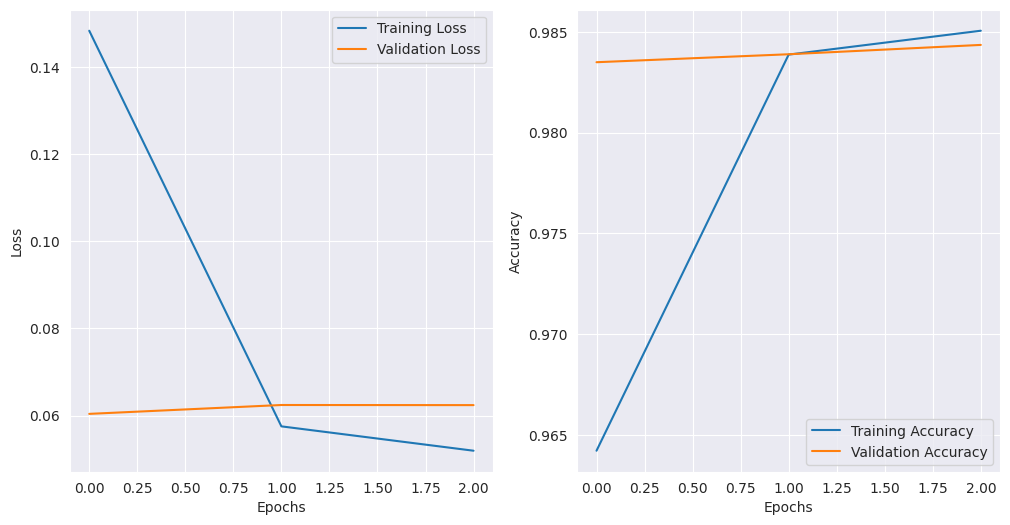

1819/1819 [==============================] - 11s 6ms/step - loss: 0.0604 - accuracy: 0.9835


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Confusion Matrix:
          comp1  comp2  comp3  comp4  comps1&2  comps1&3  comps1&4  comps2&3  comps2&4  comps3&4   none
comp1       212      0      0      0         0         0         0         0         0         0    196
comp2         0    388      0      0         0         0         0         0         4         0    208
comp3         0      0    322      0         0         0         0         0         0         0    158
comp4         0      0      0    216         0         0         0         0         0         0    120
comps1&2      0      1      0      0        15         0         0         0         0         0      8
comps1&3      1      0      6      0         0         0         0         0         0         0      5
comps1&4      0      0      0     11         0         0         5         0         0         0      8
comps2&3      0      0      0      0         0         0         0         0         0         0      0
comps2&4      0      2      0      2         0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.



Precision Matrix:
Precision = True Positives / (True Positives + False Positives)
       Class  Precision
0      comp1   0.821705
1      comp2   0.849015
2      comp3   0.838542
3      comp4   0.815094
4   comps1&2   1.000000
5   comps1&3   0.000000
6   comps1&4   1.000000
7   comps2&3   0.000000
8   comps2&4   0.840000
9   comps3&4   0.500000
10      none   0.987279

Recall Matrix:
Recall= True Positives / (True Positives + False Negatives)
       Class    Recall
0      comp1  0.519608
1      comp2  0.646667
2      comp3  0.670833
3      comp4  0.642857
4   comps1&2  0.625000
5   comps1&3  0.000000
6   comps1&4  0.208333
7   comps2&3  0.000000
8   comps2&4  0.437500
9   comps3&4  0.666667
10      none  0.996390


In [78]:
label_encoder = LabelEncoder()
label_encoder.fit(y)
yn_train = label_encoder.transform(y_train)
yn_test = label_encoder.transform(y_test)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import layers, callbacks
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Set random seeds for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
#tf.config.threading.set_intra_op_parallelism_threads(1)
#tf.config.threading.set_inter_op_parallelism_threads(1)
tf.keras.backend.set_floatx('float32')

# X_train, X_test, yn_train, yn_test are training and testing data

scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=2, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Build the model
model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))  # len(label_encoder.classes_) categories

# Compile the model
model.compile(optimizer='rmsprop', #'adam', #
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, yn_train, epochs=200, batch_size=128, 
                    callbacks=[early_stopping],validation_data=(X_test_scaled, yn_test))

# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluate the model on the test set
y_pred_probabilities = model.predict(X_test_scaled)
yn_pred = np.argmax(y_pred_probabilities, axis=1)

y_pred = label_encoder.inverse_transform(yn_pred)

loss, accuracy = model.evaluate(X_test_scaled, yn_test)
modelTF36_3hr = calc_acc_prec_recall(y_test,y_pred,label_encoder)


In [79]:
tableTF36_3hr = pd.DataFrame(["36hr 3hr","TensorFlow","0",round(accuracy,4),"4 Dense Layer 1024, Drop .5, BatchNorm, batch_size=128"]).T
tableTF36_3hr.columns = ["Pred/lag hour","Classifier", "Rank", "Mean","Parameters"]
print(tableTF36_3hr)

  Pred/lag hour  Classifier Rank    Mean  \
0      36hr 3hr  TensorFlow    0  0.9835   

                                               Parameters  
0  4 Dense Layer 1024, Drop .5, BatchNorm, batch_size=128  


### Use XGBoost as it outperformed other classifiers in 24 hour prediction model and DF structure similar

In [80]:
#yn_train = label_encoder.transform(y_train)
random_search=random_search_pipeline(X_train, yn_train)
best_estimator = random_search.best_estimator_

In [81]:
yn_pred = best_estimator.predict(X_test)
y_pred = label_encoder.inverse_transform(yn_pred)
model36_3hr = calc_acc_prec_recall(y_test,y_pred,label_encoder)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Confusion Matrix:
          comp1  comp2  comp3  comp4  comps1&2  comps1&3  comps1&4  comps2&3  comps2&4  comps3&4   none
comp1       360      4      0      0         0         0         0         0         0         0     44
comp2         2    524      0      0         0         0         0         0         8         0     66
comp3         0      3    446      2         0         0         0         0         0         0     29
comp4         0      4      0    309         0         0         0         0         1         0     22
comps1&2      7     10      0      0         7         0         0         0         0         0      0
comps1&3      6      0      5      0         0         0         0         0         0         0      1
comps1&4      1      0      0     23         0         0         0         0         0         0      0
comps2&3      0      0      0      0         0         0         0         0         0         0      0
comps2&4      0      6      0      7         0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Precision Matrix:
Precision = True Positives / (True Positives + False Positives)
       Class  Precision
0      comp1   0.875912
1      comp2   0.903448
2      comp3   0.901010
3      comp4   0.848901
4   comps1&2   0.583333
5   comps1&3   0.000000
6   comps1&4   0.000000
7   comps2&3   0.000000
8   comps2&4   0.767442
9   comps3&4   0.000000
10      none   0.997050

Recall Matrix:
Recall= True Positives / (True Positives + False Negatives)
       Class    Recall
0      comp1  0.882353
1      comp2  0.873333
2      comp3  0.929167
3      comp4  0.919643
4   comps1&2  0.291667
5   comps1&3  0.000000
6   comps1&4  0.000000
7   comps2&3  0.000000
8   comps2&4  0.687500
9   comps3&4  0.000000
10      none  0.997724


In [82]:
'''
table48_3hr = PrettyTable()
table48_3hr.add_row(["48hr 3hr","XGBClassifier","0",round(random_search.best_score_,4),random_search.best_params_])'''
table36_3hr = pd.DataFrame(["36hr 3hr","XGBClassifier","0",round(random_search.best_score_,4),random_search.best_params_]).T
table36_3hr.columns = ["Pred/lag hour","Classifier", "Rank", "Mean","Parameters"]
print(table36_3hr)

  Pred/lag hour     Classifier Rank    Mean  \
0      36hr 3hr  XGBClassifier    0  0.9944   

                                                                                               Parameters  
0  {'subsample': 1, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.15, 'colsample_bytree': 0.5}  


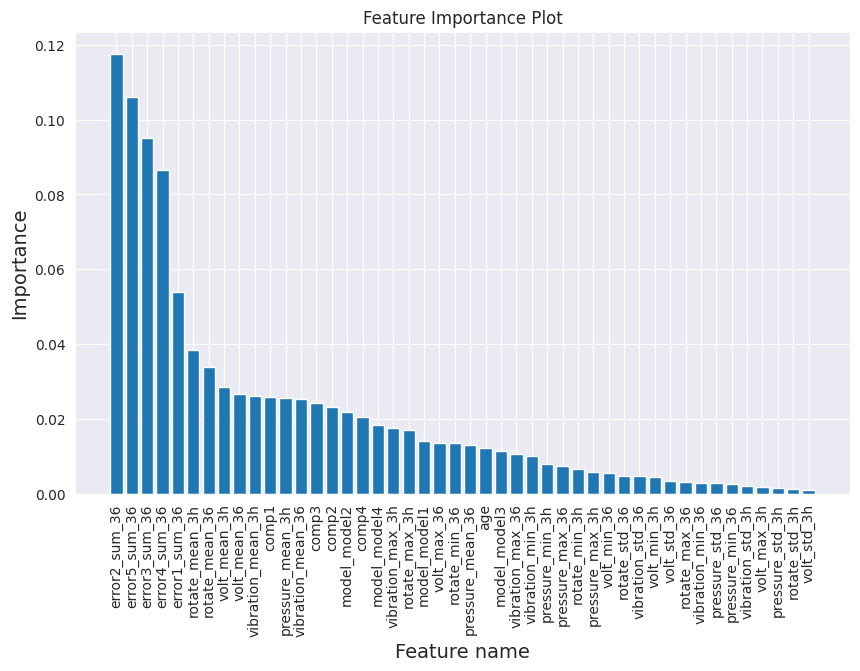

In [83]:
feature_importance_plot(X_test,best_estimator)

<a class="anchor" id="Model48_lag6"></a>
<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Model for 48 hour prediction with 3 hour lag</h2>



</div>

In [84]:
aggrs = ['sum']  # aggregate list that will be added to features
features = ['error%d' % i for i in range(1,6)] # feature list
rule = '3H'
window = 48
error_count48 =roll_resample_feat_rule(error_count, features, window, rule, aggrs)
error_count48.describe()

,machineID,datetime,error1_sum_48,error2_sum_48,error3_sum_48,error4_sum_48,error5_sum_48
count,290600.00000,290600,290600.000000,290600.000000,290600.000000,290600.000000,290600.000000
mean,50.50000,2015-07-03 19:30:00,0.055286,0.054219,0.045847,0.039876,0.019532
min,1.00000,2015-01-03 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-04 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,2015-07-03 19:30:00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,2015-10-02 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2016-01-01 09:00:00,3.000000,3.000000,3.000000,3.000000,2.000000
std,28.86612,NaN,0.235128,0.232626,0.214305,0.199707,0.139993


In [85]:
aggrs = ['mean','min','max','std']  # aggregate list that will be added to features
features = ['volt', 'rotate', 'pressure', 'vibration'] # feature list
rule = '3H'
window = 48
# Calculate "resample 'min', 'max', 'mean', or 'median' values" over the last 6 hour lag window
# for telemetry features and merge with
# Calculation of "rolling resample 'min', 'max', 'mean', or 'std' values" over the last 48 hour lag window
# for telemetry features 'fields'.
telemetry_lagfeat48 = pd.concat([resample_feat_rule(telemetry, features, rule, aggrs),
                            roll_resample_feat_rule(telemetry, features, window, rule, aggrs).iloc[:, 2:]], axis=1).dropna()
telemetry_lagfeat48.describe()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,pressure_min_48,vibration_min_48,volt_max_48,rotate_max_48,pressure_max_48,vibration_max_48,volt_std_48,rotate_std_48,pressure_std_48,vibration_std_48
count,290500.00000,290500,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,...,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000
mean,50.50000,2015-07-03 18:00:00.000000256,170.770861,446.617765,100.855611,40.383571,158.072102,404.144008,92.377658,36.146643,...,77.991152,29.004879,204.659470,560.129490,123.780454,51.762518,15.078531,50.609666,10.242839,5.082678
min,1.00000,2015-01-03 06:00:00,125.532506,211.811184,72.118639,26.569635,97.333604,138.432075,51.237106,14.877054,...,51.237106,14.877054,181.753428,394.815545,106.860209,43.561144,8.572887,28.916424,5.585285,2.883879
25%,25.75000,2015-04-04 00:00:00,164.445707,427.568132,96.239153,38.147287,150.362703,379.506058,86.861829,33.457012,...,74.989861,27.519031,198.926351,543.920198,119.222860,49.645879,13.932484,46.601414,9.299824,4.651623
50%,50.50000,2015-07-03 18:00:00,170.430366,448.389150,100.233244,40.146063,158.164123,406.885218,92.114226,36.087767,...,78.294864,29.155074,203.433530,558.788422,122.262331,51.164197,15.004424,50.173468,10.020070,5.011135
75%,75.25000,2015-10-02 12:00:00,176.605921,468.444197,104.404540,42.226863,165.837143,432.058039,97.272277,38.666230,...,81.234961,30.600113,209.063843,574.852679,126.072449,53.034300,16.132925,53.991995,10.803847,5.401454
max,100.00000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,235.726785,565.962115,160.026994,68.001841,...,117.635969,52.083159,255.124717,695.020984,185.951998,76.791072,29.530469,104.933839,28.251997,11.419040
std,28.86612,NaN,9.497163,33.117121,7.408122,3.475394,11.871843,40.808434,8.774756,4.205752,...,5.115899,2.503011,8.283306,24.893229,7.278493,3.244980,1.679652,6.018818,1.586619,0.672638


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Merge all the 48 hour lag feature with telemetry data sets</h2>

In [86]:
mach_feature48 = telemetry_lagfeat48.merge(error_count48, on=['datetime', 'machineID'], how='left') # remove error_count24
mach_feature48 = mach_feature48.merge(comp_dum, on=['datetime', 'machineID'], how='left')
mach_feature48 = mach_feature48.merge(machines, on=['machineID'], how='left')
mach_feature48.describe()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,error1_sum_48,error2_sum_48,error3_sum_48,error4_sum_48,error5_sum_48,comp1,comp2,comp3,comp4,age
count,290500.00000,290500,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,...,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000
mean,50.50000,2015-07-03 18:00:00.000000256,170.770861,446.617765,100.855611,40.383571,158.072102,404.144008,92.377658,36.146643,...,0.055305,0.054231,0.045845,0.039880,0.019539,1277.590719,1227.392881,1256.395373,1282.662692,11.330000
min,1.00000,2015-01-03 06:00:00,125.532506,211.811184,72.118639,26.569635,97.333604,138.432075,51.237106,14.877054,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-04 00:00:00,164.445707,427.568132,96.239153,38.147287,150.362703,379.506058,86.861829,33.457012,...,0.000000,0.000000,0.000000,0.000000,0.000000,318.000000,288.000000,312.000000,309.000000,6.750000
50%,50.50000,2015-07-03 18:00:00,170.430366,448.389150,100.233244,40.146063,158.164123,406.885218,92.114226,36.087767,...,0.000000,0.000000,0.000000,0.000000,0.000000,783.000000,708.000000,768.000000,774.000000,12.000000
75%,75.25000,2015-10-02 12:00:00,176.605921,468.444197,104.404540,42.226863,165.837143,432.058039,97.272277,38.666230,...,0.000000,0.000000,0.000000,0.000000,0.000000,1638.000000,1581.000000,1602.000000,1674.000000,16.000000
max,100.00000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,235.726785,565.962115,160.026994,68.001841,...,3.000000,3.000000,3.000000,3.000000,2.000000,11805.000000,8373.000000,8901.000000,9477.000000,20.000000
std,28.86612,NaN,9.497163,33.117121,7.408122,3.475394,11.871843,40.808434,8.774756,4.205752,...,0.235166,0.232651,0.214303,0.199716,0.140016,1496.402665,1416.329096,1407.878240,1428.118019,5.827625


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Create Labels for 48 hours prediction</h2>



</div>

In [87]:
labeled_features48 = create_labels(mach_feature48,failures_without_duplicates,
                  dup_dfs,fill_hrs=48, laghrs=3)

In [88]:
labeled_features48.describe()

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,error1_sum_48,error2_sum_48,error3_sum_48,error4_sum_48,error5_sum_48,comp1,comp2,comp3,comp4,age
count,290500.00000,290500,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,...,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000
mean,50.50000,2015-07-03 18:00:00.000000256,170.770861,446.617765,100.855611,40.383571,158.072102,404.144008,92.377658,36.146643,...,0.055305,0.054231,0.045845,0.039880,0.019539,1277.590719,1227.392881,1256.395373,1282.662692,11.330000
min,1.00000,2015-01-03 06:00:00,125.532506,211.811184,72.118639,26.569635,97.333604,138.432075,51.237106,14.877054,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-04 00:00:00,164.445707,427.568132,96.239153,38.147287,150.362703,379.506058,86.861829,33.457012,...,0.000000,0.000000,0.000000,0.000000,0.000000,318.000000,288.000000,312.000000,309.000000,6.750000
50%,50.50000,2015-07-03 18:00:00,170.430366,448.389150,100.233244,40.146063,158.164123,406.885218,92.114226,36.087767,...,0.000000,0.000000,0.000000,0.000000,0.000000,783.000000,708.000000,768.000000,774.000000,12.000000
75%,75.25000,2015-10-02 12:00:00,176.605921,468.444197,104.404540,42.226863,165.837143,432.058039,97.272277,38.666230,...,0.000000,0.000000,0.000000,0.000000,0.000000,1638.000000,1581.000000,1602.000000,1674.000000,16.000000
max,100.00000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,235.726785,565.962115,160.026994,68.001841,...,3.000000,3.000000,3.000000,3.000000,2.000000,11805.000000,8373.000000,8901.000000,9477.000000,20.000000
std,28.86612,NaN,9.497163,33.117121,7.408122,3.475394,11.871843,40.808434,8.774756,4.205752,...,0.235166,0.232651,0.214303,0.199716,0.140016,1496.402665,1416.329096,1407.878240,1428.118019,5.827625


In [89]:
labeled_features48[
    #(labeled_features48['failure'] == 'comp1') &  # Filtering for 'failure' column with value 'compX'
    (labeled_features48['machineID'] == 2) &     # Filtering for 'machineID' column with value Y
    (labeled_features48['datetime'] > pd.to_datetime('2015-03-16 00:00:00')) &   # Lower bound
    (labeled_features48['datetime'] <= pd.to_datetime('2015-03-19 06:00:00'))    # Upper bound
]

,machineID,datetime,volt_mean_3h,rotate_mean_3h,pressure_mean_3h,vibration_mean_3h,volt_min_3h,rotate_min_3h,pressure_min_3h,vibration_min_3h,...,error3_sum_48,error4_sum_48,error5_sum_48,comp1,comp2,comp3,comp4,model,age,failure
3480,2,2015-03-16 03:00:00,162.999079,450.992394,106.451373,40.204156,161.846021,390.172498,100.462623,36.252666,...,0.0,0.0,0.0,6549.0,5109.0,645.0,285.0,model4,7,none
3481,2,2015-03-16 06:00:00,158.694296,461.070701,107.688669,39.354243,149.175544,452.499769,99.809224,37.434584,...,0.0,0.0,0.0,6552.0,5112.0,648.0,288.0,model4,7,none
3482,2,2015-03-16 09:00:00,177.647712,381.587333,92.124419,36.258825,169.430378,340.377620,85.115138,30.695417,...,0.0,0.0,0.0,6555.0,5115.0,651.0,291.0,model4,7,none
3483,2,2015-03-16 12:00:00,175.137414,450.531680,92.691694,37.881644,165.213940,385.919920,87.754292,32.884547,...,0.0,0.0,0.0,6558.0,5118.0,654.0,294.0,model4,7,none
3484,2,2015-03-16 15:00:00,160.706203,426.272390,93.487327,42.071604,148.069009,415.588728,87.380976,37.502139,...,0.0,0.0,0.0,6561.0,5121.0,657.0,297.0,model4,7,none
3485,2,2015-03-16 18:00:00,179.260992,505.640507,105.042079,43.656963,176.062170,497.545704,93.007327,40.871406,...,0.0,0.0,0.0,6564.0,5124.0,660.0,300.0,model4,7,none
3486,2,2015-03-16 21:00:00,174.631190,389.350672,103.229892,38.830162,170.977717,361.265870,97.274272,34.493067,...,0.0,0.0,0.0,6567.0,5127.0,663.0,303.0,model4,7,none
3487,2,2015-03-17 00:00:00,168.392120,456.583436,93.337372,39.187217,158.903412,426.960868,83.241529,37.788793,...,0.0,0.0,0.0,6570.0,5130.0,666.0,306.0,model4,7,none
3488,2,2015-03-17 03:00:00,181.998415,433.087627,92.204539,39.509945,167.580403,418.992300,90.914233,34.695831,...,0.0,0.0,0.0,6573.0,5133.0,669.0,309.0,model4,7,none
3489,2,2015-03-17 06:00:00,164.421135,461.543033,112.281228,46.262045,154.044511,376.318539,109.197789,42.344200,...,0.0,0.0,0.0,6576.0,5136.0,672.0,312.0,model4,7,none


In [90]:
X = labeled_features48.drop(labels=['datetime', 'machineID', 'failure'], axis=1)
X = pd.get_dummies(X) # for mode numbers
print(X.head())
y =labeled_features48['failure']

   volt_mean_3h  rotate_mean_3h  pressure_mean_3h  vibration_mean_3h  \
0    181.690108      472.783187         93.395164          38.621099   
1    172.382935      505.141261         98.524373          49.965572   
2    174.303858      436.182686         94.092681          50.999589   
3    176.246348      451.646684         98.102389          59.198241   
4    158.433533      453.900213         98.878129          46.851925   

   volt_min_3h  rotate_min_3h  pressure_min_3h  vibration_min_3h  volt_max_3h  \
0   174.138401     418.842271        91.926306         32.323616   194.942847   
1   164.341435     459.956670        94.488533         47.875804   177.594089   
2   156.866113     405.869840        85.246610         47.698464   194.581170   
3   166.480684     427.675888        87.874871         55.062110   190.431960   
4   154.199258     429.822144        85.755546         43.788682   164.148095   

   rotate_max_3h  ...  error5_sum_48  comp1   comp2   comp3   comp4  age  \
0   

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, shuffle=False)

Epoch 1/200
1816/1816 [==============================] - 101s 55ms/step - loss: 0.1857 - accuracy: 0.9532 - val_loss: 0.1016 - val_accuracy: 0.9691
Epoch 2/200
1816/1816 [==============================] - 99s 54ms/step - loss: 0.0903 - accuracy: 0.9733 - val_loss: 0.0960 - val_accuracy: 0.9710
Epoch 3/200
1816/1816 [==============================] - 99s 54ms/step - loss: 0.0820 - accuracy: 0.9755 - val_loss: 0.0859 - val_accuracy: 0.9727
Epoch 4/200
1816/1816 [==============================] - 99s 54ms/step - loss: 0.0768 - accuracy: 0.9765 - val_loss: 0.0968 - val_accuracy: 0.9720
Epoch 5/200
1816/1816 [==============================] - 99s 54ms/step - loss: 0.0730 - accuracy: 0.9774 - val_loss: 0.0901 - val_accuracy: 0.9730


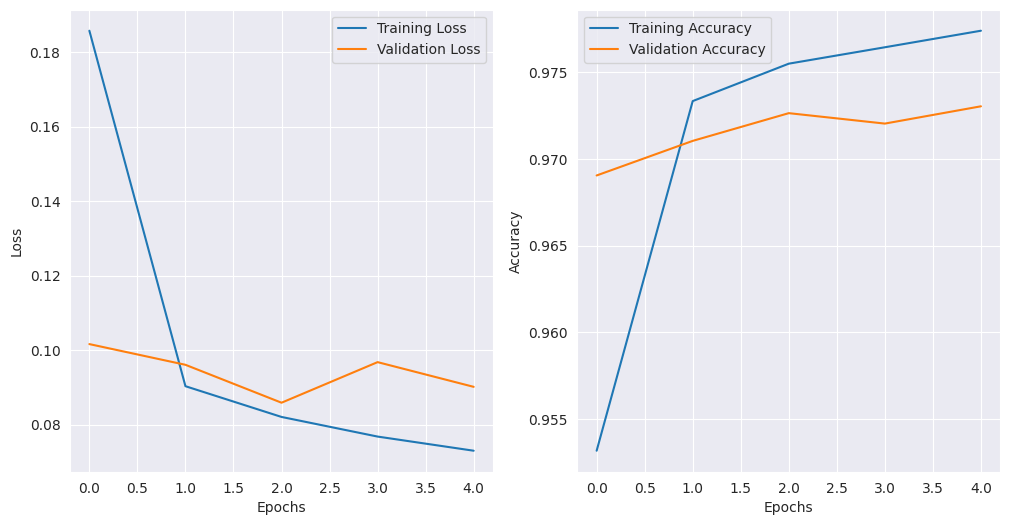

1816/1816 [==============================] - 12s 7ms/step - loss: 0.0859 - accuracy: 0.9727
Confusion Matrix:
          comp1  comp2  comp3  comp4  comps1&2  comps1&3  comps1&4  comps2&3  comps2&4  comps3&4   none
comp1       281      0      0      0         0         0         0         0         0         0    263
comp2         2    380      0      0         0         0         0         0        11         0    407
comp3         0      1    462      0         0         0         0         0         0         0    177
comp4         0      0      0    223         0         0         0         0         1         0    224
comps1&2      2      0      0      0        13         0         0         0         0         0     17
comps1&3      5      0      5      0         0         1         0         0         0         0      5
comps1&4      0      0      0      5         0         0         9         0         0         0     18
comps2&3      0      0      0      0         0         0  

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.



Precision Matrix:
Precision = True Positives / (True Positives + False Positives)
       Class  Precision
0      comp1   0.692118
1      comp2   0.835165
2      comp3   0.717391
3      comp4   0.819853
4   comps1&2   1.000000
5   comps1&3   1.000000
6   comps1&4   1.000000
7   comps2&3   0.000000
8   comps2&4   0.673077
9   comps3&4   1.000000
10      none   0.979712

Recall Matrix:
Recall= True Positives / (True Positives + False Negatives)
       Class    Recall
0      comp1  0.516544
1      comp2  0.475000
2      comp3  0.721875
3      comp4  0.497768
4   comps1&2  0.406250
5   comps1&3  0.062500
6   comps1&4  0.281250
7   comps2&3  0.000000
8   comps2&4  0.546875
9   comps3&4  0.437500
10      none  0.992650


In [92]:
label_encoder = LabelEncoder()
label_encoder.fit(y)
yn_train = label_encoder.transform(y_train)
yn_test = label_encoder.transform(y_test)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import layers, callbacks
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Set random seeds for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
#tf.config.threading.set_intra_op_parallelism_threads(1)
#tf.config.threading.set_inter_op_parallelism_threads(1)
tf.keras.backend.set_floatx('float32')

# X_train, X_test, yn_train, yn_test are training and testing data

scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=2, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Build the model
model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))  # len(label_encoder.classes_) categories

# Compile the model
model.compile(optimizer='rmsprop', #'adam', #
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, yn_train, epochs=200, batch_size=128, 
                    callbacks=[early_stopping],validation_data=(X_test_scaled, yn_test))

# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluate the model on the test set
y_pred_probabilities = model.predict(X_test_scaled)
yn_pred = np.argmax(y_pred_probabilities, axis=1)

y_pred = label_encoder.inverse_transform(yn_pred)

loss, accuracy = model.evaluate(X_test_scaled, yn_test)
modelTF48_3hr = calc_acc_prec_recall(y_test,y_pred,label_encoder)

In [93]:
tableTF48_3hr = pd.DataFrame(["48hr 3hr","TensorFlow","0",round(accuracy,4),"4 Dense Layer 1024, Drop .5, BatchNorm, batch_size=128"]).T
tableTF48_3hr.columns = ["Pred/lag hour","Classifier", "Rank", "Mean","Parameters"]
print(tableTF48_3hr)

  Pred/lag hour  Classifier Rank    Mean  \
0      48hr 3hr  TensorFlow    0  0.9727   

                                               Parameters  
0  4 Dense Layer 1024, Drop .5, BatchNorm, batch_size=128  


### Use XGBoost as it outperformed other classifiers in 24 hour prediction model and DF structure similar

In [94]:
#yn_train = label_encoder.fit_transform(y_train)
random_search=random_search_pipeline(X_train, yn_train)
best_estimator = random_search.best_estimator_

1. 

In [95]:
yn_pred = best_estimator.predict(X_test)
y_pred = label_encoder.inverse_transform(yn_pred)
model48_3hr = calc_acc_prec_recall(y_test,y_pred,label_encoder)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Confusion Matrix:
          comp1  comp2  comp3  comp4  comps1&2  comps1&3  comps1&4  comps2&3  comps2&4  comps3&4   none
comp1       386      8      0      0         0         0         0         0         0         0    150
comp2         5    604      0      6         0         0         0         0         7         0    178
comp3         0      1    605      8         0         0         0         0         0         0     26
comp4         0      5      0    402         0         0         0         0         2         1     38
comps1&2      2     27      0      0         1         0         0         0         0         0      2
comps1&3      3      0     13      0         0         0         0         0         0         0      0
comps1&4      0      0      0     32         0         0         0         0         0         0      0
comps2&3      0      0      0      0         0         0         0         0         0         0      0
comps2&4      0      7      0     23         0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.



Precision Matrix:
Precision = True Positives / (True Positives + False Positives)
       Class  Precision
0      comp1   0.908235
1      comp2   0.864092
2      comp3   0.878084
3      comp4   0.764259
4   comps1&2   0.200000
5   comps1&3   0.000000
6   comps1&4   0.000000
7   comps2&3   0.000000
8   comps2&4   0.769231
9   comps3&4   0.750000
10      none   0.992838

Recall Matrix:
Recall= True Positives / (True Positives + False Negatives)
       Class    Recall
0      comp1  0.709559
1      comp2  0.755000
2      comp3  0.945312
3      comp4  0.897321
4   comps1&2  0.031250
5   comps1&3  0.000000
6   comps1&4  0.000000
7   comps2&3  0.000000
8   comps2&4  0.468750
9   comps3&4  0.187500
10      none  0.996505


In [96]:
'''table48_6hr = PrettyTable()
table48_6hr.add_row(["48hr 6hr","XGBClassifier","0",round(random_search.best_score_,4),random_search.best_params_])'''
table48_3hr = pd.DataFrame(["48hr 3hr","XGBClassifier","0",round(random_search.best_score_,4),random_search.best_params_]).T
table48_3hr.columns= ["Pred/lag hour","Classifier", "Rank", "Mean","Parameters"]
display(table48_3hr)

,Pred/lag hour,Classifier,Rank,Mean,Parameters
0,48hr 3hr,XGBClassifier,0,0.9881,"{'subsample': 1, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.15, 'colsample_bytree': 0.5}"


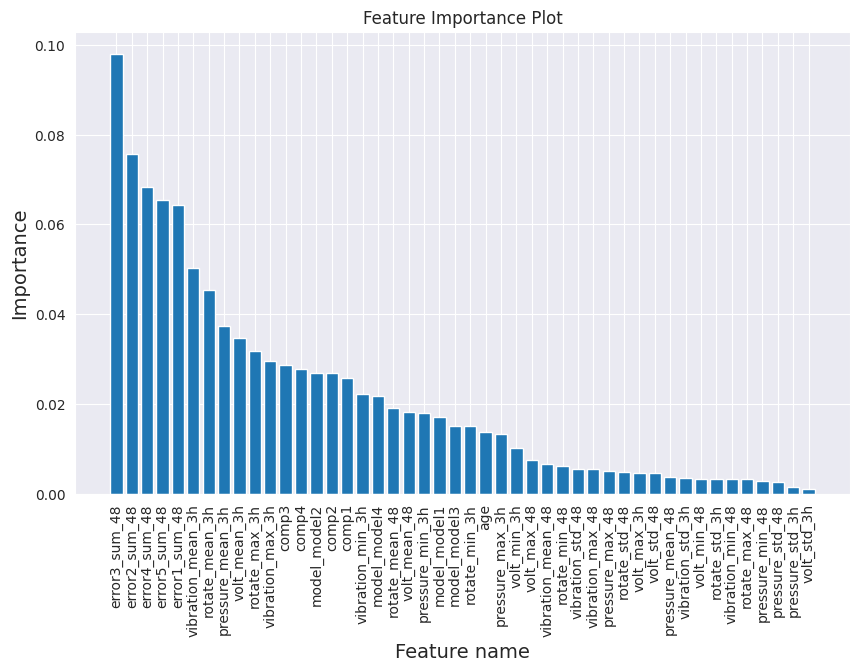

In [97]:
feature_importance_plot(X_test,best_estimator)

<a class="anchor" id="Model24_shift_lag"></a>
<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">24 hrs window 3 hr shift columns lag</h2>
</div>

In [98]:
aggrs = ['mean']  # aggregate list that will be added to features
features = ['volt', 'rotate', 'pressure', 'vibration'] # feature list
rule = '3H'
# Calculate 'mean' over the last 3 hour lag window
# for telemetry features
telemetry_feat_mean = resample_feat_rule(telemetry, features, rule, aggrs)

In [99]:
# Shift columns
telemetry_feat_shift_lag24 = telemetry_shift_columns(telemetry_feat_mean, pred_hours=24)
telemetry_feat_shift_lag24

,machineID,datetime,volt_mean_3h_24,rotate_mean_3h_24,pressure_mean_3h_24,vibration_mean_3h_24,volt_mean_3h_21,rotate_mean_3h_21,pressure_mean_3h_21,vibration_mean_3h_21,...,pressure_mean_3h_9,vibration_mean_3h_9,volt_mean_3h_6,rotate_mean_3h_6,pressure_mean_3h_6,vibration_mean_3h_6,volt_mean_3h_3,rotate_mean_3h_3,pressure_mean_3h_3,vibration_mean_3h_3
7,1,2015-01-02 06:00:00,170.028993,449.533798,94.592122,40.893502,164.192565,403.949857,105.687417,34.255891,...,90.446472,41.796657,172.277489,477.738628,89.104865,41.232001,180.133784,440.608320,94.137969,41.551544
8,1,2015-01-02 09:00:00,164.192565,403.949857,105.687417,34.255891,168.134445,435.781707,107.793709,41.239405,...,89.104865,41.232001,180.133784,440.608320,94.137969,41.551544,176.364293,439.349655,101.553209,36.105580
9,1,2015-01-02 12:00:00,168.134445,435.781707,107.793709,41.239405,165.514453,430.472823,101.703289,40.373739,...,94.137969,41.551544,176.364293,439.349655,101.553209,36.105580,160.384568,424.385316,99.598722,36.094637
10,1,2015-01-02 15:00:00,165.514453,430.472823,101.703289,40.373739,168.809347,437.111120,90.911060,41.738542,...,101.553209,36.105580,160.384568,424.385316,99.598722,36.094637,170.472461,442.933997,102.380586,40.483002
11,1,2015-01-02 18:00:00,168.809347,437.111120,90.911060,41.738542,168.779396,486.242664,90.446472,41.796657,...,99.598722,36.094637,170.472461,442.933997,102.380586,40.483002,163.263806,468.937558,102.726648,40.921802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292095,100,2015-12-31 21:00:00,160.093725,418.468730,103.425431,36.685150,153.108292,446.710462,105.795285,38.450196,...,100.891981,36.788042,177.758754,458.391629,103.183160,46.846592,166.078945,424.431184,98.344409,30.907459
292096,100,2016-01-01 00:00:00,153.108292,446.710462,105.795285,38.450196,156.507808,490.798016,98.534959,40.310998,...,103.183160,46.846592,166.078945,424.431184,98.344409,30.907459,158.327984,504.056262,108.055441,40.109705
292097,100,2016-01-01 03:00:00,156.507808,490.798016,98.534959,40.310998,176.040842,518.996046,97.541077,39.385324,...,98.344409,30.907459,158.327984,504.056262,108.055441,40.109705,170.306956,438.653616,102.346227,47.481232
292098,100,2016-01-01 06:00:00,176.040842,518.996046,97.541077,39.385324,190.802419,469.677266,102.422640,37.816891,...,108.055441,40.109705,170.306956,438.653616,102.346227,47.481232,182.525427,435.932056,98.798172,42.757630


In [100]:
telemetry_feat_shift_lag24.columns.tolist()

['machineID',
 'datetime',
 'volt_mean_3h_24',
 'rotate_mean_3h_24',
 'pressure_mean_3h_24',
 'vibration_mean_3h_24',
 'volt_mean_3h_21',
 'rotate_mean_3h_21',
 'pressure_mean_3h_21',
 'vibration_mean_3h_21',
 'volt_mean_3h_18',
 'rotate_mean_3h_18',
 'pressure_mean_3h_18',
 'vibration_mean_3h_18',
 'volt_mean_3h_15',
 'rotate_mean_3h_15',
 'pressure_mean_3h_15',
 'vibration_mean_3h_15',
 'volt_mean_3h_12',
 'rotate_mean_3h_12',
 'pressure_mean_3h_12',
 'vibration_mean_3h_12',
 'volt_mean_3h_9',
 'rotate_mean_3h_9',
 'pressure_mean_3h_9',
 'vibration_mean_3h_9',
 'volt_mean_3h_6',
 'rotate_mean_3h_6',
 'pressure_mean_3h_6',
 'vibration_mean_3h_6',
 'volt_mean_3h_3',
 'rotate_mean_3h_3',
 'pressure_mean_3h_3',
 'vibration_mean_3h_3']

In [101]:
mach_feature_shift_lag24 = telemetry_feat_shift_lag24.merge(error_count24, on=['datetime', 'machineID'], how='left')
mach_feature_shift_lag24 = mach_feature_shift_lag24.merge(comp_dum, on=['datetime', 'machineID'], how='left')
mach_feature_shift_lag24 = mach_feature_shift_lag24.merge(machines, on=['machineID'], how='left')
mach_feature_shift_lag24 = mach_feature_shift_lag24.dropna()
mach_feature_shift_lag24.describe()

,machineID,datetime,volt_mean_3h_24,rotate_mean_3h_24,pressure_mean_3h_24,vibration_mean_3h_24,volt_mean_3h_21,rotate_mean_3h_21,pressure_mean_3h_21,vibration_mean_3h_21,...,error1_sum_24,error2_sum_24,error3_sum_24,error4_sum_24,error5_sum_24,comp1,comp2,comp3,comp4,age
count,291300.00000,291300,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,...,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000
mean,50.50000,2015-07-03 06:00:00,170.772603,446.611942,100.854485,40.384524,170.772841,446.613100,100.854284,40.384579,...,0.027659,0.027075,0.022901,0.019907,0.009756,1280.417961,1231.655118,1260.290587,1286.858826,11.330000
min,1.00000,2015-01-02 06:00:00,125.532506,211.811184,72.118639,26.569635,125.532506,211.811184,72.118639,26.569635,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-03 06:00:00,164.447482,427.565810,96.238546,38.147538,164.447482,427.568513,96.238173,38.147605,...,0.000000,0.000000,0.000000,0.000000,0.000000,318.000000,288.000000,312.000000,309.000000,6.750000
50%,50.50000,2015-07-03 06:00:00,170.431581,448.385986,100.233037,40.145749,170.432551,448.388493,100.233022,40.145741,...,0.000000,0.000000,0.000000,0.000000,0.000000,783.000000,708.000000,771.000000,777.000000,12.000000
75%,75.25000,2015-10-02 06:00:00,176.606663,468.445078,104.404569,42.226768,176.606488,468.445387,104.404588,42.226810,...,0.000000,0.000000,0.000000,0.000000,0.000000,1644.000000,1590.000000,1608.000000,1683.000000,16.000000
max,100.00000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,241.420717,586.682904,162.309656,69.311324,...,2.000000,2.000000,2.000000,2.000000,2.000000,11805.000000,8373.000000,8901.000000,9477.000000,20.000000
std,28.86612,NaN,9.496265,33.126895,7.405423,3.478695,9.496432,33.127281,7.404960,3.478404,...,0.166301,0.164446,0.151435,0.140832,0.098813,1498.033522,1419.377832,1410.381699,1430.565253,5.827625


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Create Labels</h2>
</div>

In [102]:
labeled_feature_shift_lag24 = create_labels(mach_feature_shift_lag24,failures_without_duplicates,
                  dup_dfs,fill_hrs=24, laghrs=3)

In [103]:
labeled_feature_shift_lag24.columns.to_list()
labeled_feature_shift_lag24.describe()

,machineID,datetime,volt_mean_3h_24,rotate_mean_3h_24,pressure_mean_3h_24,vibration_mean_3h_24,volt_mean_3h_21,rotate_mean_3h_21,pressure_mean_3h_21,vibration_mean_3h_21,...,error1_sum_24,error2_sum_24,error3_sum_24,error4_sum_24,error5_sum_24,comp1,comp2,comp3,comp4,age
count,291300.00000,291300,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,...,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000
mean,50.50000,2015-07-03 06:00:00,170.772603,446.611942,100.854485,40.384524,170.772841,446.613100,100.854284,40.384579,...,0.027659,0.027075,0.022901,0.019907,0.009756,1280.417961,1231.655118,1260.290587,1286.858826,11.330000
min,1.00000,2015-01-02 06:00:00,125.532506,211.811184,72.118639,26.569635,125.532506,211.811184,72.118639,26.569635,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-03 06:00:00,164.447482,427.565810,96.238546,38.147538,164.447482,427.568513,96.238173,38.147605,...,0.000000,0.000000,0.000000,0.000000,0.000000,318.000000,288.000000,312.000000,309.000000,6.750000
50%,50.50000,2015-07-03 06:00:00,170.431581,448.385986,100.233037,40.145749,170.432551,448.388493,100.233022,40.145741,...,0.000000,0.000000,0.000000,0.000000,0.000000,783.000000,708.000000,771.000000,777.000000,12.000000
75%,75.25000,2015-10-02 06:00:00,176.606663,468.445078,104.404569,42.226768,176.606488,468.445387,104.404588,42.226810,...,0.000000,0.000000,0.000000,0.000000,0.000000,1644.000000,1590.000000,1608.000000,1683.000000,16.000000
max,100.00000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,241.420717,586.682904,162.309656,69.311324,...,2.000000,2.000000,2.000000,2.000000,2.000000,11805.000000,8373.000000,8901.000000,9477.000000,20.000000
std,28.86612,NaN,9.496265,33.126895,7.405423,3.478695,9.496432,33.127281,7.404960,3.478404,...,0.166301,0.164446,0.151435,0.140832,0.098813,1498.033522,1419.377832,1410.381699,1430.565253,5.827625


In [104]:
labeled_feature_shift_lag24[
    #(labeled_feature_shift_lag24['failure'] == 'comp1') &  # Filtering for 'failure' column with value 'compX'
    (labeled_feature_shift_lag24['machineID'] == 2) &     # Filtering for 'machineID' column with value Y
    (labeled_feature_shift_lag24['datetime'] > pd.to_datetime('2015-03-17 06:00:00')) &   # Lower bound
    (labeled_feature_shift_lag24['datetime'] <= pd.to_datetime('2015-03-19 06:00:00'))    # Upper bound
]

,machineID,datetime,volt_mean_3h_24,rotate_mean_3h_24,pressure_mean_3h_24,vibration_mean_3h_24,volt_mean_3h_21,rotate_mean_3h_21,pressure_mean_3h_21,vibration_mean_3h_21,...,error3_sum_24,error4_sum_24,error5_sum_24,comp1,comp2,comp3,comp4,model,age,failure
3506,2,2015-03-17 09:00:00,175.137414,450.531680,92.691694,37.881644,160.706203,426.272390,93.487327,42.071604,...,0.0,0.0,0.0,6579.0,5139.0,675.0,315.0,model4,7,none
3507,2,2015-03-17 12:00:00,160.706203,426.272390,93.487327,42.071604,179.260992,505.640507,105.042079,43.656963,...,0.0,0.0,0.0,6582.0,5142.0,678.0,318.0,model4,7,none
3508,2,2015-03-17 15:00:00,179.260992,505.640507,105.042079,43.656963,174.631190,389.350672,103.229892,38.830162,...,0.0,0.0,0.0,6585.0,5145.0,681.0,321.0,model4,7,none
3509,2,2015-03-17 18:00:00,174.631190,389.350672,103.229892,38.830162,168.392120,456.583436,93.337372,39.187217,...,0.0,0.0,0.0,6588.0,5148.0,684.0,324.0,model4,7,none
3510,2,2015-03-17 21:00:00,168.392120,456.583436,93.337372,39.187217,181.998415,433.087627,92.204539,39.509945,...,0.0,0.0,0.0,6591.0,5151.0,687.0,327.0,model4,7,none
3511,2,2015-03-18 00:00:00,181.998415,433.087627,92.204539,39.509945,164.421135,461.543033,112.281228,46.262045,...,0.0,0.0,0.0,6594.0,5154.0,690.0,330.0,model4,7,none
3512,2,2015-03-18 03:00:00,164.421135,461.543033,112.281228,46.262045,191.877454,371.051731,96.072228,41.693572,...,0.0,0.0,0.0,6597.0,5157.0,693.0,333.0,model4,7,none
3513,2,2015-03-18 06:00:00,191.877454,371.051731,96.072228,41.693572,182.461251,373.972592,104.486993,43.968925,...,0.0,0.0,0.0,6600.0,5160.0,696.0,336.0,model4,7,none
3514,2,2015-03-18 09:00:00,182.461251,373.972592,104.486993,43.968925,205.910271,403.503659,99.287823,44.496410,...,1.0,0.0,0.0,6603.0,5163.0,699.0,339.0,model4,7,comps1&2
3515,2,2015-03-18 12:00:00,205.910271,403.503659,99.287823,44.496410,187.751919,324.751326,98.862119,37.582892,...,1.0,0.0,0.0,6606.0,5166.0,702.0,342.0,model4,7,comps1&2


In [105]:
X = labeled_feature_shift_lag24.drop(labels=['datetime', 'machineID', 'failure'], axis=1)
X = pd.get_dummies(X) # for mode numbers
print(X.head())
y =labeled_feature_shift_lag24['failure']

   volt_mean_3h_24  rotate_mean_3h_24  pressure_mean_3h_24  \
0       170.028993         449.533798            94.592122   
1       164.192565         403.949857           105.687417   
2       168.134445         435.781707           107.793709   
3       165.514453         430.472823           101.703289   
4       168.809347         437.111120            90.911060   

   vibration_mean_3h_24  volt_mean_3h_21  rotate_mean_3h_21  \
0             40.893502       164.192565         403.949857   
1             34.255891       168.134445         435.781707   
2             41.239405       165.514453         430.472823   
3             40.373739       168.809347         437.111120   
4             41.738542       168.779396         486.242664   

   pressure_mean_3h_21  vibration_mean_3h_21  volt_mean_3h_18  \
0           105.687417             34.255891       168.134445   
1           107.793709             41.239405       165.514453   
2           101.703289             40.373739       16

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, shuffle=False)

Epoch 1/200
1821/1821 [==============================] - 102s 55ms/step - loss: 0.0908 - accuracy: 0.9794 - val_loss: 0.0183 - val_accuracy: 0.9971
Epoch 2/200
1821/1821 [==============================] - 100s 55ms/step - loss: 0.0136 - accuracy: 0.9969 - val_loss: 0.0158 - val_accuracy: 0.9976
Epoch 3/200
1821/1821 [==============================] - 100s 55ms/step - loss: 0.0110 - accuracy: 0.9975 - val_loss: 0.0137 - val_accuracy: 0.9979
Epoch 4/200
1821/1821 [==============================] - 102s 56ms/step - loss: 0.0091 - accuracy: 0.9979 - val_loss: 0.0136 - val_accuracy: 0.9982
Epoch 5/200
1821/1821 [==============================] - 101s 56ms/step - loss: 0.0082 - accuracy: 0.9981 - val_loss: 0.0131 - val_accuracy: 0.9981


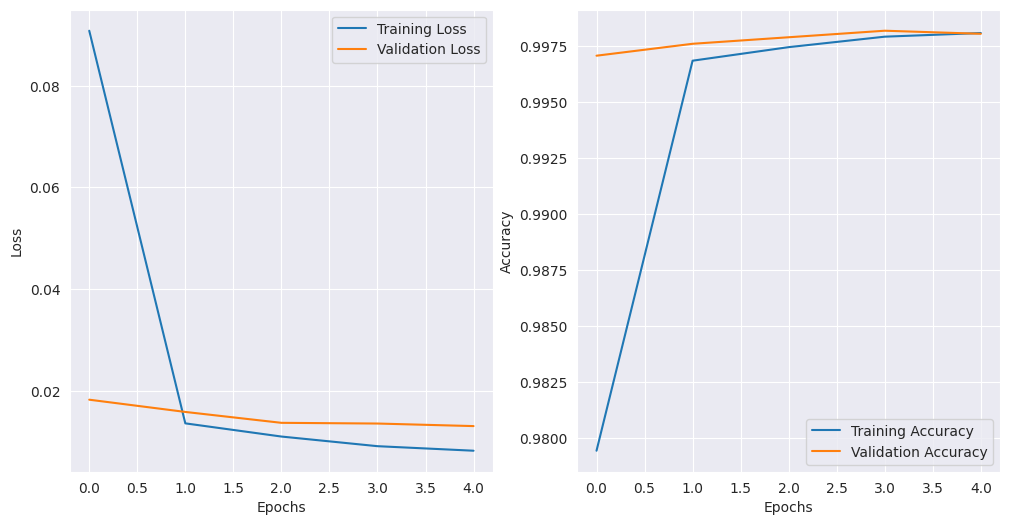

1821/1821 [==============================] - 12s 7ms/step - loss: 0.0137 - accuracy: 0.9979


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Confusion Matrix:
          comp1  comp2  comp3  comp4  comps1&2  comps1&3  comps1&4  comps2&3  comps2&4  comps3&4   none
comp1       272      0      0      0         0         0         0         0         0         0      1
comp2         0    400      0      0         0         0         0         0         0         0      0
comp3         0      0    320      0         0         0         0         0         0         0      0
comp4         0      0      0    223         0         0         0         0         1         0      0
comps1&2      0     10      0      0         6         0         0         0         0         0      0
comps1&3      8      0      0      0         0         0         0         0         0         0      0
comps1&4      0      0      0      8         0         0         4         0         4         0      0
comps2&3      0      0      0      0         0         0         0         0         0         0      0
comps2&4      0      0      0      0         0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.



Precision Matrix:
Precision = True Positives / (True Positives + False Positives)
       Class  Precision
0      comp1   0.829268
1      comp2   0.963855
2      comp3   0.946746
3      comp4   0.899194
4   comps1&2   1.000000
5   comps1&3   0.000000
6   comps1&4   1.000000
7   comps2&3   0.000000
8   comps2&4   0.820513
9   comps3&4   1.000000
10      none   0.999982

Recall Matrix:
Recall= True Positives / (True Positives + False Negatives)
       Class    Recall
0      comp1  0.996337
1      comp2  1.000000
2      comp3  1.000000
3      comp4  0.995536
4   comps1&2  0.375000
5   comps1&3  0.000000
6   comps1&4  0.250000
7   comps2&3  0.000000
8   comps2&4  1.000000
9   comps3&4  0.250000
10      none  0.998525


In [107]:
label_encoder = LabelEncoder()
label_encoder.fit(y)
yn_train = label_encoder.transform(y_train)
yn_test = label_encoder.transform(y_test)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import layers, callbacks
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Set random seeds for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
#tf.config.threading.set_intra_op_parallelism_threads(1)
#tf.config.threading.set_inter_op_parallelism_threads(1)
tf.keras.backend.set_floatx('float32')

# X_train, X_test, yn_train, yn_test are training and testing data

scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=2, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Build the model
model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))  # len(label_encoder.classes_) categories

# Compile the model
model.compile(optimizer='rmsprop', #'adam', #
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, yn_train, epochs=200, batch_size=128, 
                    callbacks=[early_stopping],validation_data=(X_test_scaled, yn_test))

# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluate the model on the test set
y_pred_probabilities = model.predict(X_test_scaled)
yn_pred = np.argmax(y_pred_probabilities, axis=1)

y_pred = label_encoder.inverse_transform(yn_pred)

loss, accuracy = model.evaluate(X_test_scaled, yn_test)
modelTF24_shift_3hr = calc_acc_prec_recall(y_test,y_pred,label_encoder)


In [108]:
tableTF24_shift_3hr = pd.DataFrame(["24hr 3hr Shift Col","TensorFlow","0",round(accuracy,4),"4 Dense Layer 1024, Drop .5, BatchNorm, batch_size=128"]).T
tableTF24_shift_3hr.columns = ["Pred/lag hour","Classifier", "Rank", "Mean","Parameters"]
display(tableTF24_shift_3hr)

,Pred/lag hour,Classifier,Rank,Mean,Parameters
0,24hr 3hr Shift Col,TensorFlow,0,0.9979,"4 Dense Layer 1024, Drop .5, BatchNorm, batch_size=128"


In [109]:
#yn_train = label_encoder.transform(y_train)
grid_search = grid_search_pipeline(X_train,  yn_train)

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

In [110]:
best_estimator=grid_search.best_estimator_
yn_pred = best_estimator.predict(X_test)
y_pred = label_encoder.inverse_transform(yn_pred)
model24_shift_3hr = calc_acc_prec_recall(y_test,y_pred,label_encoder)

Confusion Matrix:
          comp1  comp2  comp3  comp4  comps1&2  comps1&3  comps1&4  comps2&3  comps2&4  comps3&4   none
comp1       273      0      0      0         0         0         0         0         0         0      0
comp2         0    400      0      0         0         0         0         0         0         0      0
comp3         0      0    320      0         0         0         0         0         0         0      0
comp4         0      0      0    224         0         0         0         0         0         0      0
comps1&2      0      0      0      0        16         0         0         0         0         0      0
comps1&3      0      0      0      0         0         8         0         0         0         0      0
comps1&4      0      0      0      0         0         0        16         0         0         0      0
comps2&3      0      0      0      0         0         0         0         0         0         0      0
comps2&4      0      0      0      0         0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.



Precision Matrix:
Precision = True Positives / (True Positives + False Positives)
       Class  Precision
0      comp1   0.964664
1      comp2   0.997506
2      comp3   0.969697
3      comp4   0.965517
4   comps1&2   1.000000
5   comps1&3   1.000000
6   comps1&4   1.000000
7   comps2&3   0.000000
8   comps2&4   1.000000
9   comps3&4   1.000000
10      none   1.000000

Recall Matrix:
Recall= True Positives / (True Positives + False Negatives)
       Class    Recall
0      comp1  1.000000
1      comp2  1.000000
2      comp3  1.000000
3      comp4  1.000000
4   comps1&2  1.000000
5   comps1&3  1.000000
6   comps1&4  1.000000
7   comps2&3  0.000000
8   comps2&4  1.000000
9   comps3&4  0.875000
10      none  0.999508


In [111]:
table24_shift_3hr = create_pretty_table(grid_search,"24hr 3hr Shift Col")

,Pred/lag hour,Classifier,Rank,Mean,Parameters
1,24hr 3hr Shift Col,XGBClassifier,1,0.9995,"{'clfr__learning_rate': 0.1, 'clfr__max_depth': 3, 'clfr__n_estimators': 500}"
2,24hr 3hr Shift Col,RandomForestClassifier,13,0.9991,"{'clfr__max_depth': 20, 'clfr__n_estimators': 100}"
3,24hr 3hr Shift Col,Pipeline,17,0.9973,"{'clfr__lsvc__C': 10, 'clfr__lsvc__intercept_scaling': 10, 'clfr__lsvc__loss': 'squared_hinge'}"
0,24hr 3hr Shift Col,HistGradientBoostingClassifier,37,0.9845,"{'clfr__learning_rate': 0.1, 'clfr__max_depth': 5, 'clfr__max_iter': 300}"


Table above shows XGBClassifier has out performed other classifiers. The second best was RandomForestClassifier at **13th** position.  

In [112]:
grid_search.best_estimator_.named_steps.clfr

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

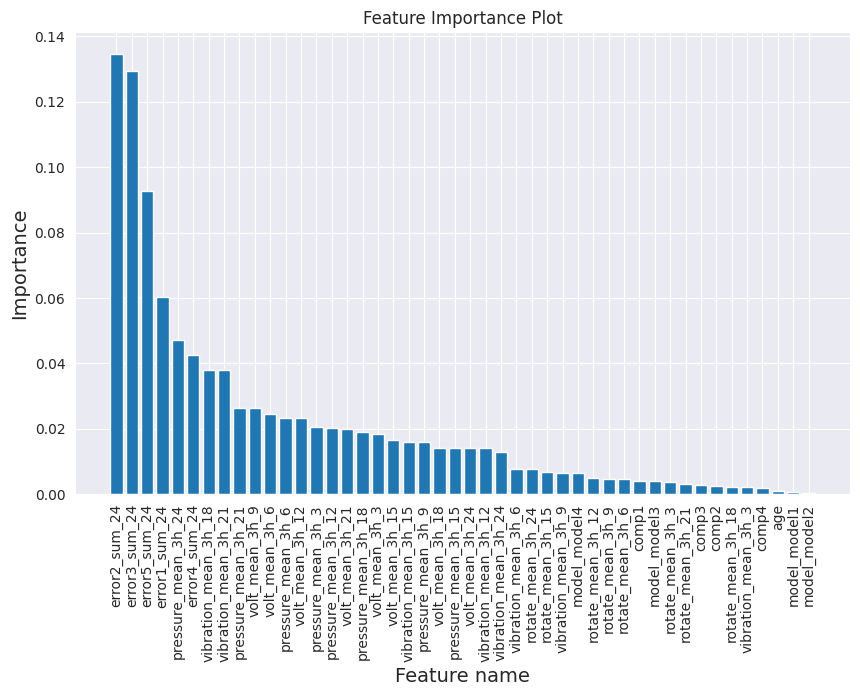

In [113]:
feature_importance_plot(X_test,best_estimator.named_steps.clfr)

<a class="anchor" id="Model48_shift_lag"></a>
<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">48 hrs window 3 hr shift columns lag</h2>
</div>

In [114]:
aggrs = ['mean']  # aggregate list that will be added to features
features = ['volt', 'rotate', 'pressure', 'vibration'] # feature list
rule = '3H'
# Calculate 'mean' over the last 3 hour lag window
# for telemetry features
telemetry_feat_mean = resample_feat_rule(telemetry, features, rule, aggrs)

In [115]:
# Shift columns
telemetry_feat_shift_lag48 = telemetry_shift_columns(telemetry_feat_mean, pred_hours=48)
telemetry_feat_shift_lag48

,machineID,datetime,volt_mean_3h_48,rotate_mean_3h_48,pressure_mean_3h_48,vibration_mean_3h_48,volt_mean_3h_45,rotate_mean_3h_45,pressure_mean_3h_45,vibration_mean_3h_45,...,pressure_mean_3h_9,vibration_mean_3h_9,volt_mean_3h_6,rotate_mean_3h_6,pressure_mean_3h_6,vibration_mean_3h_6,volt_mean_3h_3,rotate_mean_3h_3,pressure_mean_3h_3,vibration_mean_3h_3
15,1,2015-01-03 06:00:00,170.028993,449.533798,94.592122,40.893502,164.192565,403.949857,105.687417,34.255891,...,93.747282,39.716482,175.210027,504.845430,108.512153,37.763933,181.690108,472.783187,93.395164,38.621099
16,1,2015-01-03 09:00:00,164.192565,403.949857,105.687417,34.255891,168.134445,435.781707,107.793709,41.239405,...,108.512153,37.763933,181.690108,472.783187,93.395164,38.621099,172.382935,505.141261,98.524373,49.965572
17,1,2015-01-03 12:00:00,168.134445,435.781707,107.793709,41.239405,165.514453,430.472823,101.703289,40.373739,...,93.395164,38.621099,172.382935,505.141261,98.524373,49.965572,174.303858,436.182686,94.092681,50.999589
18,1,2015-01-03 15:00:00,165.514453,430.472823,101.703289,40.373739,168.809347,437.111120,90.911060,41.738542,...,98.524373,49.965572,174.303858,436.182686,94.092681,50.999589,176.246348,451.646684,98.102389,59.198241
19,1,2015-01-03 18:00:00,168.809347,437.111120,90.911060,41.738542,168.779396,486.242664,90.446472,41.796657,...,94.092681,50.999589,176.246348,451.646684,98.102389,59.198241,158.433533,453.900213,98.878129,46.851925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292095,100,2015-12-31 21:00:00,164.394679,438.937506,93.813332,37.178644,159.767735,456.564035,85.266748,40.989801,...,100.891981,36.788042,177.758754,458.391629,103.183160,46.846592,166.078945,424.431184,98.344409,30.907459
292096,100,2016-01-01 00:00:00,159.767735,456.564035,85.266748,40.989801,167.674472,447.605461,91.239263,43.809642,...,103.183160,46.846592,166.078945,424.431184,98.344409,30.907459,158.327984,504.056262,108.055441,40.109705
292097,100,2016-01-01 03:00:00,167.674472,447.605461,91.239263,43.809642,163.440138,480.468668,106.363030,40.507265,...,98.344409,30.907459,158.327984,504.056262,108.055441,40.109705,170.306956,438.653616,102.346227,47.481232
292098,100,2016-01-01 06:00:00,163.440138,480.468668,106.363030,40.507265,179.723657,463.709612,97.933881,39.207487,...,108.055441,40.109705,170.306956,438.653616,102.346227,47.481232,182.525427,435.932056,98.798172,42.757630


In [116]:
telemetry_feat_shift_lag48.columns.tolist()

['machineID',
 'datetime',
 'volt_mean_3h_48',
 'rotate_mean_3h_48',
 'pressure_mean_3h_48',
 'vibration_mean_3h_48',
 'volt_mean_3h_45',
 'rotate_mean_3h_45',
 'pressure_mean_3h_45',
 'vibration_mean_3h_45',
 'volt_mean_3h_42',
 'rotate_mean_3h_42',
 'pressure_mean_3h_42',
 'vibration_mean_3h_42',
 'volt_mean_3h_39',
 'rotate_mean_3h_39',
 'pressure_mean_3h_39',
 'vibration_mean_3h_39',
 'volt_mean_3h_36',
 'rotate_mean_3h_36',
 'pressure_mean_3h_36',
 'vibration_mean_3h_36',
 'volt_mean_3h_33',
 'rotate_mean_3h_33',
 'pressure_mean_3h_33',
 'vibration_mean_3h_33',
 'volt_mean_3h_30',
 'rotate_mean_3h_30',
 'pressure_mean_3h_30',
 'vibration_mean_3h_30',
 'volt_mean_3h_27',
 'rotate_mean_3h_27',
 'pressure_mean_3h_27',
 'vibration_mean_3h_27',
 'volt_mean_3h_24',
 'rotate_mean_3h_24',
 'pressure_mean_3h_24',
 'vibration_mean_3h_24',
 'volt_mean_3h_21',
 'rotate_mean_3h_21',
 'pressure_mean_3h_21',
 'vibration_mean_3h_21',
 'volt_mean_3h_18',
 'rotate_mean_3h_18',
 'pressure_mean_3h_18

In [117]:
aggrs = ['sum']  # aggregate list that will be added to features
features = ['error%d' % i for i in range(1,6)] # feature list
rule = '3H'
window = 48
error_count48 =roll_resample_feat_rule(error_count, features, window, rule, aggrs)
error_count48.describe()

,machineID,datetime,error1_sum_48,error2_sum_48,error3_sum_48,error4_sum_48,error5_sum_48
count,290600.00000,290600,290600.000000,290600.000000,290600.000000,290600.000000,290600.000000
mean,50.50000,2015-07-03 19:30:00,0.055286,0.054219,0.045847,0.039876,0.019532
min,1.00000,2015-01-03 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-04 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,2015-07-03 19:30:00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,2015-10-02 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2016-01-01 09:00:00,3.000000,3.000000,3.000000,3.000000,2.000000
std,28.86612,NaN,0.235128,0.232626,0.214305,0.199707,0.139993


In [118]:
mach_feature_shift_lag48 = telemetry_feat_shift_lag48.merge(error_count48, on=['datetime', 'machineID'], how='left')
mach_feature_shift_lag48 = mach_feature_shift_lag48.merge(comp_dum, on=['datetime', 'machineID'], how='left')
mach_feature_shift_lag48 = mach_feature_shift_lag48.merge(machines, on=['machineID'], how='left')
mach_feature_shift_lag48 = mach_feature_shift_lag48.dropna()
mach_feature_shift_lag48.describe()

,machineID,datetime,volt_mean_3h_48,rotate_mean_3h_48,pressure_mean_3h_48,vibration_mean_3h_48,volt_mean_3h_45,rotate_mean_3h_45,pressure_mean_3h_45,vibration_mean_3h_45,...,error1_sum_48,error2_sum_48,error3_sum_48,error4_sum_48,error5_sum_48,comp1,comp2,comp3,comp4,age
count,290500.00000,290500,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,...,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000
mean,50.50000,2015-07-03 18:00:00.000000256,170.772270,446.609618,100.852081,40.384458,170.772140,446.611864,100.851641,40.384530,...,0.055305,0.054231,0.045845,0.039880,0.019539,1277.590719,1227.392881,1256.395373,1282.662692,11.330000
min,1.00000,2015-01-03 06:00:00,125.532506,211.811184,72.118639,26.569635,125.532506,211.811184,72.118639,26.569635,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-04 00:00:00,164.447773,427.569157,96.238075,38.147538,164.448225,427.573024,96.238739,38.147639,...,0.000000,0.000000,0.000000,0.000000,0.000000,318.000000,288.000000,312.000000,309.000000,6.750000
50%,50.50000,2015-07-03 18:00:00,170.431723,448.385313,100.231848,40.145915,170.432918,448.386672,100.231946,40.145905,...,0.000000,0.000000,0.000000,0.000000,0.000000,783.000000,708.000000,768.000000,774.000000,12.000000
75%,75.25000,2015-10-02 12:00:00,176.606283,468.443750,104.403038,42.226520,176.604904,468.441949,104.402890,42.226448,...,0.000000,0.000000,0.000000,0.000000,0.000000,1638.000000,1581.000000,1602.000000,1674.000000,16.000000
max,100.00000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,241.420717,586.682904,162.309656,69.311324,...,3.000000,3.000000,3.000000,3.000000,2.000000,11805.000000,8373.000000,8901.000000,9477.000000,20.000000
std,28.86612,NaN,9.495286,33.125174,7.402183,3.478331,9.494629,33.124443,7.400479,3.478249,...,0.235166,0.232651,0.214303,0.199716,0.140016,1496.402665,1416.329096,1407.878240,1428.118019,5.827625


<div style="color:white;
           display:fill;
           border-radius:10px;
           font-size:110%;
           letter-spacing:0.5px;
           color:Black;
            padding:5px 5px 5px 5px;
           ">
<h2 style="text-align:center;font-weight: bold;">Create Labels</h2>
</div>

In [119]:
labeled_feature_shift_lag48 = create_labels(mach_feature_shift_lag48,failures_without_duplicates,
                  dup_dfs,fill_hrs=48, laghrs=3)

In [120]:
labeled_feature_shift_lag48.columns.to_list()
labeled_feature_shift_lag48.describe()

,machineID,datetime,volt_mean_3h_48,rotate_mean_3h_48,pressure_mean_3h_48,vibration_mean_3h_48,volt_mean_3h_45,rotate_mean_3h_45,pressure_mean_3h_45,vibration_mean_3h_45,...,error1_sum_48,error2_sum_48,error3_sum_48,error4_sum_48,error5_sum_48,comp1,comp2,comp3,comp4,age
count,290500.00000,290500,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,...,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000,290500.000000
mean,50.50000,2015-07-03 18:00:00.000000256,170.772270,446.609618,100.852081,40.384458,170.772140,446.611864,100.851641,40.384530,...,0.055305,0.054231,0.045845,0.039880,0.019539,1277.590719,1227.392881,1256.395373,1282.662692,11.330000
min,1.00000,2015-01-03 06:00:00,125.532506,211.811184,72.118639,26.569635,125.532506,211.811184,72.118639,26.569635,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,2015-04-04 00:00:00,164.447773,427.569157,96.238075,38.147538,164.448225,427.573024,96.238739,38.147639,...,0.000000,0.000000,0.000000,0.000000,0.000000,318.000000,288.000000,312.000000,309.000000,6.750000
50%,50.50000,2015-07-03 18:00:00,170.431723,448.385313,100.231848,40.145915,170.432918,448.386672,100.231946,40.145905,...,0.000000,0.000000,0.000000,0.000000,0.000000,783.000000,708.000000,768.000000,774.000000,12.000000
75%,75.25000,2015-10-02 12:00:00,176.606283,468.443750,104.403038,42.226520,176.604904,468.441949,104.402890,42.226448,...,0.000000,0.000000,0.000000,0.000000,0.000000,1638.000000,1581.000000,1602.000000,1674.000000,16.000000
max,100.00000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,241.420717,586.682904,162.309656,69.311324,...,3.000000,3.000000,3.000000,3.000000,2.000000,11805.000000,8373.000000,8901.000000,9477.000000,20.000000
std,28.86612,NaN,9.495286,33.125174,7.402183,3.478331,9.494629,33.124443,7.400479,3.478249,...,0.235166,0.232651,0.214303,0.199716,0.140016,1496.402665,1416.329096,1407.878240,1428.118019,5.827625


In [121]:
labeled_feature_shift_lag48[
    #(labeled_feature_shift_lag48['failure'] == 'comp1') &  # Filtering for 'failure' column with value 'compX'
    (labeled_feature_shift_lag48['machineID'] == 2) &     # Filtering for 'machineID' column with value Y
    (labeled_feature_shift_lag48['datetime'] > pd.to_datetime('2015-03-16 06:00:00')) &   # Lower bound
    (labeled_feature_shift_lag48['datetime'] <= pd.to_datetime('2015-03-19 06:00:00'))    # Upper bound
]

,machineID,datetime,volt_mean_3h_48,rotate_mean_3h_48,pressure_mean_3h_48,vibration_mean_3h_48,volt_mean_3h_45,rotate_mean_3h_45,pressure_mean_3h_45,vibration_mean_3h_45,...,error3_sum_48,error4_sum_48,error5_sum_48,comp1,comp2,comp3,comp4,model,age,failure
3482,2,2015-03-16 09:00:00,163.165368,460.508951,97.134016,37.957321,175.355577,467.475936,95.327717,41.844612,...,0.0,0.0,0.0,6555.0,5115.0,651.0,291.0,model4,7,none
3483,2,2015-03-16 12:00:00,175.355577,467.475936,95.327717,41.844612,153.356314,467.004374,85.527838,40.123625,...,0.0,0.0,0.0,6558.0,5118.0,654.0,294.0,model4,7,none
3484,2,2015-03-16 15:00:00,153.356314,467.004374,85.527838,40.123625,178.362336,467.782350,92.764076,40.861479,...,0.0,0.0,0.0,6561.0,5121.0,657.0,297.0,model4,7,none
3485,2,2015-03-16 18:00:00,178.362336,467.782350,92.764076,40.861479,172.260740,484.397447,104.404198,39.660515,...,0.0,0.0,0.0,6564.0,5124.0,660.0,300.0,model4,7,none
3486,2,2015-03-16 21:00:00,172.260740,484.397447,104.404198,39.660515,181.336586,438.948647,94.252889,42.048076,...,0.0,0.0,0.0,6567.0,5127.0,663.0,303.0,model4,7,none
3487,2,2015-03-17 00:00:00,181.336586,438.948647,94.252889,42.048076,168.717708,466.245280,104.251564,38.356774,...,0.0,0.0,0.0,6570.0,5130.0,666.0,306.0,model4,7,none
3488,2,2015-03-17 03:00:00,168.717708,466.245280,104.251564,38.356774,179.727818,453.007488,100.291619,43.959682,...,0.0,0.0,0.0,6573.0,5133.0,669.0,309.0,model4,7,none
3489,2,2015-03-17 06:00:00,179.727818,453.007488,100.291619,43.959682,173.532288,443.542199,106.804363,36.025834,...,0.0,0.0,0.0,6576.0,5136.0,672.0,312.0,model4,7,none
3490,2,2015-03-17 09:00:00,173.532288,443.542199,106.804363,36.025834,166.885606,462.783159,92.392548,44.748925,...,0.0,0.0,0.0,6579.0,5139.0,675.0,315.0,model4,7,comps1&2
3491,2,2015-03-17 12:00:00,166.885606,462.783159,92.392548,44.748925,175.438259,427.260519,88.724609,37.188592,...,0.0,0.0,0.0,6582.0,5142.0,678.0,318.0,model4,7,comps1&2


In [122]:
X = labeled_feature_shift_lag48.drop(labels=['datetime', 'machineID', 'failure'], axis=1)
X = pd.get_dummies(X) # for mode numbers
print(X.head())
y =labeled_feature_shift_lag48['failure']

   volt_mean_3h_48  rotate_mean_3h_48  pressure_mean_3h_48  \
0       170.028993         449.533798            94.592122   
1       164.192565         403.949857           105.687417   
2       168.134445         435.781707           107.793709   
3       165.514453         430.472823           101.703289   
4       168.809347         437.111120            90.911060   

   vibration_mean_3h_48  volt_mean_3h_45  rotate_mean_3h_45  \
0             40.893502       164.192565         403.949857   
1             34.255891       168.134445         435.781707   
2             41.239405       165.514453         430.472823   
3             40.373739       168.809347         437.111120   
4             41.738542       168.779396         486.242664   

   pressure_mean_3h_45  vibration_mean_3h_45  volt_mean_3h_42  \
0           105.687417             34.255891       168.134445   
1           107.793709             41.239405       165.514453   
2           101.703289             40.373739       16

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, shuffle=False)

Epoch 1/200
1816/1816 [==============================] - 104s 56ms/step - loss: 0.1838 - accuracy: 0.9540 - val_loss: 0.0939 - val_accuracy: 0.9715
Epoch 2/200
1816/1816 [==============================] - 102s 56ms/step - loss: 0.0866 - accuracy: 0.9739 - val_loss: 0.0866 - val_accuracy: 0.9722
Epoch 3/200
1816/1816 [==============================] - 104s 58ms/step - loss: 0.0775 - accuracy: 0.9756 - val_loss: 0.0862 - val_accuracy: 0.9713
Epoch 4/200
1816/1816 [==============================] - 102s 56ms/step - loss: 0.0733 - accuracy: 0.9768 - val_loss: 0.0890 - val_accuracy: 0.9735


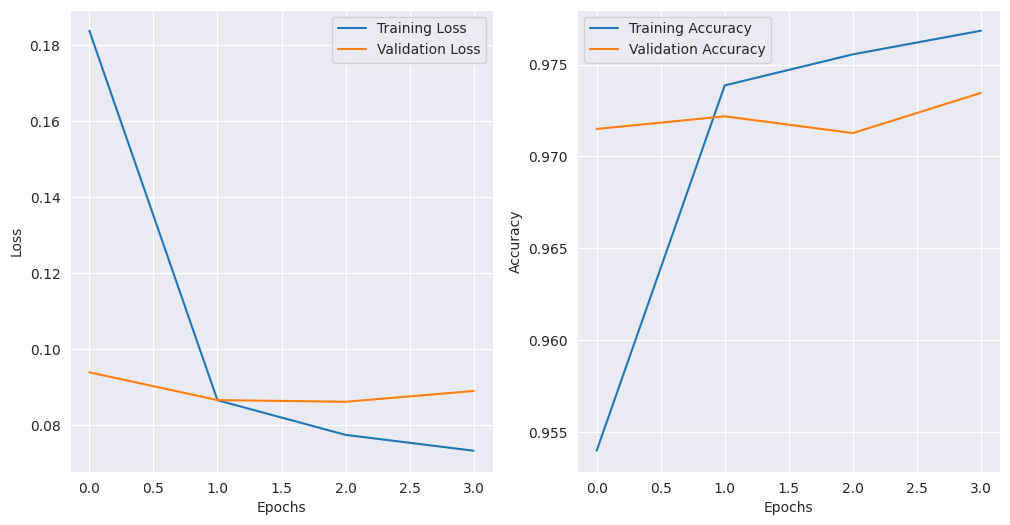

1816/1816 [==============================] - 12s 7ms/step - loss: 0.0866 - accuracy: 0.9722
Confusion Matrix:
          comp1  comp2  comp3  comp4  comps1&2  comps1&3  comps1&4  comps2&3  comps2&4  comps3&4   none
comp1       253      0      0      0         0         0         0         0         0         0    291
comp2         0    407      0      0         0         0         0         0         0         0    393
comp3         0      0    398      2         0         0         0         0         0         0    240
comp4         0      0      0    238         0         0         0         0         3         0    207
comps1&2      0      8      0      0         8         0         0         0         0         0     16
comps1&3      0      0      0      0         0         7         0         0         0         0      9
comps1&4      0      0      0      1         0         0        14         0         0         0     17
comps2&3      0      0      0      0         0         0  

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.



Precision Matrix:
Precision = True Positives / (True Positives + False Positives)
       Class  Precision
0      comp1   0.759760
1      comp2   0.793372
2      comp3   0.741155
3      comp4   0.741433
4   comps1&2   1.000000
5   comps1&3   0.875000
6   comps1&4   1.000000
7   comps2&3   0.000000
8   comps2&4   0.878788
9   comps3&4   1.000000
10      none   0.978643

Recall Matrix:
Recall= True Positives / (True Positives + False Negatives)
       Class    Recall
0      comp1  0.465074
1      comp2  0.508750
2      comp3  0.621875
3      comp4  0.531250
4   comps1&2  0.250000
5   comps1&3  0.437500
6   comps1&4  0.437500
7   comps2&3  0.000000
8   comps2&4  0.453125
9   comps3&4  0.375000
10      none  0.993082


In [124]:
label_encoder = LabelEncoder()
label_encoder.fit(y)
yn_train = label_encoder.transform(y_train)
yn_test = label_encoder.transform(y_test)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import layers, callbacks
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Set random seeds for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
#tf.config.threading.set_intra_op_parallelism_threads(1)
#tf.config.threading.set_inter_op_parallelism_threads(1)
tf.keras.backend.set_floatx('float32')

# X_train, X_test, yn_train, yn_test are training and testing data

scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=2, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Build the model
model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))  # len(label_encoder.classes_) categories

# Compile the model
model.compile(optimizer='rmsprop', #'adam', #
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, yn_train, epochs=200, batch_size=128, 
                    callbacks=[early_stopping],validation_data=(X_test_scaled, yn_test))

# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluate the model on the test set
y_pred_probabilities = model.predict(X_test_scaled)
yn_pred = np.argmax(y_pred_probabilities, axis=1)

y_pred = label_encoder.inverse_transform(yn_pred)

loss, accuracy = model.evaluate(X_test_scaled, yn_test)

modelTF48_shift_3hr = calc_acc_prec_recall(y_test,y_pred,label_encoder)

In [125]:
tableTF48_shift_3hr = pd.DataFrame(["48hr 3hr Shift Col","TensorFlow","0",round(accuracy,4),"4 Dense Layer 1024, Drop .5, BatchNorm, batch_size=128"]).T
tableTF48_shift_3hr.columns = ["Pred/lag hour","Classifier", "Rank", "Mean","Parameters"]
display(tableTF48_shift_3hr)

,Pred/lag hour,Classifier,Rank,Mean,Parameters
0,48hr 3hr Shift Col,TensorFlow,0,0.9722,"4 Dense Layer 1024, Drop .5, BatchNorm, batch_size=128"


In [126]:
yn_train = label_encoder.transform(y_train)
grid_search = grid_search_pipeline(X_train,  yn_train)

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

In [127]:
best_estimator = grid_search.best_estimator_
yn_pred = best_estimator.predict(X_test)
y_pred = label_encoder.inverse_transform(yn_pred)
model48_shift_3hr = calc_acc_prec_recall(y_test,y_pred,label_encoder)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Confusion Matrix:
          comp1  comp2  comp3  comp4  comps1&2  comps1&3  comps1&4  comps2&3  comps2&4  comps3&4   none
comp1       452      6      0      0         0         0         0         0         0         0     86
comp2         4    660      0      5         0         0         0         0         3         0    128
comp3         0      0    617      4         0         0         0         0         0         6     13
comp4         0      5      0    402         0         0         0         0         8         4     29
comps1&2     18     11      0      0         1         0         0         0         0         0      2
comps1&3      1      0     14      0         0         0         0         0         0         0      1
comps1&4      3      0      0     29         0         0         0         0         0         0      0
comps2&3      0      0      0      0         0         0         0         0         0         0      0
comps2&4      0      4      0     15         0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.



Precision Matrix:
Precision = True Positives / (True Positives + False Positives)
       Class  Precision
0      comp1   0.864245
1      comp2   0.891892
2      comp3   0.895501
3      comp4   0.779070
4   comps1&2   0.142857
5   comps1&3   0.000000
6   comps1&4   0.000000
7   comps2&3   0.000000
8   comps2&4   0.750000
9   comps3&4   0.518519
10      none   0.995229

Recall Matrix:
Recall= True Positives / (True Positives + False Negatives)
       Class    Recall
0      comp1  0.830882
1      comp2  0.825000
2      comp3  0.964063
3      comp4  0.897321
4   comps1&2  0.031250
5   comps1&3  0.000000
6   comps1&4  0.000000
7   comps2&3  0.000000
8   comps2&4  0.562500
9   comps3&4  0.875000
10      none  0.995965


In [128]:
table48_shift_3hr = create_pretty_table(grid_search, "48hr 3hr Shift Col")

,Pred/lag hour,Classifier,Rank,Mean,Parameters
1,48hr 3hr Shift Col,XGBClassifier,1,0.9906,"{'clfr__learning_rate': 0.1, 'clfr__max_depth': 6, 'clfr__n_estimators': 500}"
2,48hr 3hr Shift Col,RandomForestClassifier,13,0.9839,"{'clfr__max_depth': 20, 'clfr__n_estimators': 100}"
3,48hr 3hr Shift Col,Pipeline,17,0.9726,"{'clfr__lsvc__C': 10, 'clfr__lsvc__intercept_scaling': 100, 'clfr__lsvc__loss': 'squared_hinge'}"
0,48hr 3hr Shift Col,HistGradientBoostingClassifier,18,0.9704,"{'clfr__learning_rate': 0.1, 'clfr__max_depth': 5, 'clfr__max_iter': 500}"


Table above shows XGBClassifier has out performed other classifiers. The second best was RandomForestClassifier at **13th** position.  

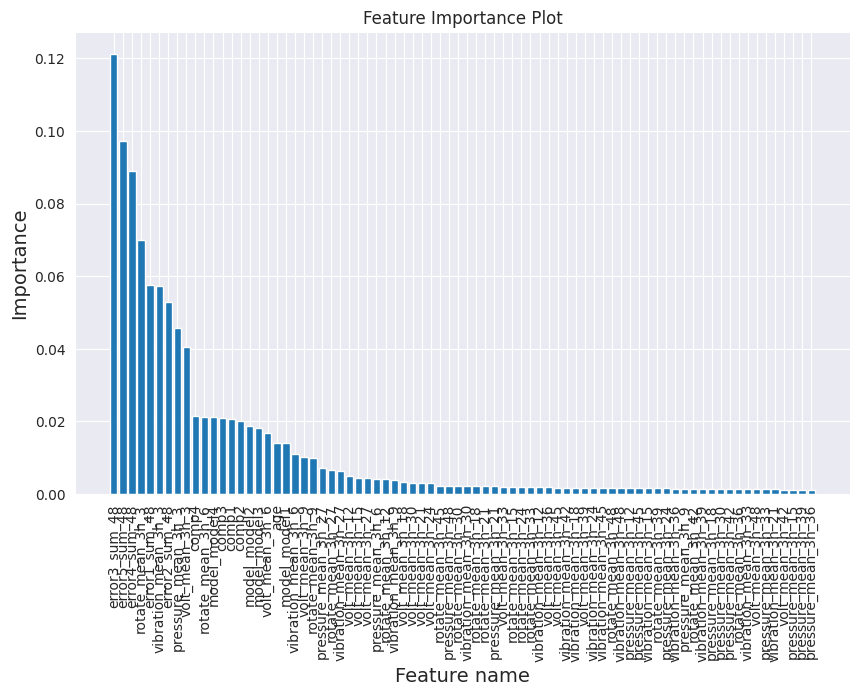

In [129]:
feature_importance_plot(X_test,best_estimator.named_steps.clfr)

In [130]:
# create a DataFrame instead of using prettytable
table_comb = pd.DataFrame(columns=["Pred/lag hour","Classifier", "Rank", "Mean","Parameters"])

# create a list of DataFrames
tlist = [tableTF24_3hr,table24_3hr,tableTF24_shift_3hr, table24_shift_3hr, tableTF36_3hr, table36_3hr, 
         tableTF48_shift_3hr, table48_shift_3hr, tableTF48_3hr,table48_3hr]

# concatenate DataFrames vertically
table_comb = pd.concat([table_comb] + tlist, ignore_index=True).sort_values(["Pred/lag hour", "Mean"], ascending=[True, False])

<a class="anchor" id="ModelEval"></a>
## Prediction and Model Evaluation & Comparison

In [131]:
#Code to display Prediction and Model Evaluation & Comparison 
# Dictionary of DFs with model variable name and model description
dfs = {'model24_3hr':"24hr Predition 3hr", 'modelTF24_3hr':"24hr Predition 3hr TensorFlow",
       'model24_shift_3hr':"24hr Predition 3hr Shift Col", 'modelTF24_shift_3hr':"24hr Predition 3hr Shift Col TensorFlow",
       'model36_3hr':"36hr Predition 3hr", 'modelTF36_3hr':"36hr Predition 3hr TensorFlow",
       'model48_3hr':"48hr Predition 3hr", 'modelTF48_3hr':"48hr Predition 3hr TensorFlow",
       'model48_shift_3hr':"48hr Predition 3hr Shift Col", 'modelTF48_shift_3hr':"48hr Predition 3hr Shift Col TensorFlow"}

# Create recall DF
recall_df = pd.DataFrame(columns=['comp1', 'comp2', 'comp3', 'comp4','comps1&2',
                                  'comps1&3','comps1&4', 'comps2&3',  'comps2&4', 'comps3&4', 'none'])
for df_name, df_descrip in dfs.items():
    # Access the dataframe using the globals() function
    df = pd.DataFrame(globals()[df_name])
    df['Recall'] = df['Recall'].round(4)
    df.reset_index(drop=True, inplace=True)
    df_transpose = df.transpose()  # Transpose DF
    df_transpose = df_transpose.iloc[1:] # Remove 1st row
    df_transpose.index = [df_descrip] # Rename 'Value' to Model description
    # Rename DF columns
    df_transpose.columns = ['comp1', 'comp2', 'comp3', 'comp4','comps1&2',
                                  'comps1&3','comps1&4', 'comps2&3',  'comps2&4', 'comps3&4', 'none']
    # Append the DF to combined recall DF
    recall_df = pd.concat([recall_df, df_transpose], ignore_index=False, axis=0)

table = PrettyTable()
table.field_names = ['Prediction / Recall Scores'] + list(recall_df.columns)

# Add rows to the table
for row in recall_df.itertuples():
    table.add_row([row[0]] + list(row[1:]))

#table.sortby = "Prediction / Recall Scores"

print("The table below shows the prediction and lag hours, the Classifier, the Rank of the Classifier for the prediction and lag hours, sorted by the Mean Score and the best HyperParameter. \nFor 36hr and 48hr prediction with 3hr, only XGBClassifier and TensorFlow was used with a rank of 0.")
#print(table_comb)
display(table_comb)
print()
print()
# Print the table
print("The best performing Models for each prediction were captured with XgBoost, using various hyper parameters tuning. \nSee table above.\n             Below show Recall scores for Rank 0 and 1 models")
display(table)

The table below shows the prediction and lag hours, the Classifier, the Rank of the Classifier for the prediction and lag hours, sorted by the Mean Score and the best HyperParameter. 
For 36hr and 48hr prediction with 3hr, only XGBClassifier and TensorFlow was used with a rank of 0.


,Pred/lag hour,Classifier,Rank,Mean,Parameters
2,24hr 3hr,XGBClassifier,1,0.9993,"{'clfr__learning_rate': 0.2, 'clfr__max_depth': 3, 'clfr__n_estimators': 1000}"
3,24hr 3hr,RandomForestClassifier,13,0.9991,"{'clfr__max_depth': 20, 'clfr__n_estimators': 50}"
0,24hr 3hr,TensorFlow,0,0.9986,"3 Dense Layer 1024, Drop .5, BatchNorm, batch_size=256"
4,24hr 3hr,Pipeline,17,0.9975,"{'clfr__lsvc__C': 100, 'clfr__lsvc__intercept_scaling': 100, 'clfr__lsvc__loss': 'hinge'}"
1,24hr 3hr,HistGradientBoostingClassifier,37,0.9862,"{'clfr__learning_rate': 0.1, 'clfr__max_depth': 5, 'clfr__max_iter': 100}"
7,24hr 3hr Shift Col,XGBClassifier,1,0.9995,"{'clfr__learning_rate': 0.1, 'clfr__max_depth': 3, 'clfr__n_estimators': 500}"
8,24hr 3hr Shift Col,RandomForestClassifier,13,0.9991,"{'clfr__max_depth': 20, 'clfr__n_estimators': 100}"
5,24hr 3hr Shift Col,TensorFlow,0,0.9979,"4 Dense Layer 1024, Drop .5, BatchNorm, batch_size=128"
9,24hr 3hr Shift Col,Pipeline,17,0.9973,"{'clfr__lsvc__C': 10, 'clfr__lsvc__intercept_scaling': 10, 'clfr__lsvc__loss': 'squared_hinge'}"
6,24hr 3hr Shift Col,HistGradientBoostingClassifier,37,0.9845,"{'clfr__learning_rate': 0.1, 'clfr__max_depth': 5, 'clfr__max_iter': 300}"




The best performing Models for each prediction were captured with XgBoost, using various hyper parameters tuning. 
See table above.
             Below show Recall scores for Rank 0 and 1 models


Prediction / Recall Scores,comp1,comp2,comp3,comp4,comps1&2,comps1&3,comps1&4,comps2&3,comps2&4,comps3&4,none
24hr Predition 3hr,0.9963,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.9995
24hr Predition 3hr TensorFlow,0.9597,1.0,0.9938,0.9911,1.0,0.875,1.0,0.0,1.0,1.0,0.9988
24hr Predition 3hr Shift Col,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.875,0.9995
24hr Predition 3hr Shift Col TensorFlow,0.9963,1.0,1.0,0.9955,0.375,0.0,0.25,0.0,1.0,0.25,0.9985
36hr Predition 3hr,0.8824,0.8733,0.9292,0.9196,0.2917,0.0,0.0,0.0,0.6875,0.0,0.9977
36hr Predition 3hr TensorFlow,0.5196,0.6467,0.6708,0.6429,0.625,0.0,0.2083,0.0,0.4375,0.6667,0.9964
48hr Predition 3hr,0.7096,0.755,0.9453,0.8973,0.0312,0.0,0.0,0.0,0.4688,0.1875,0.9965
48hr Predition 3hr TensorFlow,0.5165,0.475,0.7219,0.4978,0.4062,0.0625,0.2812,0.0,0.5469,0.4375,0.9926
48hr Predition 3hr Shift Col,0.8309,0.825,0.9641,0.8973,0.0312,0.0,0.0,0.0,0.5625,0.875,0.996
48hr Predition 3hr Shift Col TensorFlow,0.4651,0.5088,0.6219,0.5312,0.25,0.4375,0.4375,0.0,0.4531,0.375,0.9931


<a class="anchor" id="Observation"></a>
## General Observation

On all models, error was the most important feature, with voltage 24-hour mean and rotation 24-hour max some distance away for 24-hour prediction.
The predictions using the shift column lag had a slightly better score than the 3hr lag with mean, min, max, and std.
XGboost was the best-performing estimator, even without any hyperparameter tuning on every prediction, even better than TensorFlow.  

The longer the prediction window, the more difficult it is for the model to give accurate results.
In all predictions, comp3 had the best recall, but it could be related to the lowest count in the failure dataset.

Could not use TimeSeriesSplit(n_splits=3) after adding simultaneous classifications, as XGboost has problem when cv train data not in test.

In Machine Learning, EDA can take up a lot of time to prepare data for modelling.

As more than one component failed at the same time, added 6 more classes for the simultaneous component failures. The logic behind this approach, is the same senor events that happened in history could impact simultaneous components failing again in the future. 

After providing a solution for the simultaneous failures and trying to get better predictions for the 48-hour model, I tried 36-hour and the recall predictions were unexpectantly low. I tried using TensorFlow LSTM, contemplated using Conv1D with various detrend kernel filters, tried many different batch sizes and tried 6-hour lag. After further analysis, I observed why there is such a strong relationship between errors and failure for the 24-hour model. 

You may disagree, but this dataset was 'designed' for 24-hour predictions based on the failures csv file.

**The 24-hour prediction model using XgBoost with best hyper parameters tuning {'clfr__learning_rate': 0.2, 'clfr__max_depth': 3, 'clfr__n_estimators': 1000} can be used to predict component failure.**


<a class="anchor" id="Ob_design"></a>
### This Dataset 'designed' for 24 hour prediction


Below is a sample of what the majority of the records look like with 24-hour backfill. All errors are associated perfectly with failure records. Meaning an error record starts at exactly 09:00, (within the 24-hour window) before failure. For simultaneous failures, 2 or 3 errors are associated perfectly with failure records.
Only 13 failure records did not have any errors associated with them. 

The Ratio (Training + Validation) of errors directly associated with the failure category within the 24-hour failure event window was 99.77%. 
In a real-world scenario, I do not believe that component/s failure would only happen 24 hours after the error/s signal, that is highly improbable.

By adding categories for the simultaneous failures combined with the overwhelming majority of errors perfectly associated with labeled failures, the algorithms learned these relationships and gave almost perfect recall scores for 24-hour XgBoost models.

In [132]:
#import pandas as pd
#labeled_features= pd.read_csv("labeled_features.csv")
labeled_features['datetime'] = pd.to_datetime(labeled_features['datetime'])
error_columns = ['error1_sum_24', 'error2_sum_24', 'error3_sum_24', 'error4_sum_24', 'error5_sum_24'] 

# Sum errors to find rows with error/s and create binary check_err column if any error exist and failure not 'none'
labeled_features['check_err'] = ((labeled_features[error_columns].sum(axis=1) != 0) & (labeled_features['failure'] != 'none')).astype(int)

# Show a sample of what majority of the records look like with 24 hour bfill. 
# All errors associate perfectly with failure records.
display(labeled_features[['machineID', 'datetime'] + error_columns + ['failure','check_err']].iloc[2773:2789]) #[(labeled_features['check_err'] == 1)].head(24))

ratio = (len(labeled_features[['machineID', 'datetime'] + error_columns + ['failure','check_err']][(labeled_features['check_err'] == 1)]) /
    len(labeled_features[['machineID', 'datetime'] + error_columns + ['failure','check_err']][(labeled_features['failure'] != 'none')]))
print(f"24 hour prediction. Ratio (Training + Validation) of errors directly 'overlapping' failure category : {ratio}")

# DF of failures without any associated errors 13 rows!!
print('\n                             Failures without any associated errors: 13 rows!!')
display(labeled_features[['machineID', 'datetime'] + error_columns + ['failure','check_err']][(labeled_features['failure'] != 'none')
                                                                                     & (labeled_features['check_err'] == 0)])

,machineID,datetime,error1_sum_24,error2_sum_24,error3_sum_24,error4_sum_24,error5_sum_24,failure,check_err
2773,1,2015-12-14 21:00:00,0.0,0.0,0.0,0.0,0.0,none,0
2774,1,2015-12-15 00:00:00,0.0,0.0,0.0,0.0,0.0,none,0
2775,1,2015-12-15 03:00:00,0.0,0.0,0.0,0.0,0.0,none,0
2776,1,2015-12-15 06:00:00,0.0,0.0,0.0,0.0,0.0,none,0
2777,1,2015-12-15 09:00:00,0.0,0.0,0.0,0.0,1.0,comp4,1
2778,1,2015-12-15 12:00:00,0.0,0.0,0.0,0.0,1.0,comp4,1
2779,1,2015-12-15 15:00:00,0.0,0.0,0.0,0.0,1.0,comp4,1
2780,1,2015-12-15 18:00:00,0.0,0.0,0.0,0.0,1.0,comp4,1
2781,1,2015-12-15 21:00:00,0.0,0.0,0.0,0.0,1.0,comp4,1
2782,1,2015-12-16 00:00:00,0.0,0.0,0.0,0.0,1.0,comp4,1


24 hour prediction. Ratio (Training + Validation) of errors directly 'overlapping' failure category : 0.9976851851851852

                             Failures without any associated errors: 13 rows!!


,machineID,datetime,error1_sum_24,error2_sum_24,error3_sum_24,error4_sum_24,error5_sum_24,failure,check_err
66992,23,2015-12-31 12:00:00,0.0,0.0,0.0,0.0,0.0,comp1,0
66993,23,2015-12-31 15:00:00,0.0,0.0,0.0,0.0,0.0,comp1,0
66994,23,2015-12-31 18:00:00,0.0,0.0,0.0,0.0,0.0,comp1,0
66995,23,2015-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,comp1,0
209729,72,2015-12-31 12:00:00,0.0,0.0,0.0,0.0,0.0,comp3,0
209730,72,2015-12-31 15:00:00,0.0,0.0,0.0,0.0,0.0,comp3,0
209731,72,2015-12-31 18:00:00,0.0,0.0,0.0,0.0,0.0,comp3,0
209732,72,2015-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,comp3,0
209733,72,2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,comp3,0
209734,72,2016-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,comp3,0


Below is a sample of what majority of the records look like with 36 hour backfill. No errors for first 4 failure records. Error/s extend 4 records beyond failure label. 
The Ratio (Training + Validation) of errors directly associated with the failure category within the 36-hour failure event window was 70.58%

For 48 hour prediction. Ratio (Training + Validation) of errors directly associated with the failure category within the 48-hour failure event window was 57.34%

In [133]:
#labeled_features= labeled_features36
#labeled_features['datetime'] = pd.to_datetime(labeled_features['datetime'])
error_columns = ['error1_sum_36', 'error2_sum_36', 'error3_sum_36', 'error4_sum_36', 'error5_sum_36'] 

# Sum errors to find rows with error/s and create binary check_err column if any error exist and failure not 'none'
labeled_features36['check_err'] = ((labeled_features36[error_columns].sum(axis=1) != 0) & (labeled_features36['failure'] != 'none')).astype(int)

# Show a sample of what majority of the records look like with 36 hour bfill. No errors for first 4 failure records
# Error extend 4 records beyond failure label
display(labeled_features36[['machineID', 'datetime'] + error_columns + ['failure','check_err']].iloc[2765:2785]) #[(labeled_features36['check_err'] == 1)].head(36))

ratio = (len(labeled_features36[['machineID', 'datetime'] + error_columns + ['failure','check_err']][(labeled_features36['check_err'] == 1)]) /
    len(labeled_features36[['machineID', 'datetime'] + error_columns + ['failure','check_err']][(labeled_features36['failure'] != 'none')]))
print(f"36 hour prediction. Ratio (Training + Validation) of errors directly 'overlapping' failure category : {ratio}")

# DF of failures without any associated errors 13 rows!!
print('\n                             Failures without any associated errors: 2468 rows!!')
display(labeled_features36[['machineID', 'datetime'] + error_columns + ['failure','check_err']][(labeled_features36['failure'] != 'none')
                                                                                     & (labeled_features36['check_err'] == 0)])

,machineID,datetime,error1_sum_36,error2_sum_36,error3_sum_36,error4_sum_36,error5_sum_36,failure,check_err
2765,1,2015-12-14 09:00:00,0.0,0.0,0.0,0.0,0.0,none,0
2766,1,2015-12-14 12:00:00,0.0,0.0,0.0,0.0,0.0,none,0
2767,1,2015-12-14 15:00:00,0.0,0.0,0.0,0.0,0.0,none,0
2768,1,2015-12-14 18:00:00,0.0,0.0,0.0,0.0,0.0,none,0
2769,1,2015-12-14 21:00:00,0.0,0.0,0.0,0.0,0.0,comp4,0
2770,1,2015-12-15 00:00:00,0.0,0.0,0.0,0.0,0.0,comp4,0
2771,1,2015-12-15 03:00:00,0.0,0.0,0.0,0.0,0.0,comp4,0
2772,1,2015-12-15 06:00:00,0.0,0.0,0.0,0.0,0.0,comp4,0
2773,1,2015-12-15 09:00:00,0.0,0.0,0.0,0.0,1.0,comp4,1
2774,1,2015-12-15 12:00:00,0.0,0.0,0.0,0.0,1.0,comp4,1


36 hour prediction. Ratio (Training + Validation) of errors directly 'overlapping' failure category : 0.7057701478302336

                             Failures without any associated errors: 2468 rows!!


,machineID,datetime,error1_sum_36,error2_sum_36,error3_sum_36,error4_sum_36,error5_sum_36,failure,check_err
849,1,2015-04-18 21:00:00,0.0,0.0,0.0,0.0,0.0,comp2,0
850,1,2015-04-19 00:00:00,0.0,0.0,0.0,0.0,0.0,comp2,0
851,1,2015-04-19 03:00:00,0.0,0.0,0.0,0.0,0.0,comp2,0
852,1,2015-04-19 06:00:00,0.0,0.0,0.0,0.0,0.0,comp2,0
1329,1,2015-06-17 21:00:00,0.0,0.0,0.0,0.0,0.0,comp4,0
...,...,...,...,...,...,...,...,...,...
289987,100,2015-09-09 06:00:00,0.0,0.0,0.0,0.0,0.0,comp1,0
290704,100,2015-12-07 21:00:00,0.0,0.0,0.0,0.0,0.0,comp2,0
290705,100,2015-12-08 00:00:00,0.0,0.0,0.0,0.0,0.0,comp2,0
290706,100,2015-12-08 03:00:00,0.0,0.0,0.0,0.0,0.0,comp2,0
